<a href="https://colab.research.google.com/github/KubaWinsztal/MachineLearning/blob/main/PD8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

**Function for plotting the results**

In [58]:
def plot_results(epoch, points, focus1, focus2, loss_history=None):
    # Create a 2-panel plot if loss_history is provided, otherwise just one
    if loss_history is not None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(6, 6))
        axes = [axes]

    # Convert points to numpy for plotting
    pts = points.detach().cpu().numpy()
    axes[0].scatter(pts[:, 0], pts[:, 1], s=10, alpha=0.8)

    # Plot the two foci as red X marks
    f1 = focus1.detach().cpu().numpy()
    f2 = focus2.detach().cpu().numpy()
    axes[0].scatter([f1[0], f2[0]], [f1[1], f2[1]], color='red', marker='x', s=100)

    # Set axis labels and enable grid
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].grid()

    # If loss history is given, show it in the second subplot
    if loss_history is not None:
        axes[0].set_title(f'Points after Epoch {epoch}')
        axes[1].plot(loss_history, color='blue')
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].set_title("Loss Convergence")
        axes[1].grid()
    else:
        axes[0].set_title(f'Points before Epoch {epoch}')

    # Display the plot in the notebook
    plt.show()
    plt.close()


In [59]:
#%%
# Parameters
focus1 = torch.tensor([-2.0, 0.0])
focus2 = torch.tensor([2.0, 0.0])
constant_sum = 6.0
num_points = 100


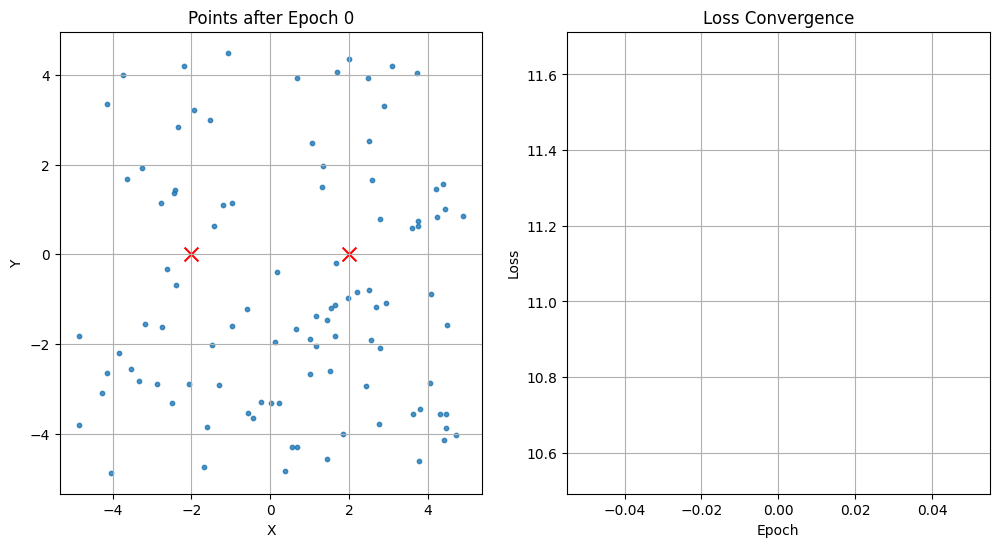

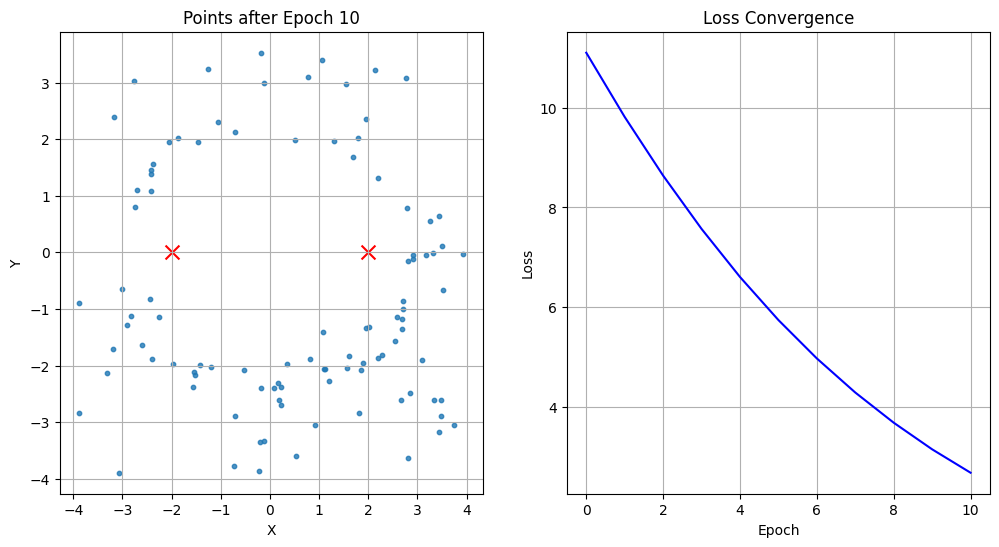

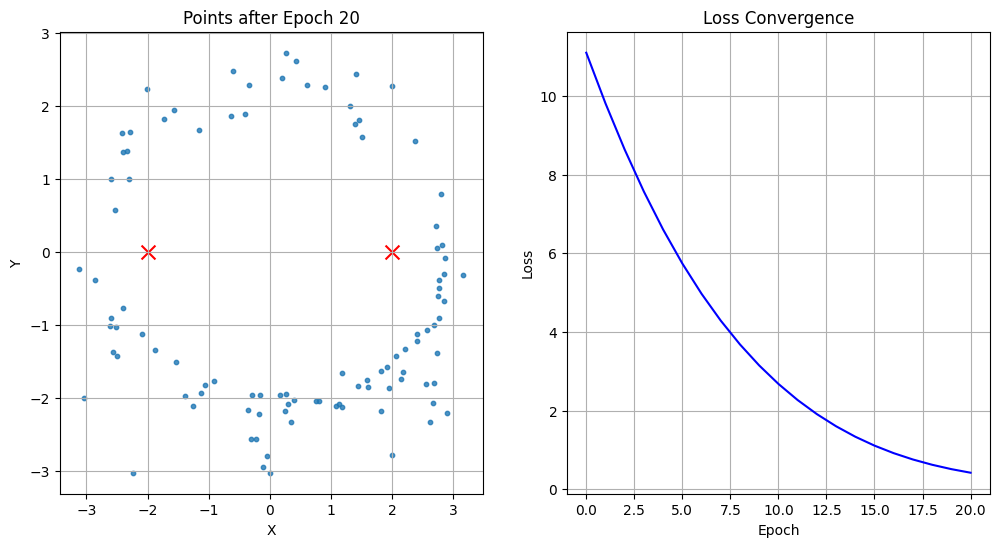

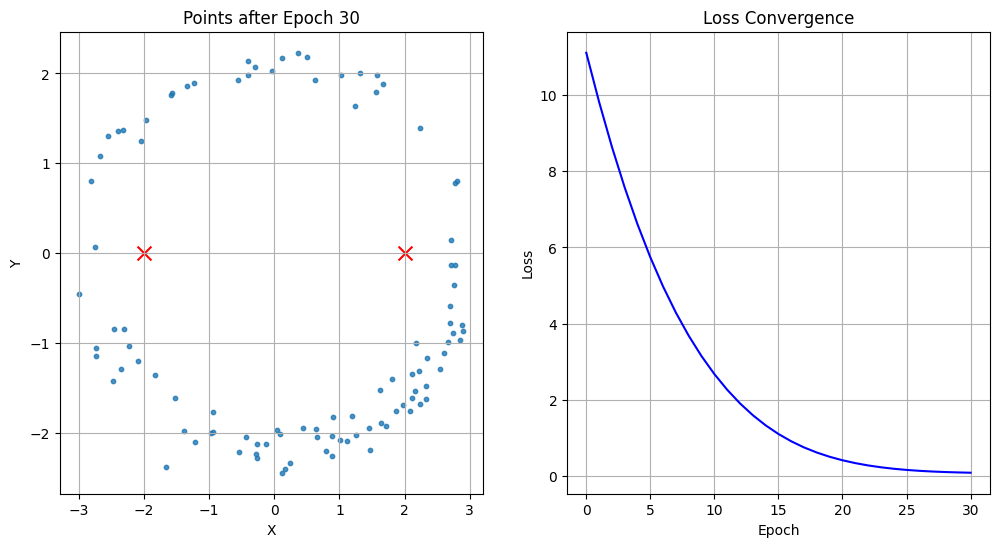

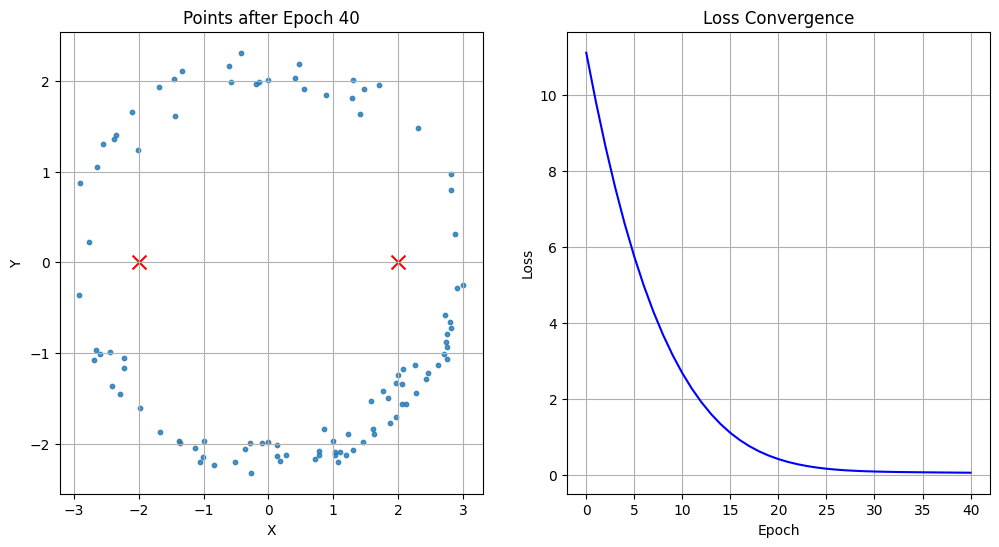

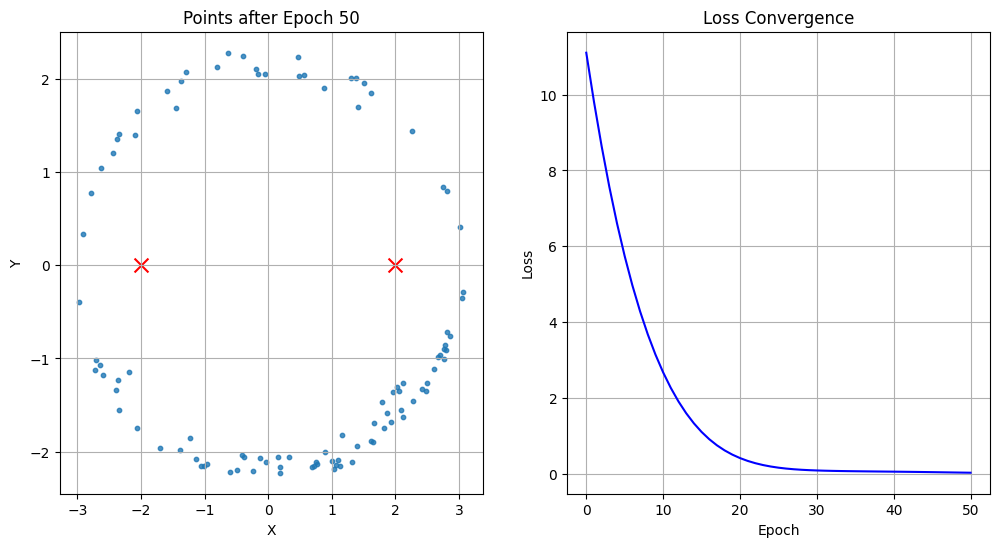

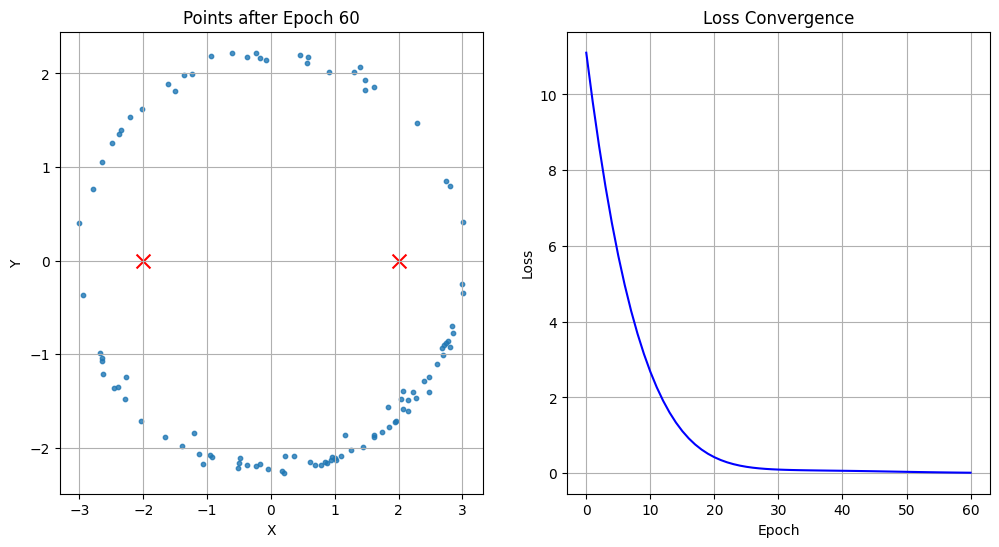

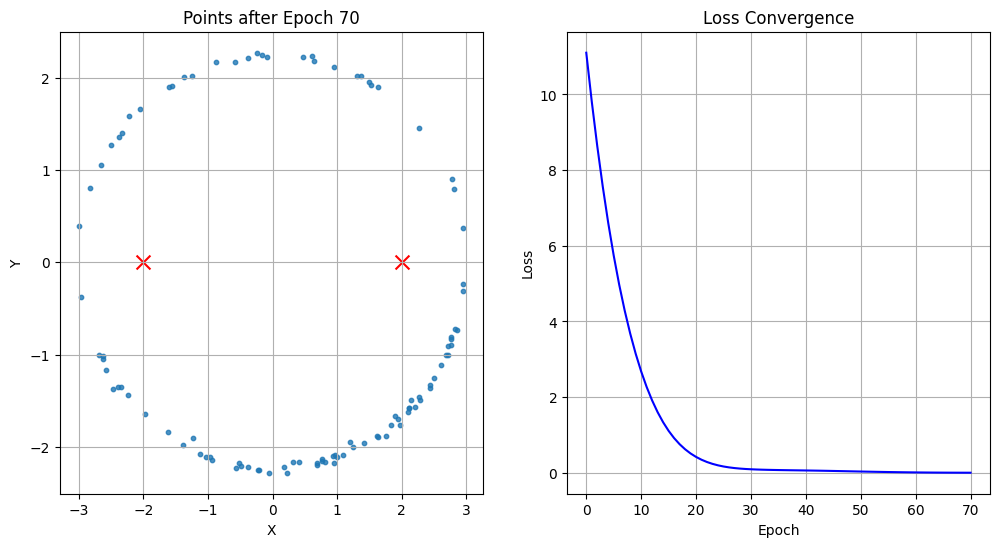

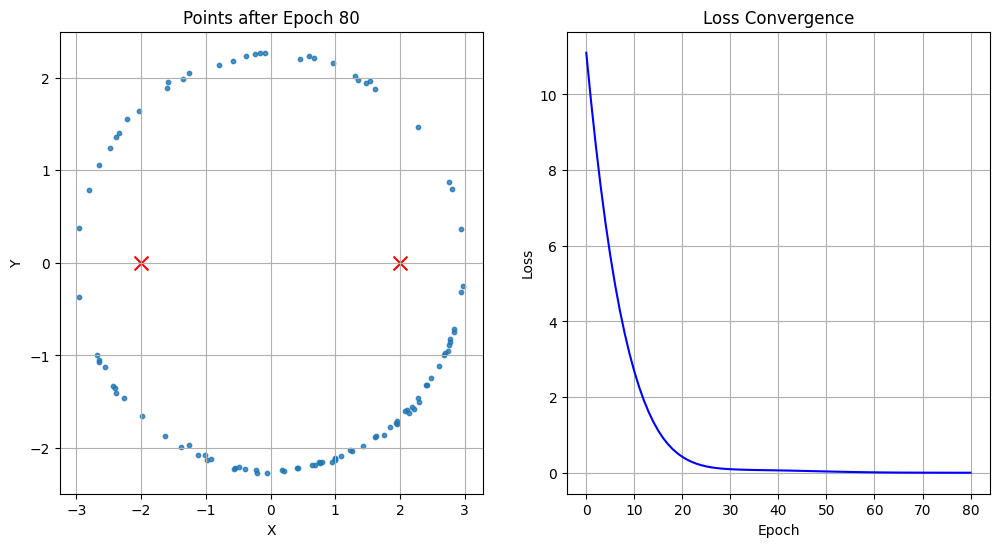

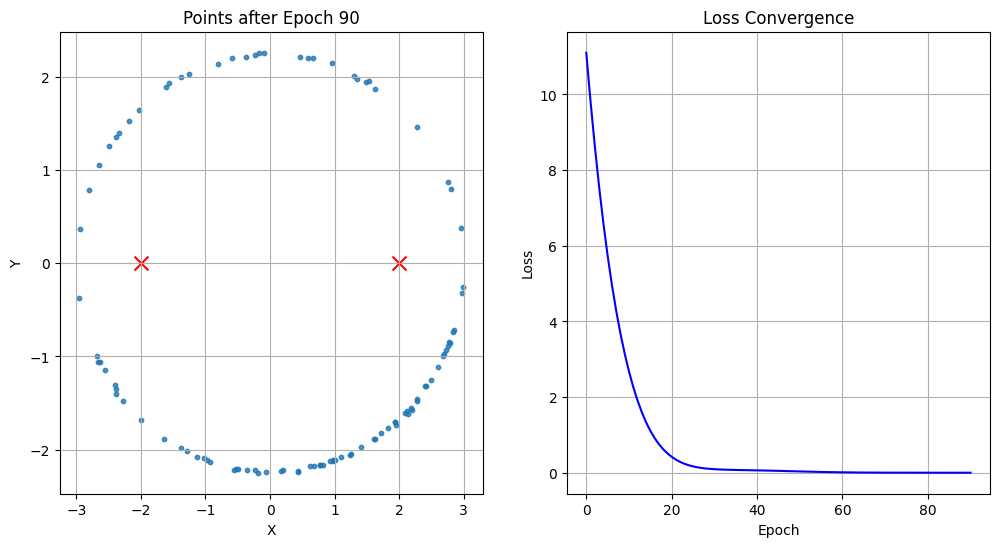

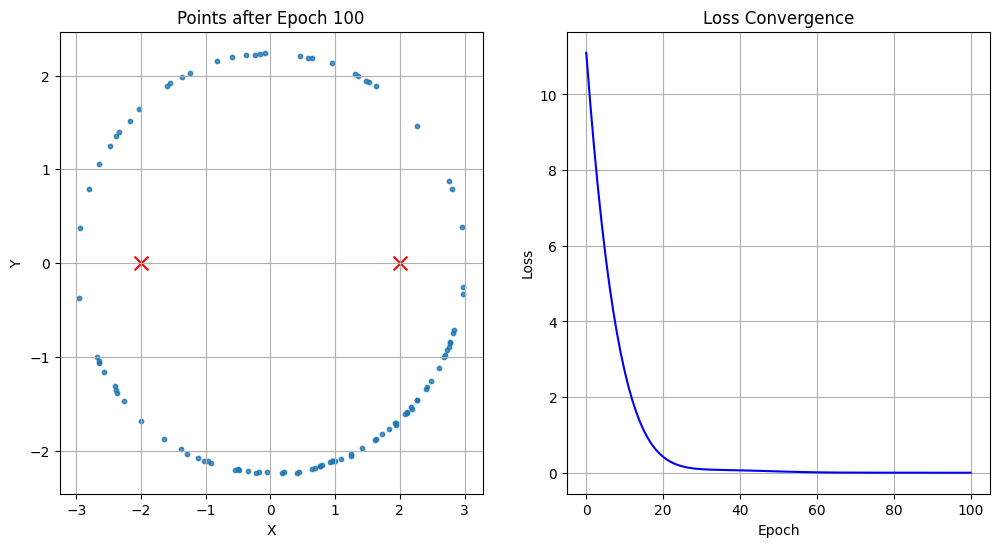

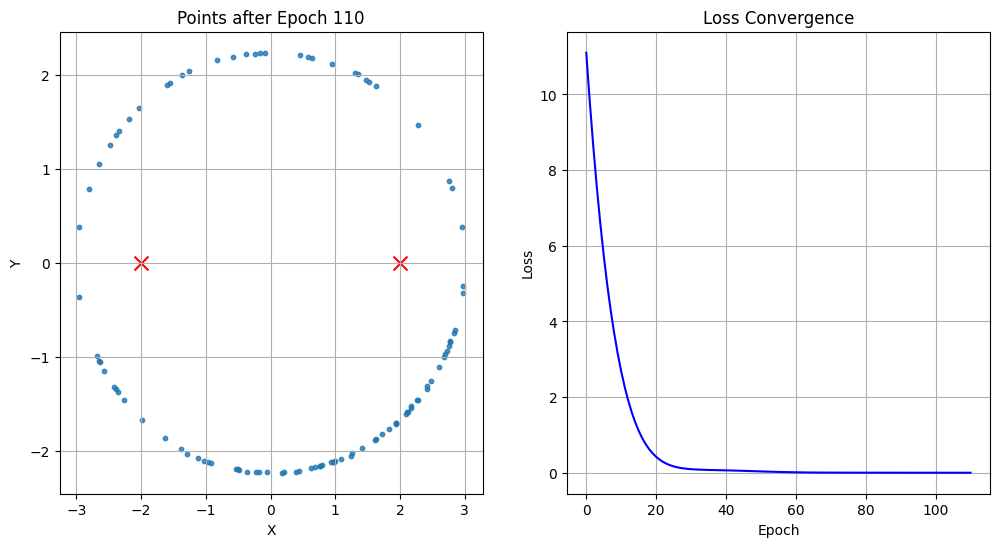

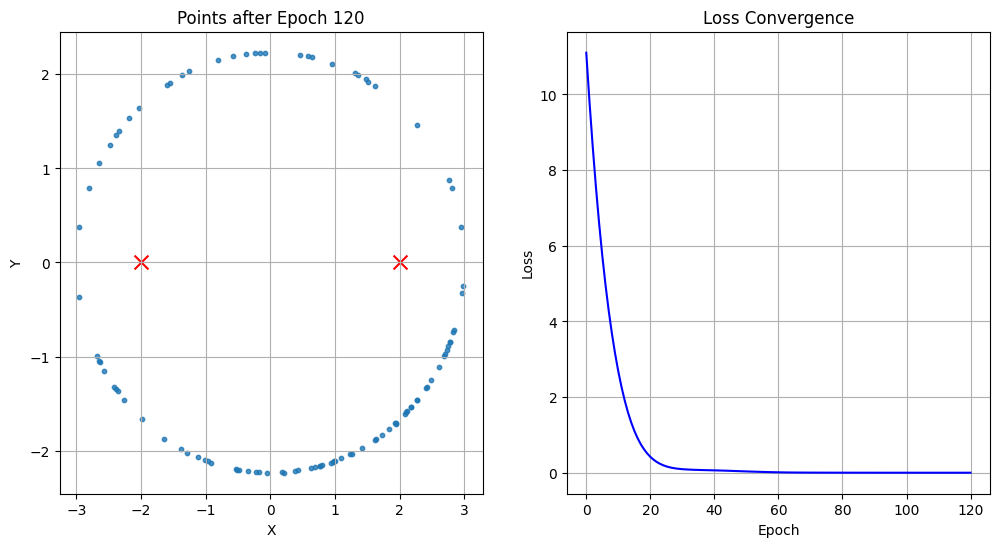

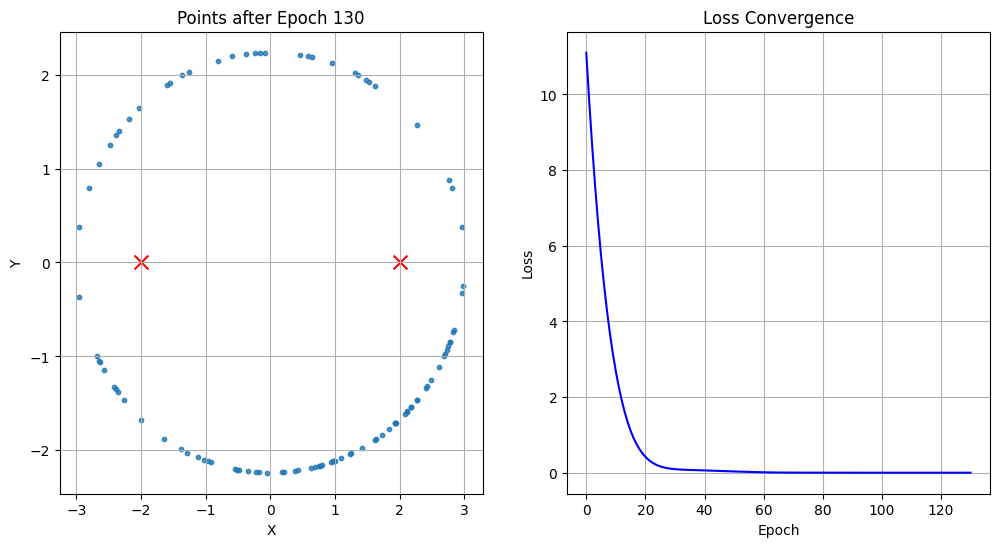

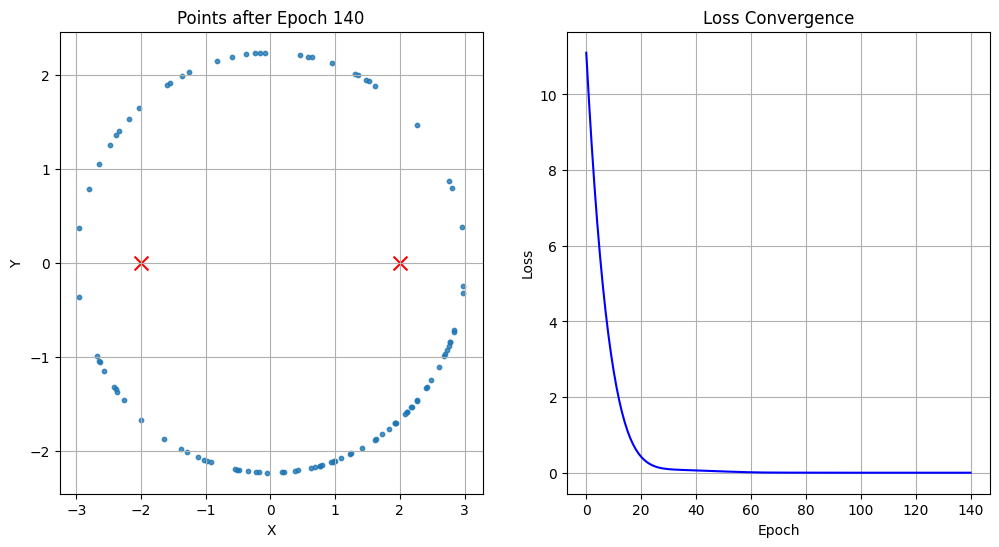

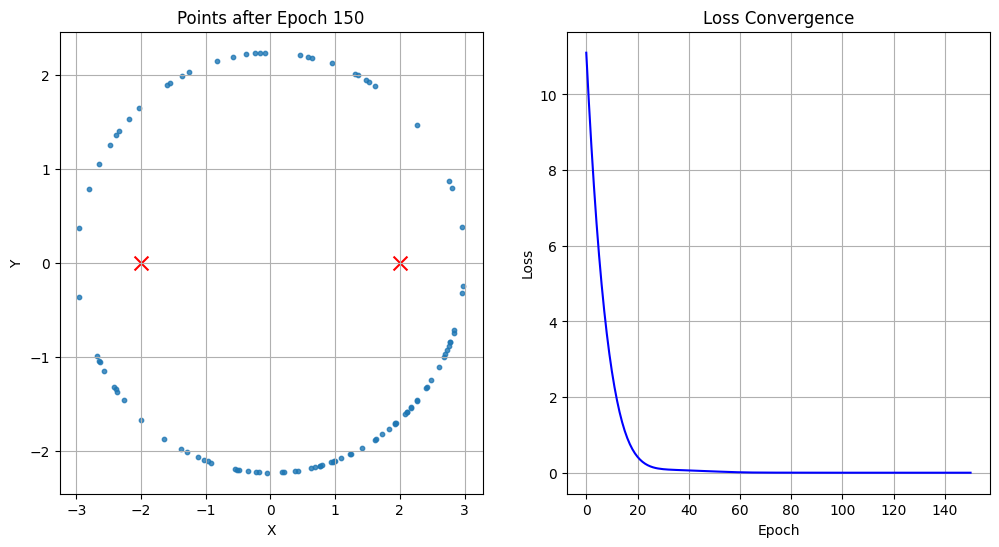

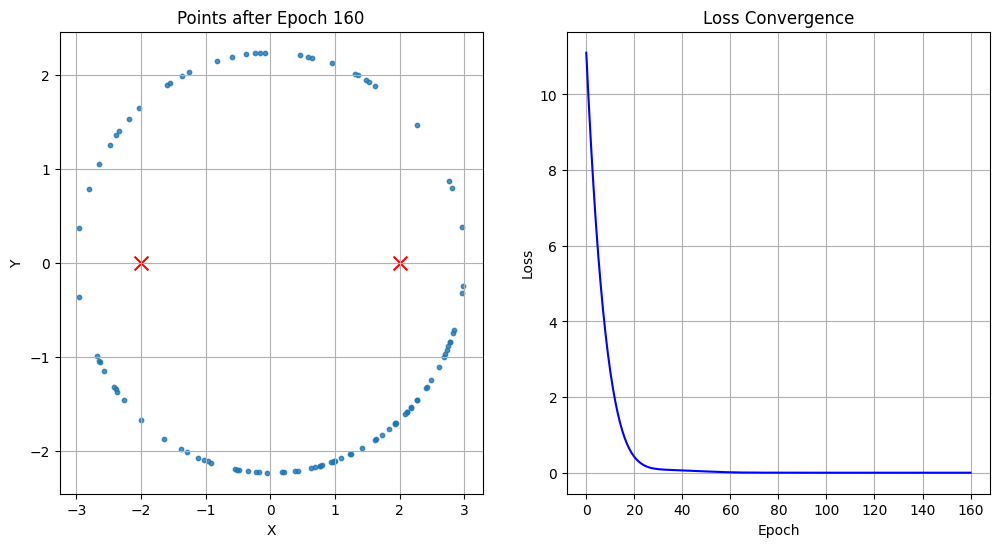

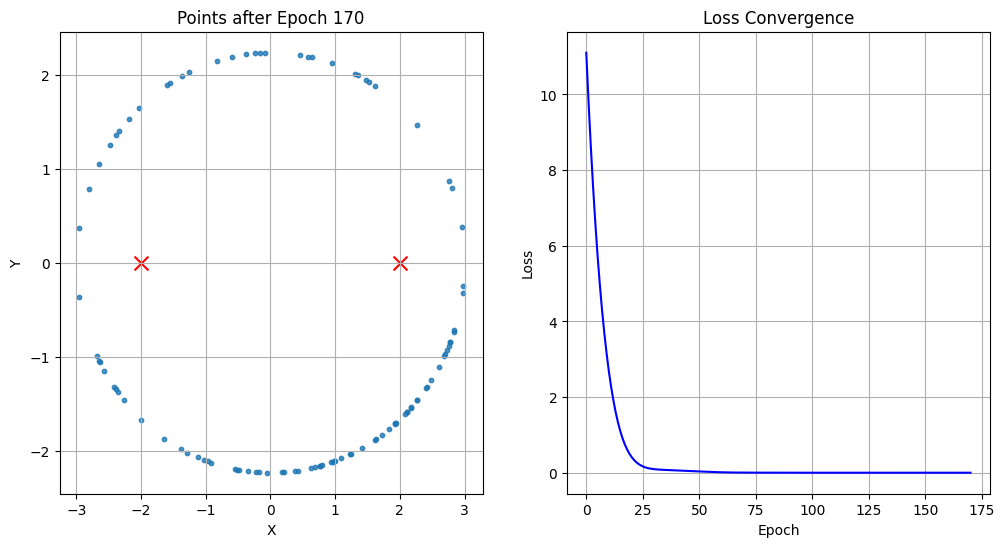

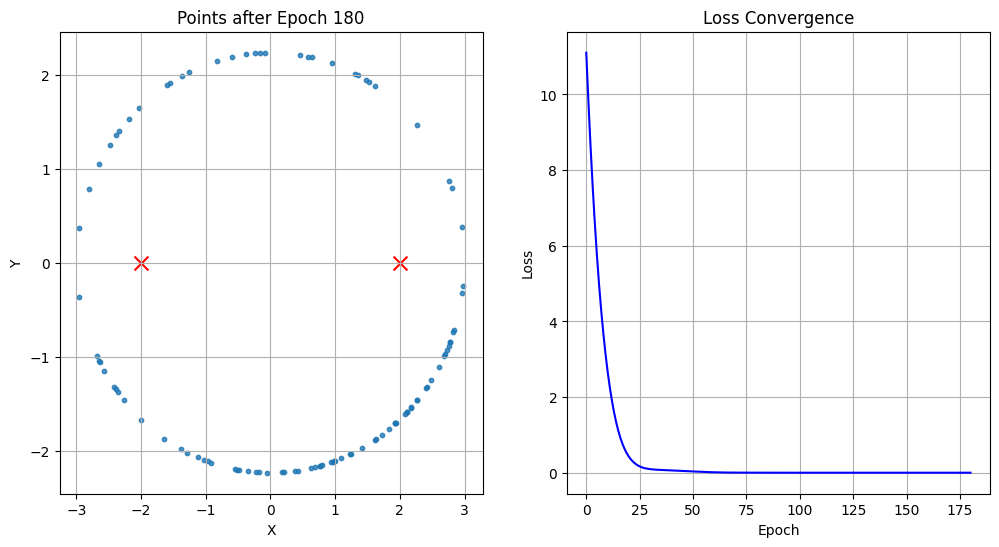

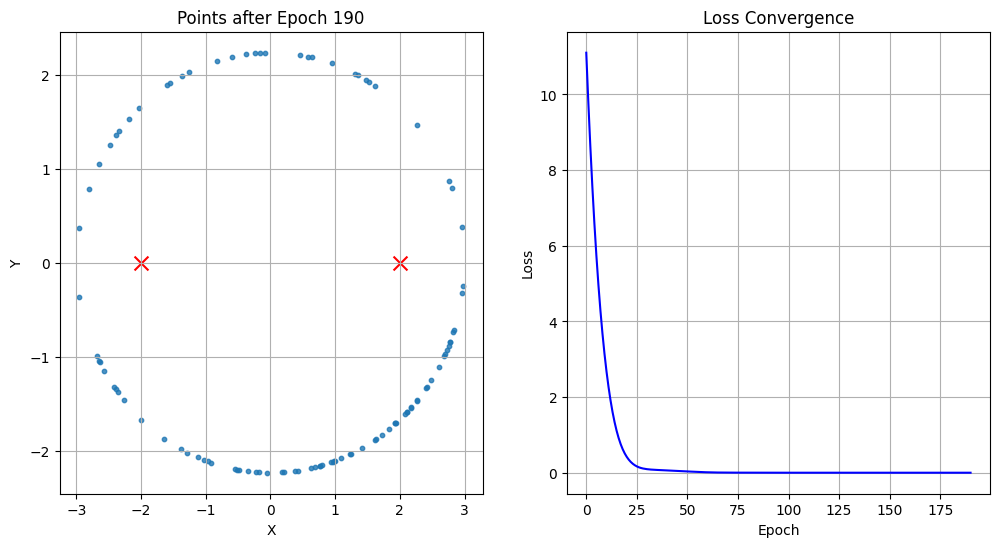

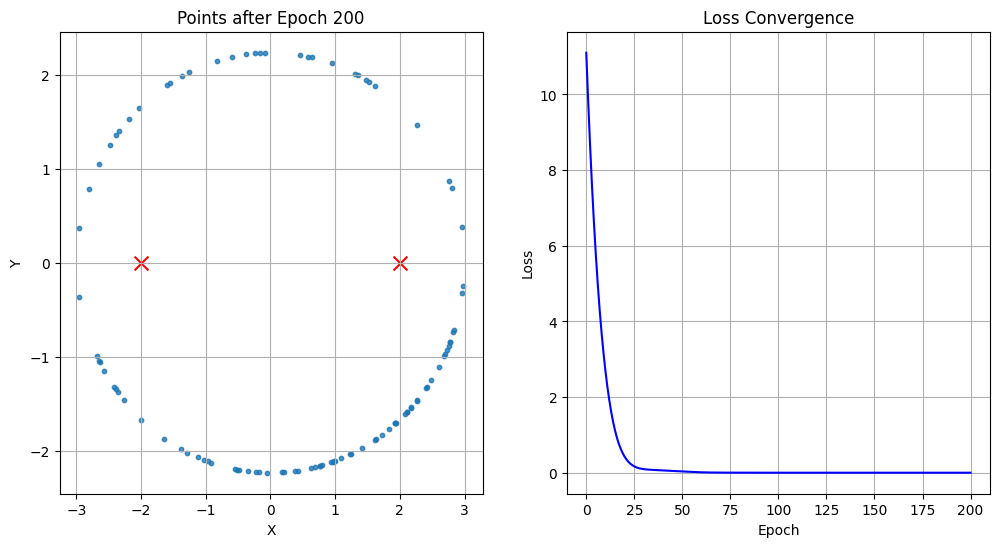

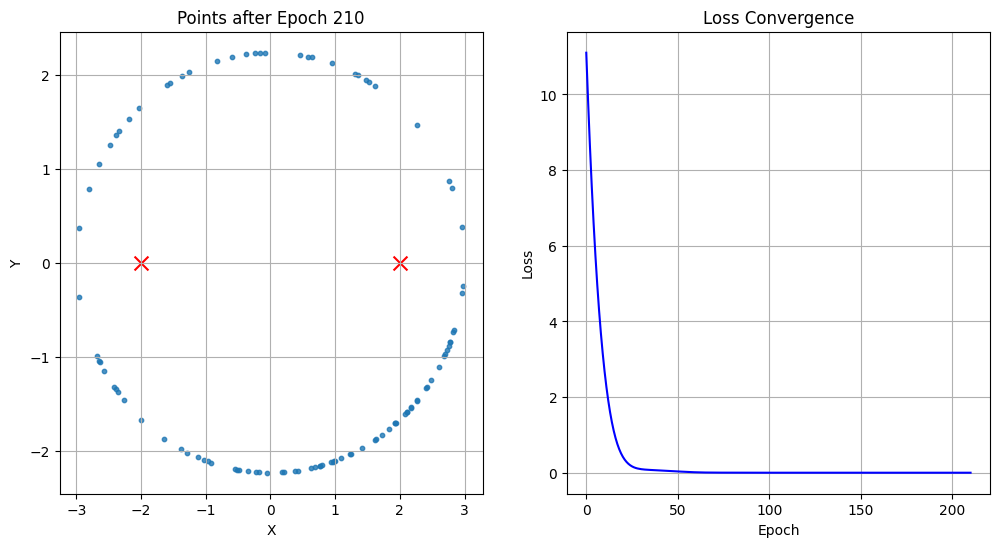

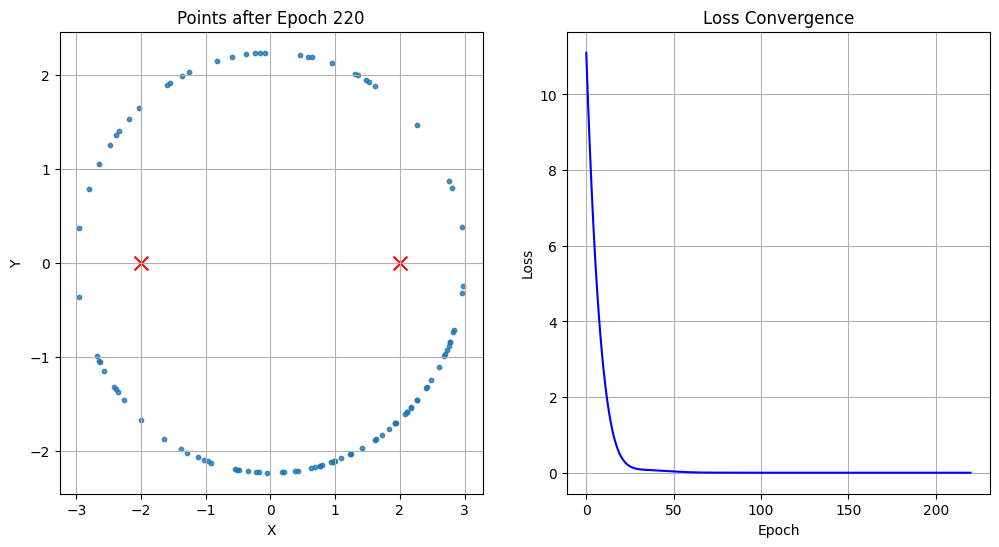

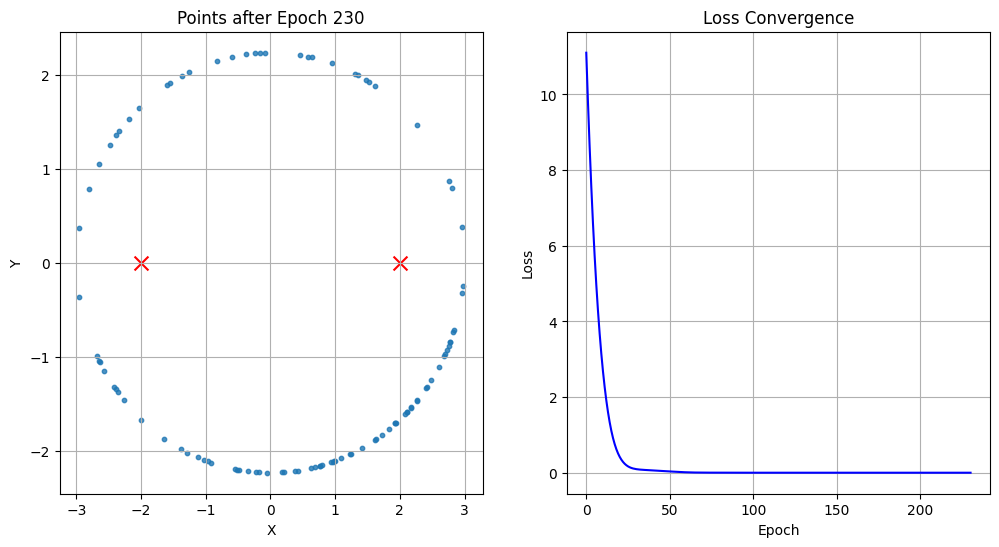

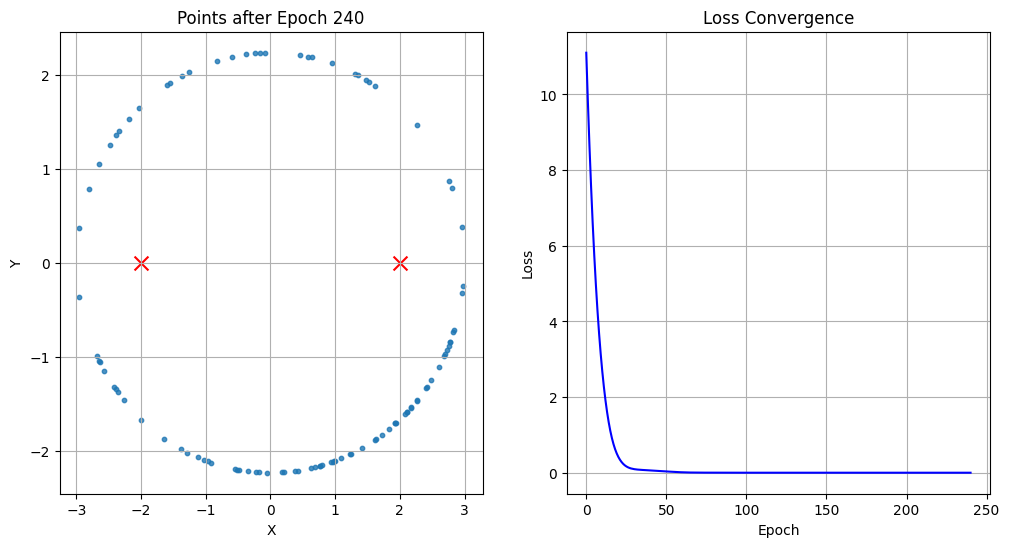

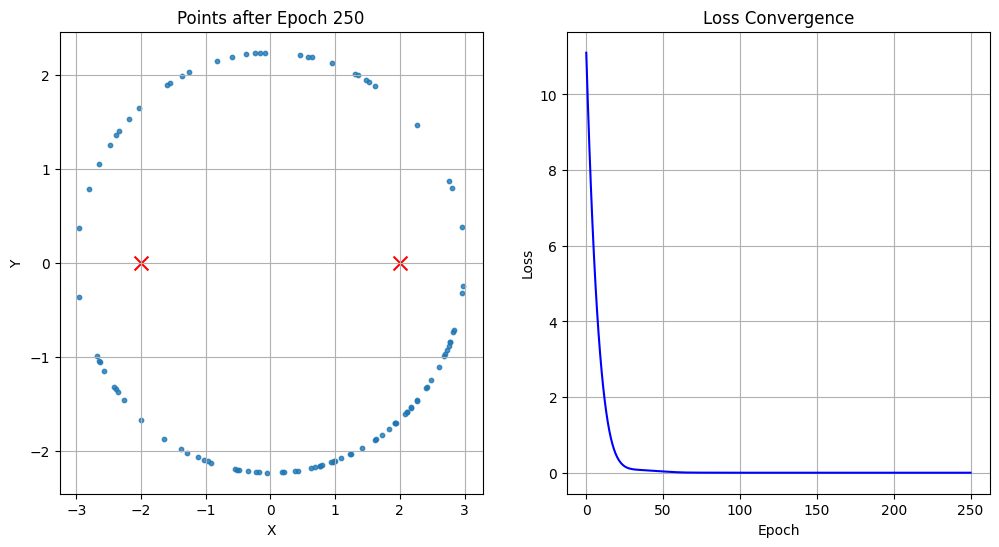

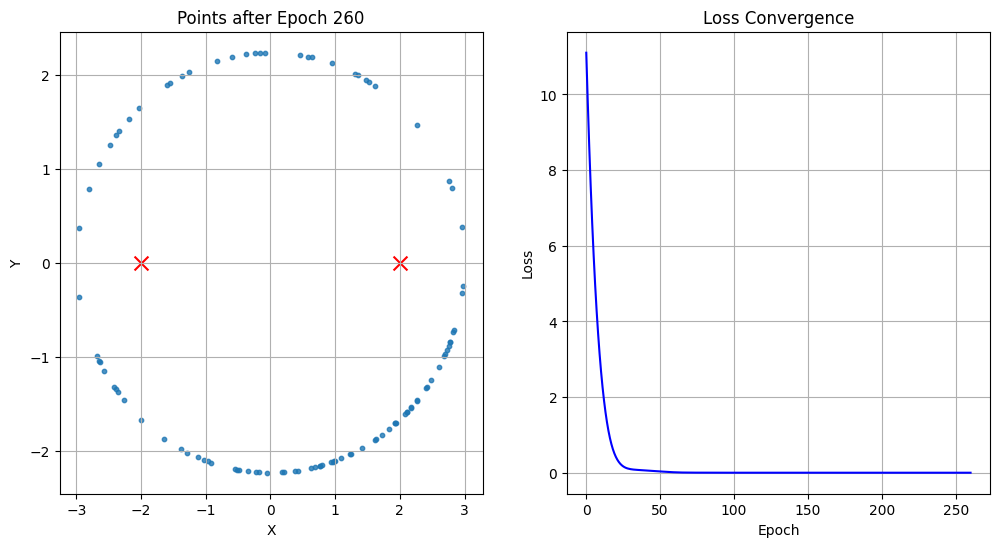

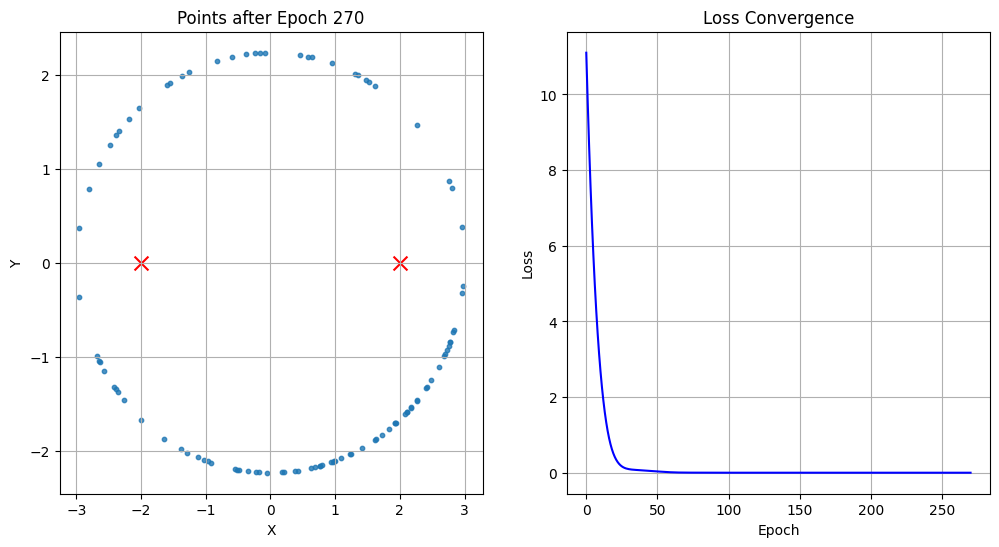

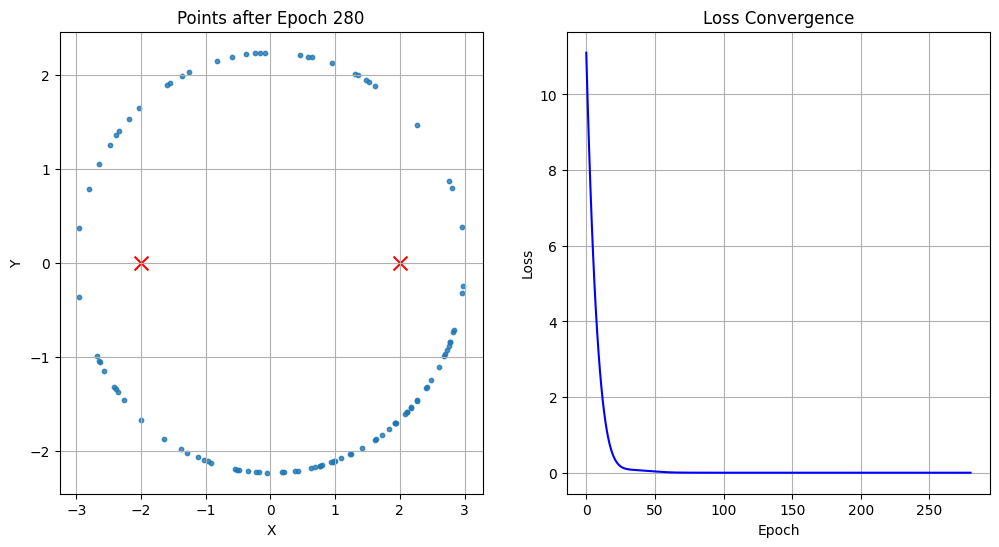

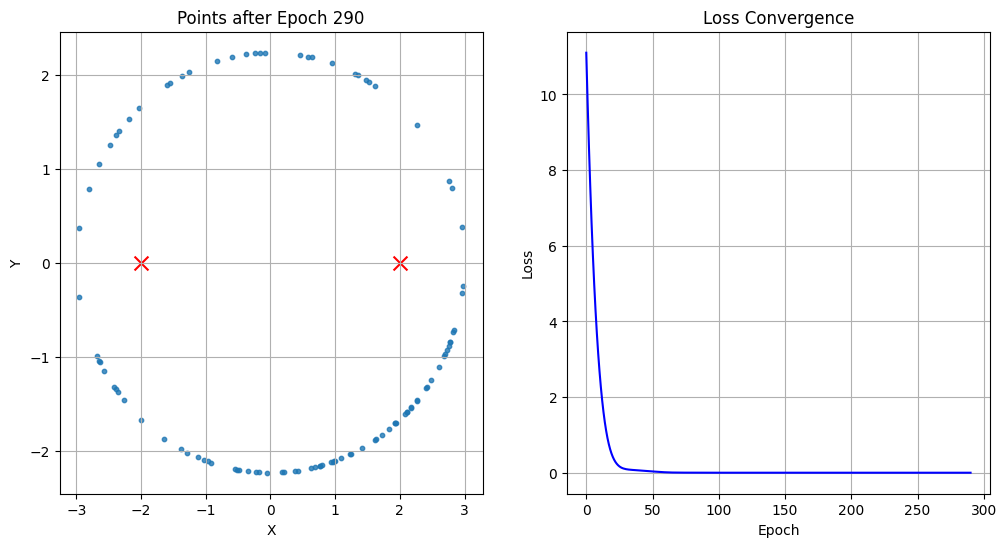

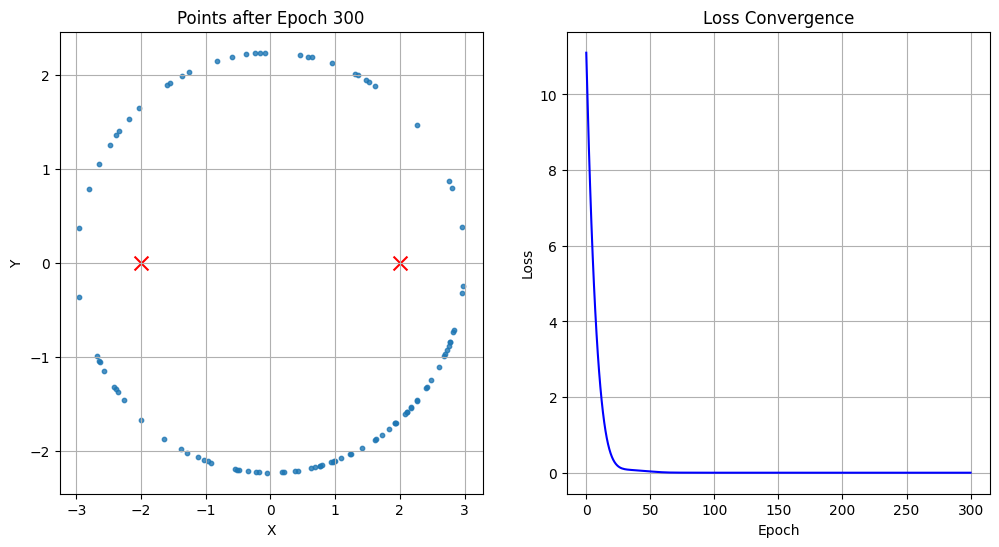

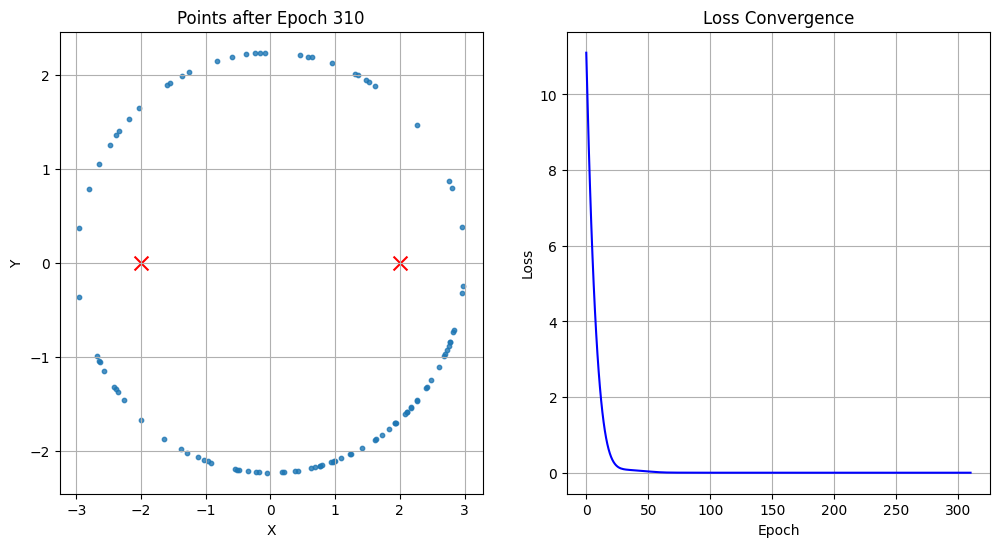

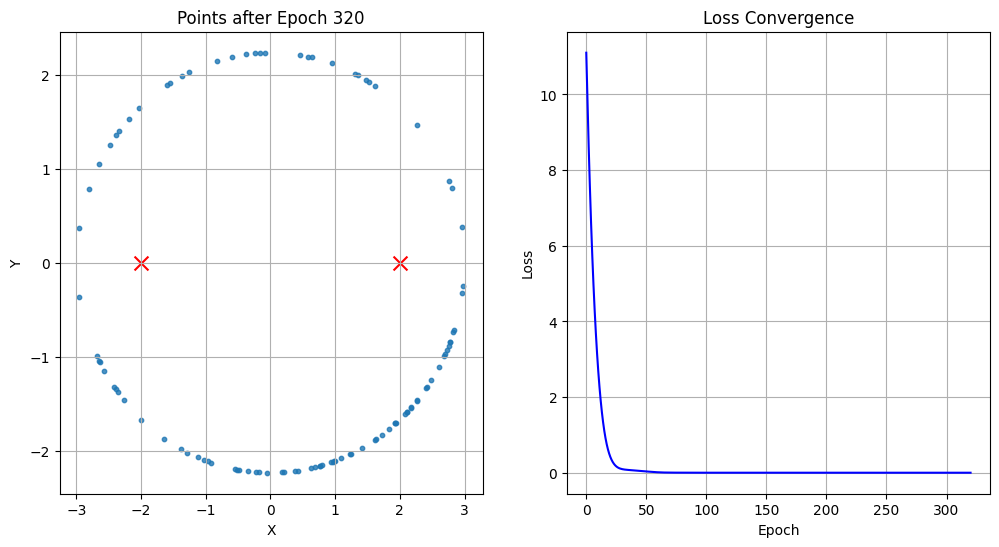

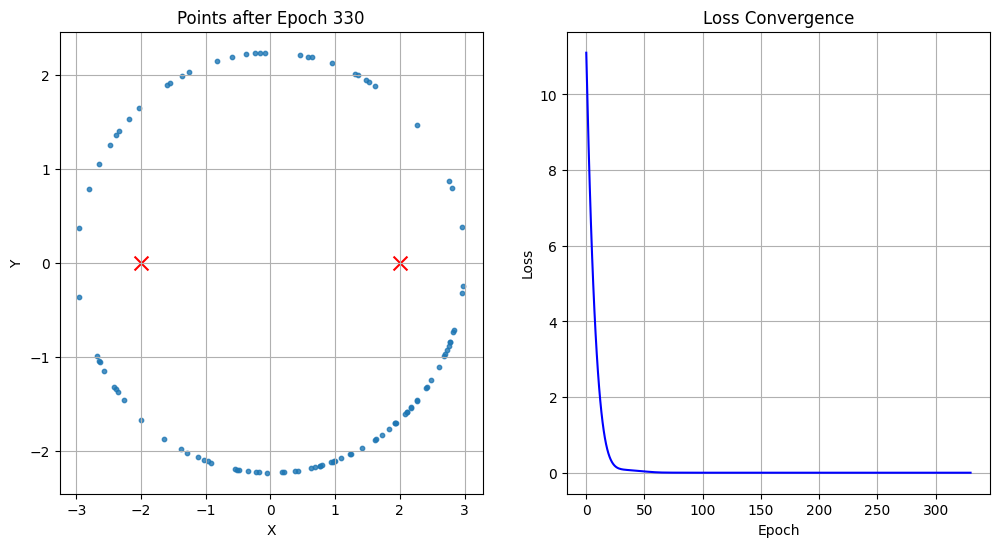

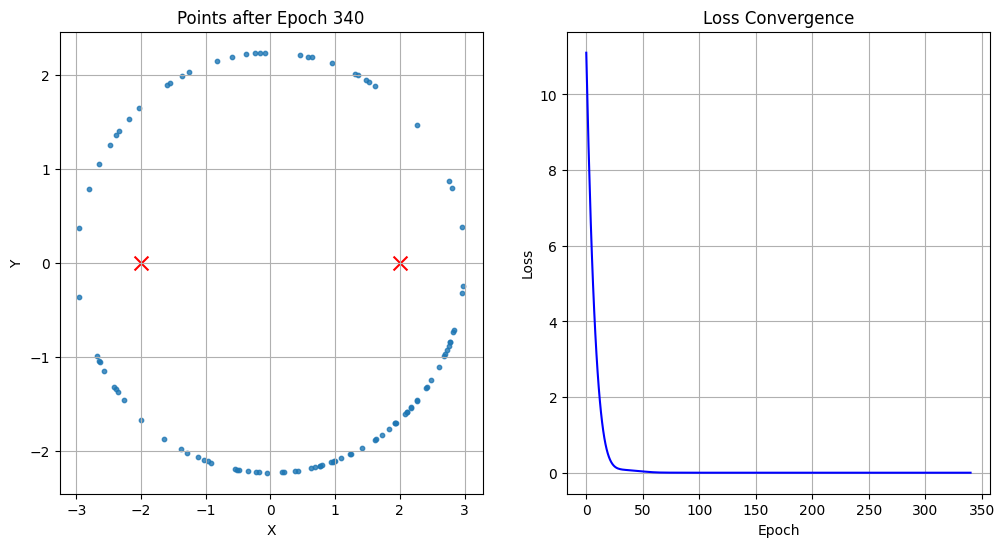

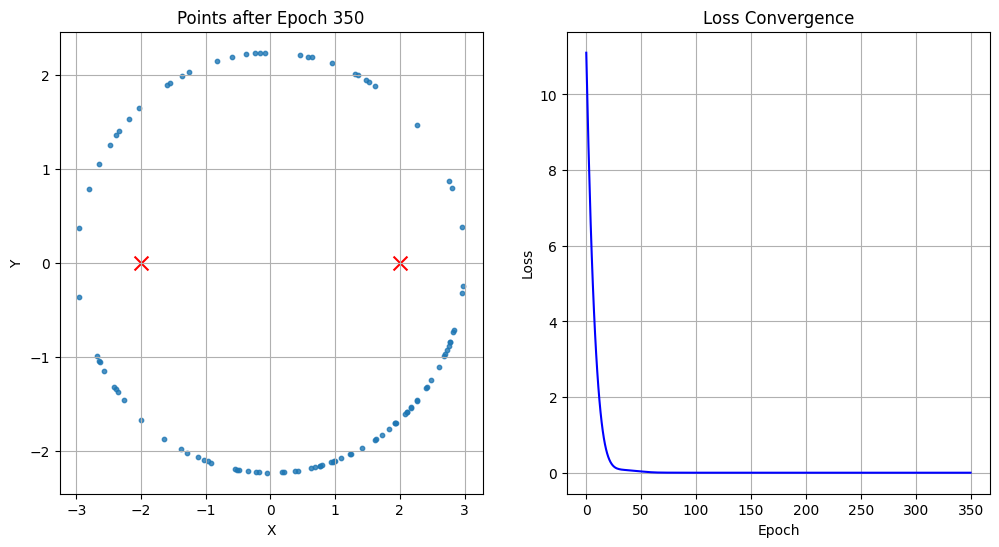

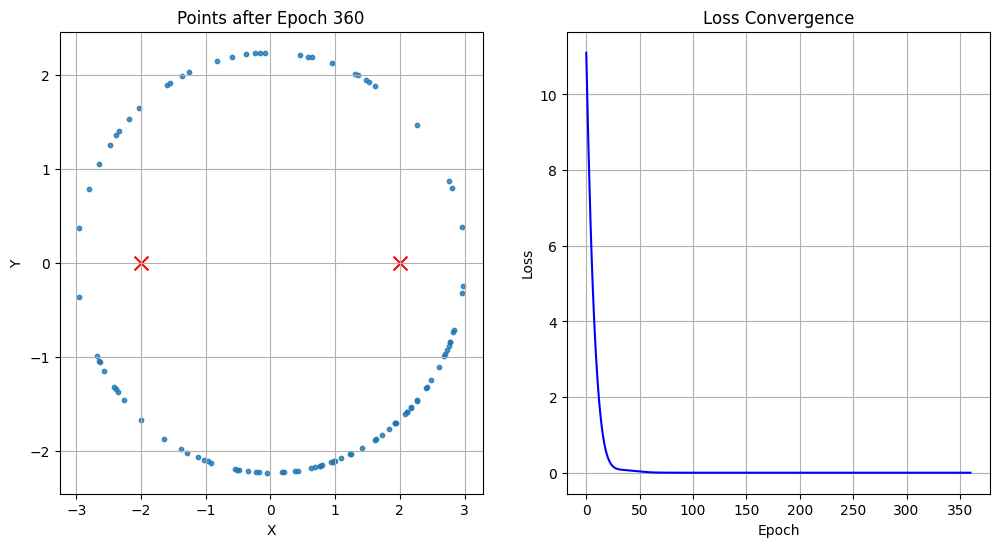

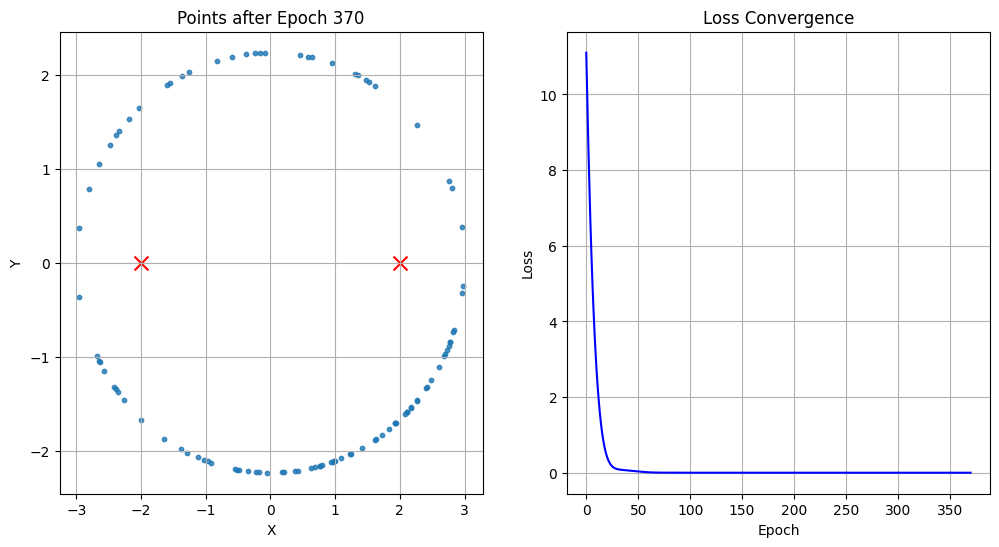

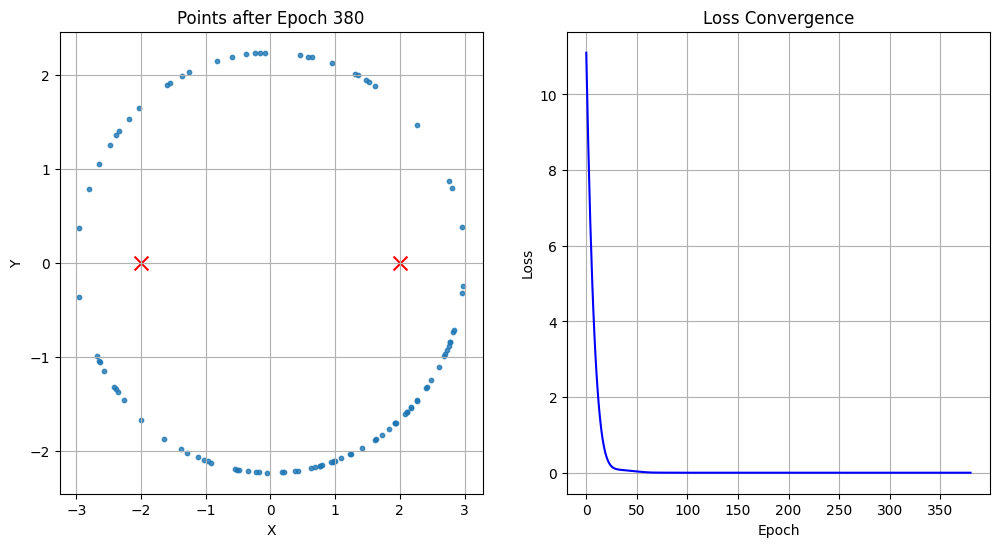

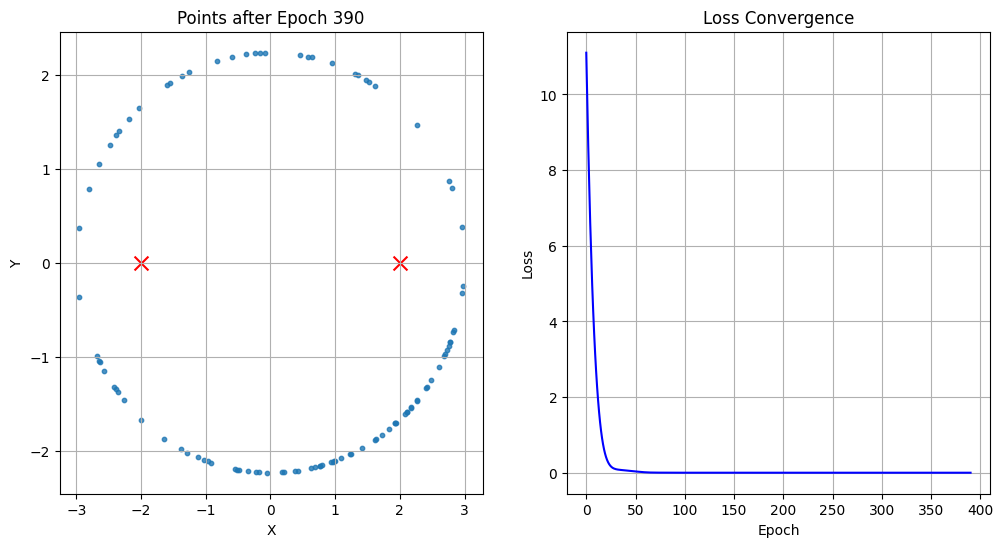

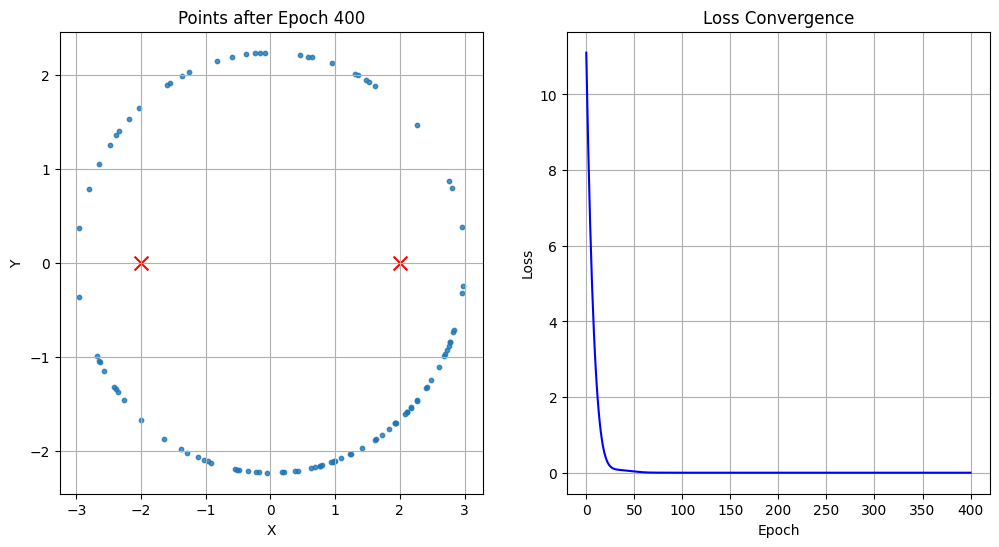

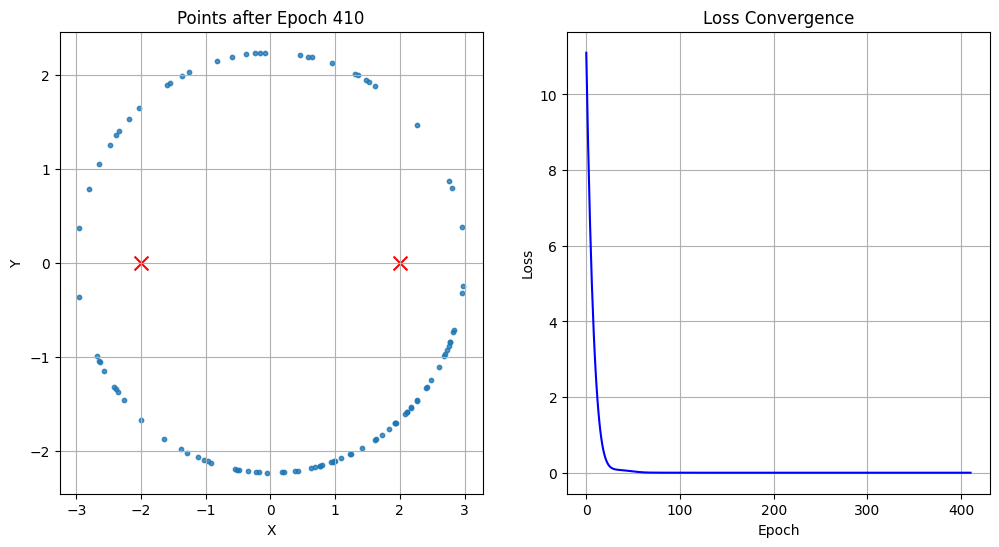

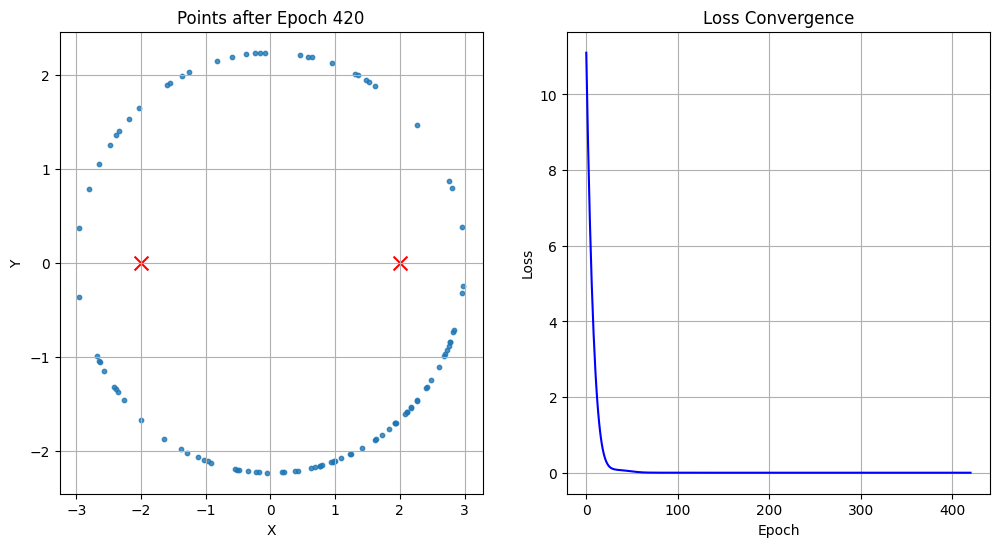

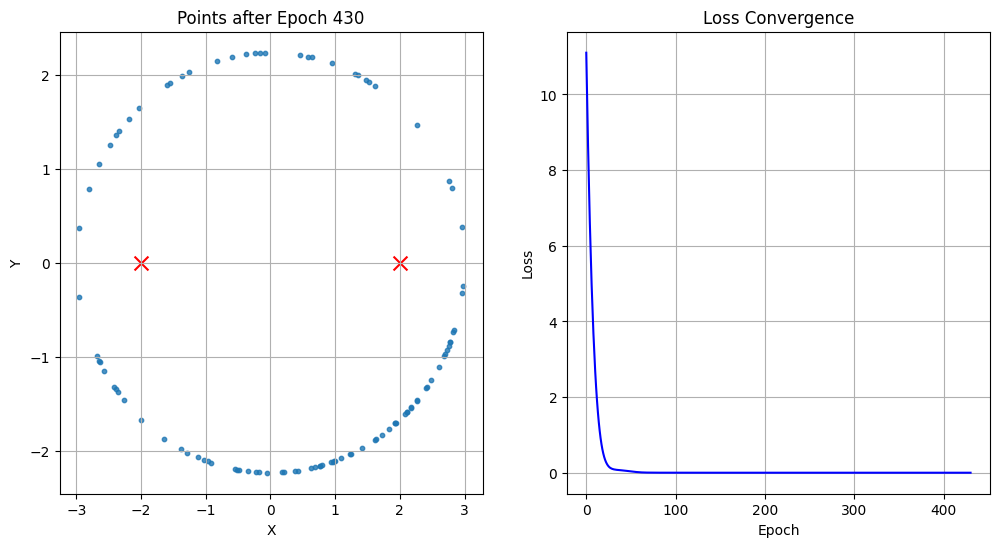

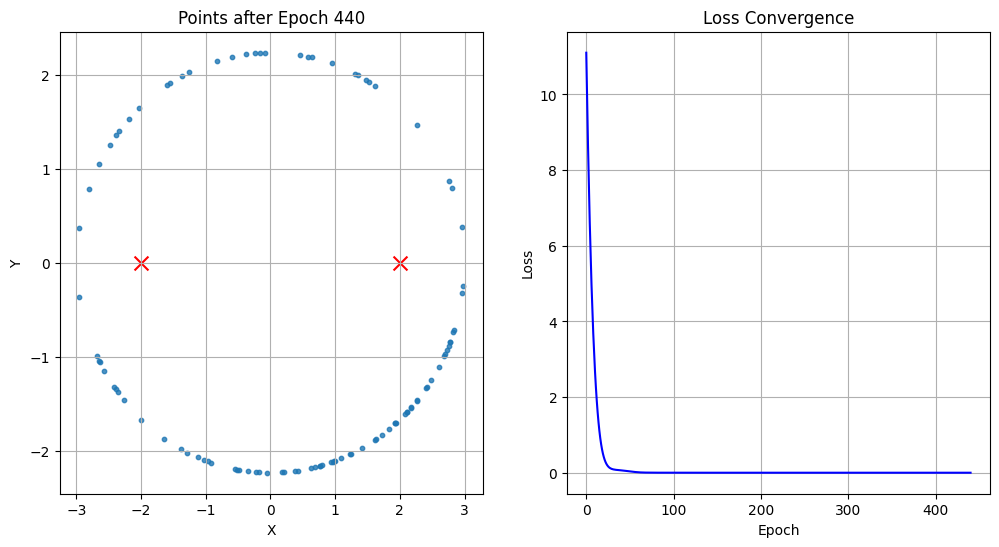

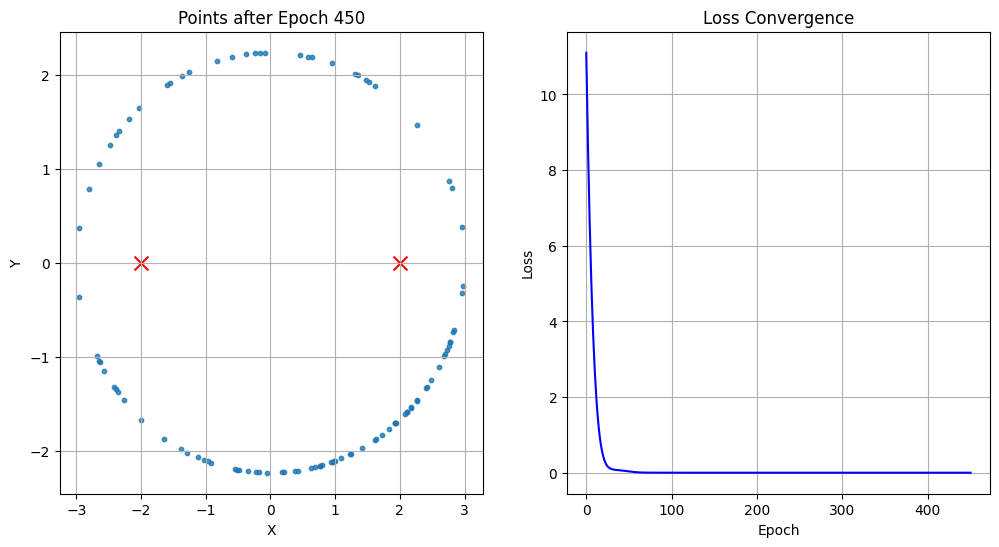

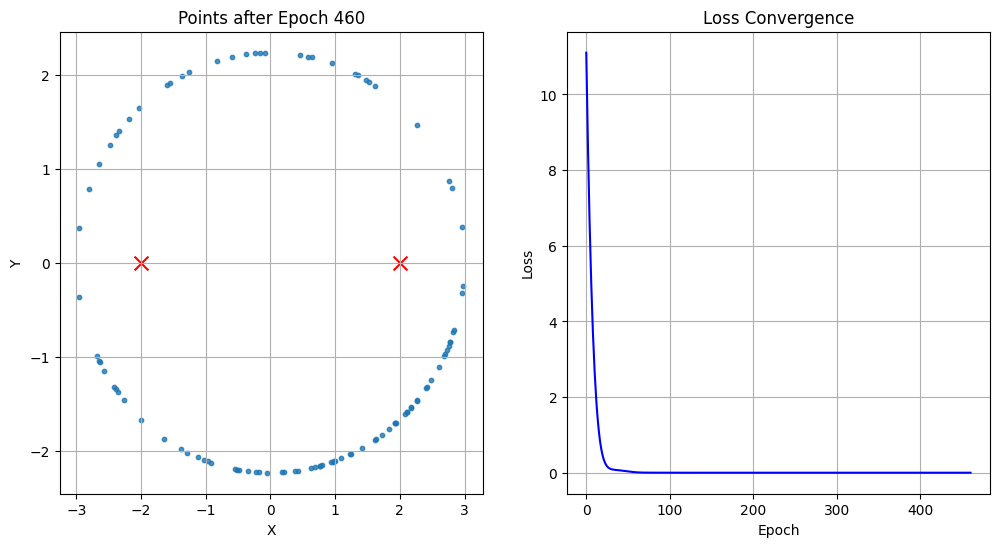

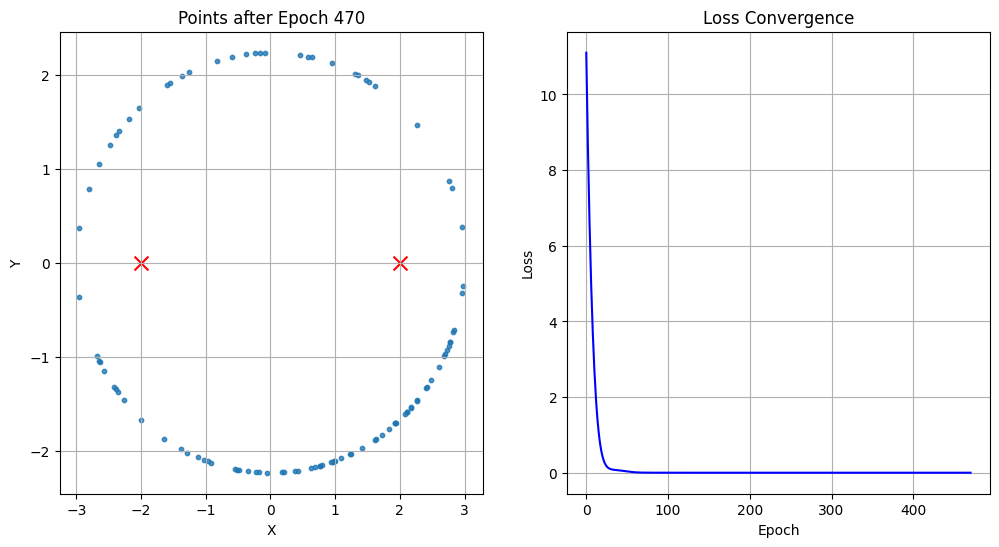

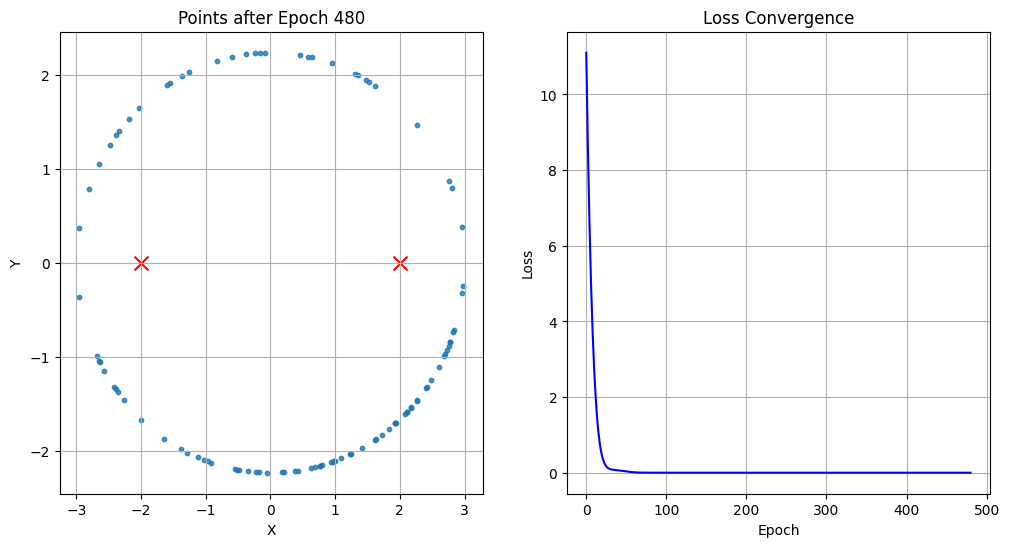

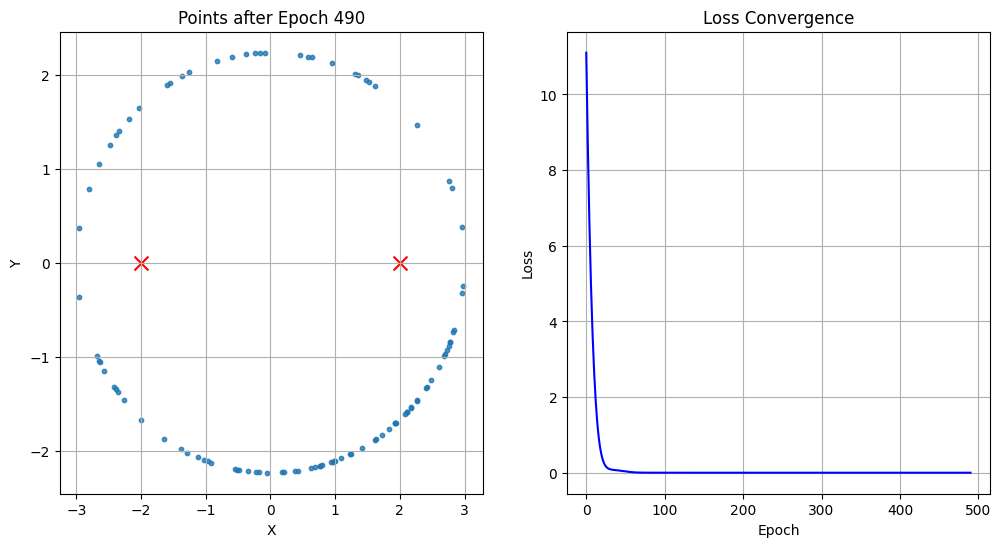

In [60]:
# L2 optimization case
torch.manual_seed(42)  # Ensure reproducibility
points = torch.rand((num_points, 2)) * 10 - 5  # Randomly initialize 2D points in range [-5, 5]
points.requires_grad = True  # Enable gradient tracking

optimizer = torch.optim.Adam([points], lr=0.1)  # Adam optimizer for the points
loss_history = []  # Store loss values over epochs

for epoch in range(500):
    optimizer.zero_grad()  # Reset gradients

    # Compute distances from each point to both foci
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)
    epsilon = dist1 + dist2 - constant_sum  # Deviation from ellipse condition

    # L2 loss: mean squared deviation
    loss = torch.mean(epsilon ** 2)

    loss.backward()  # Compute gradients
    optimizer.step()  # Update point positions
    loss_history.append(loss.item())  # Save current loss

    # Plot every 10 epochs
    if epoch % 10 == 0:
        plot_results(epoch, points, focus1, focus2, loss_history)


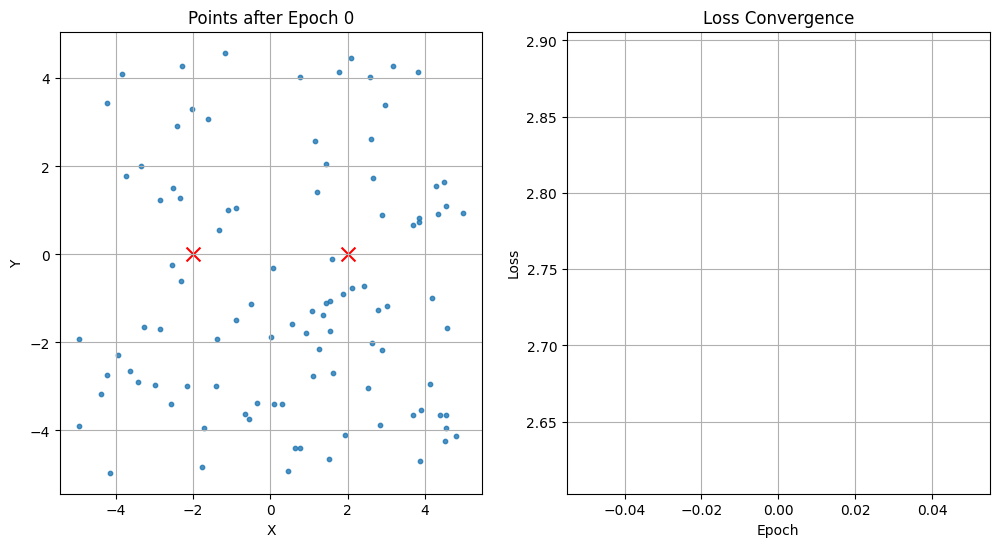

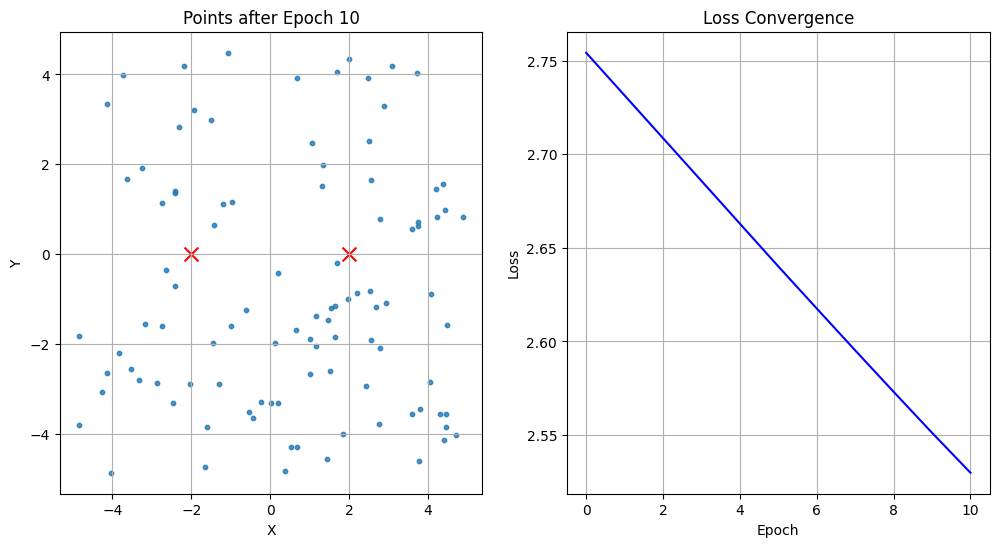

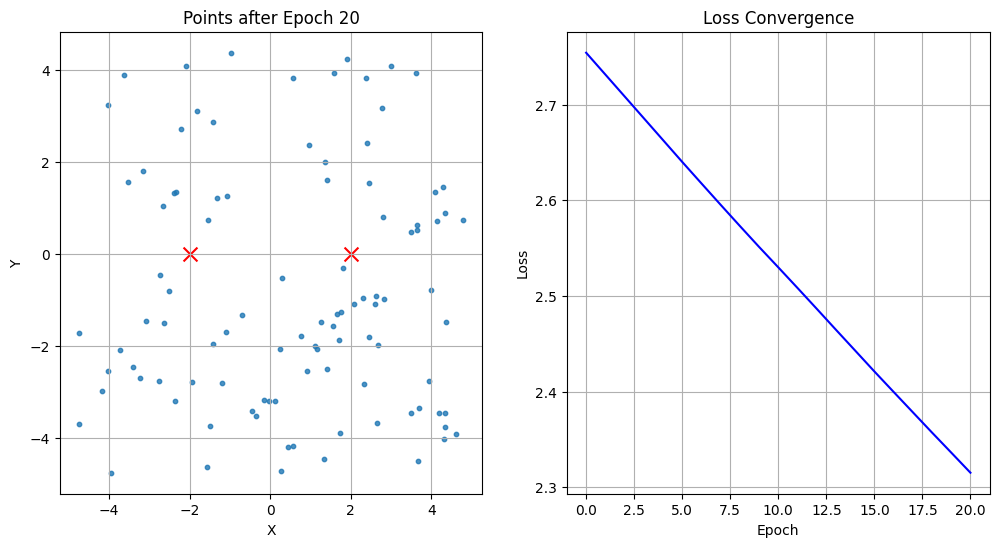

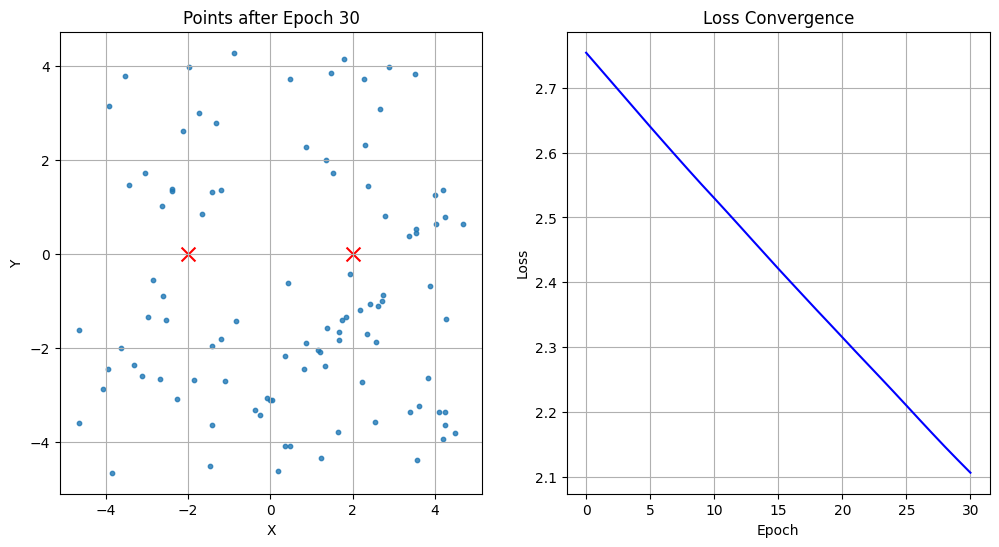

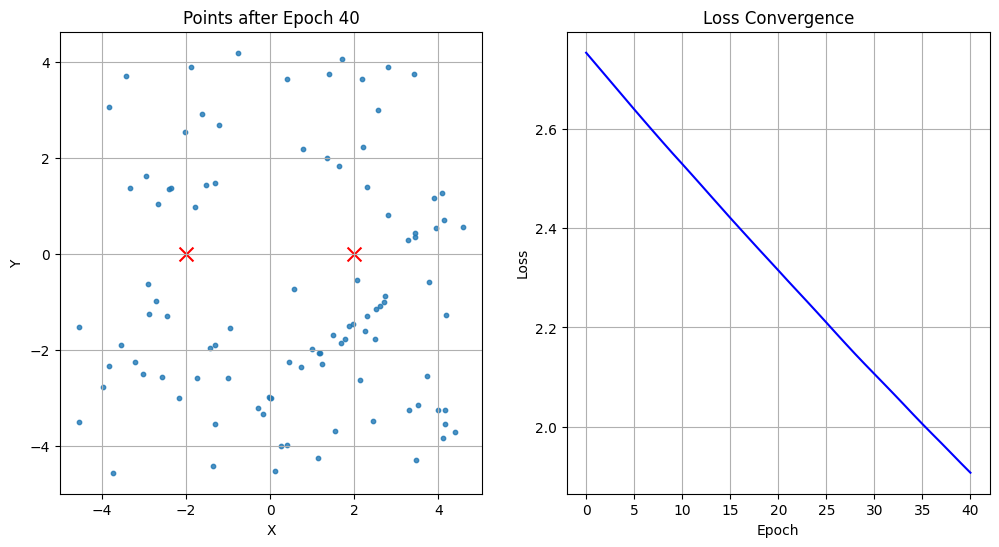

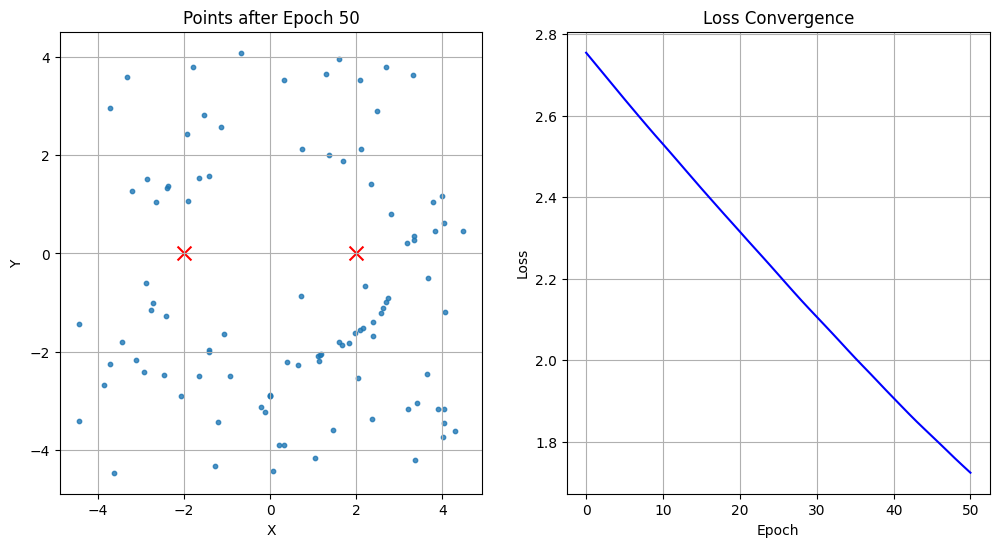

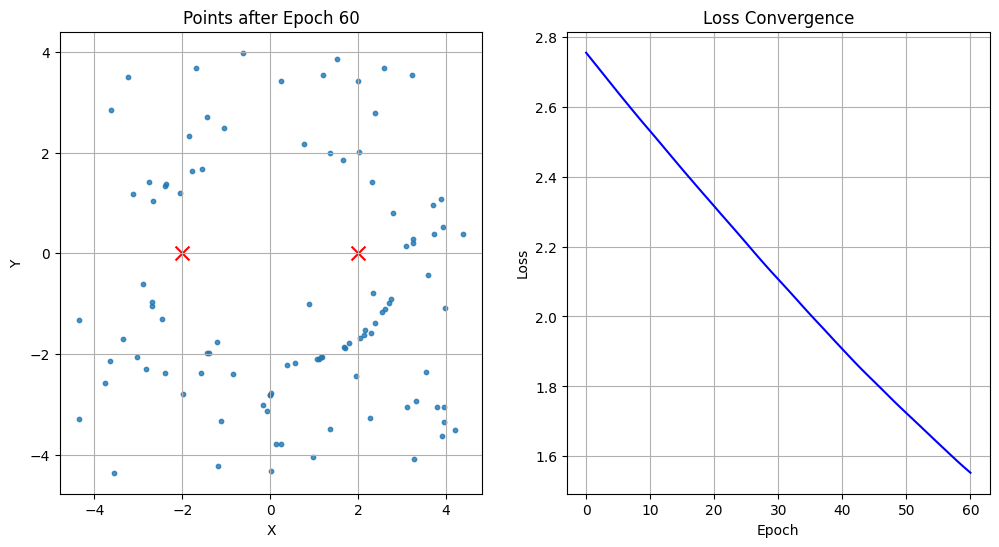

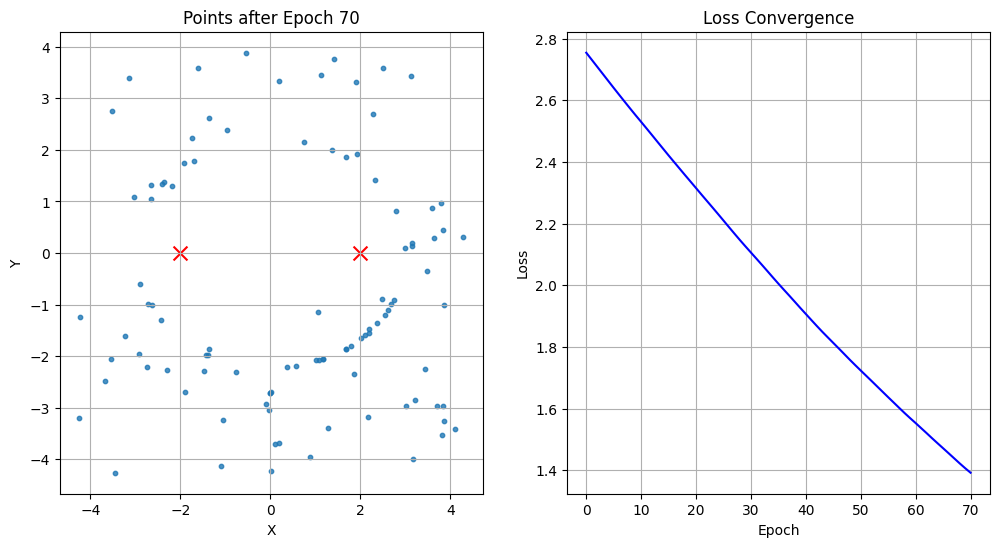

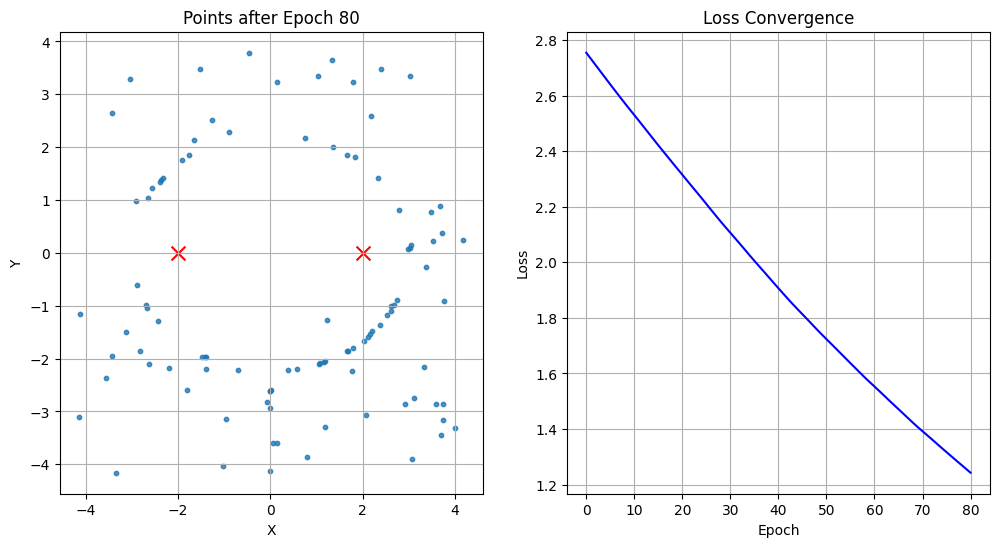

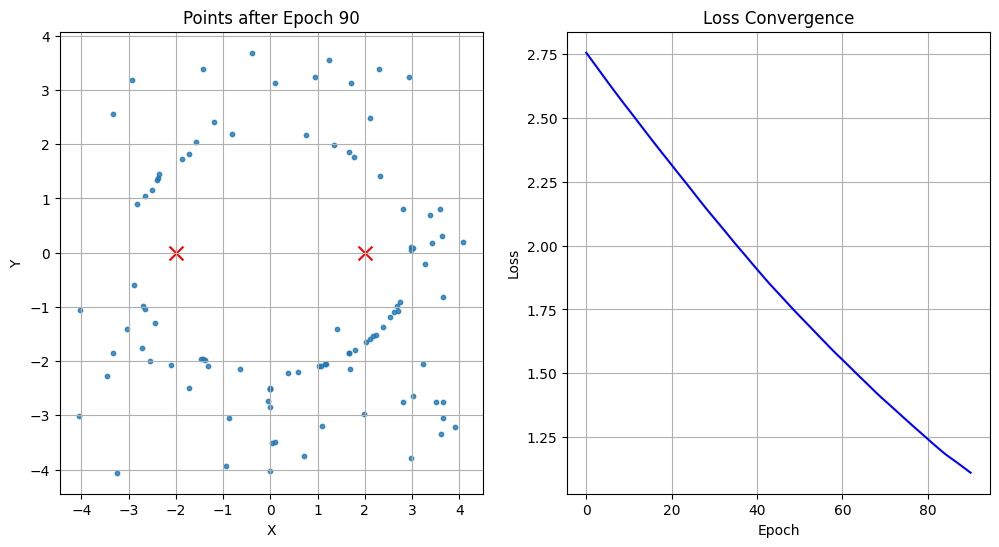

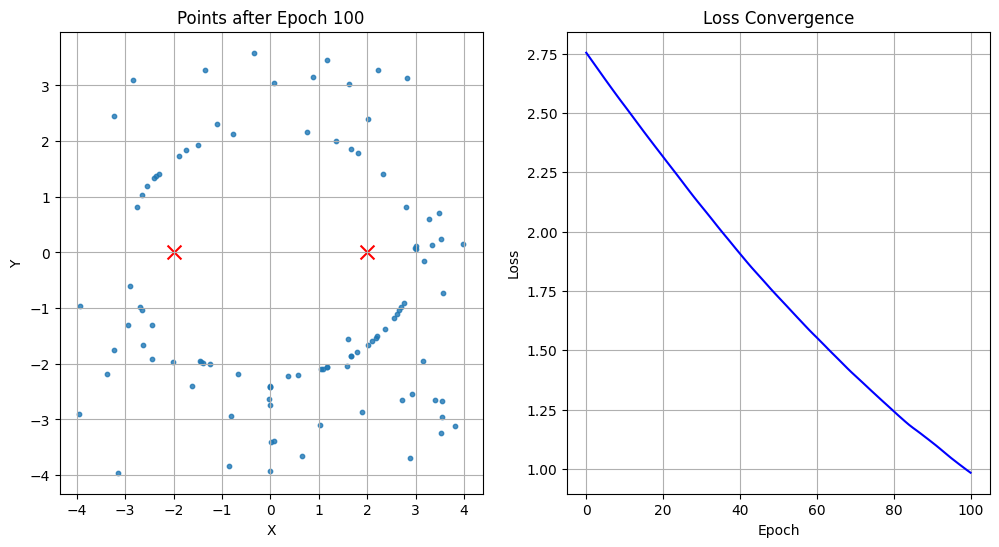

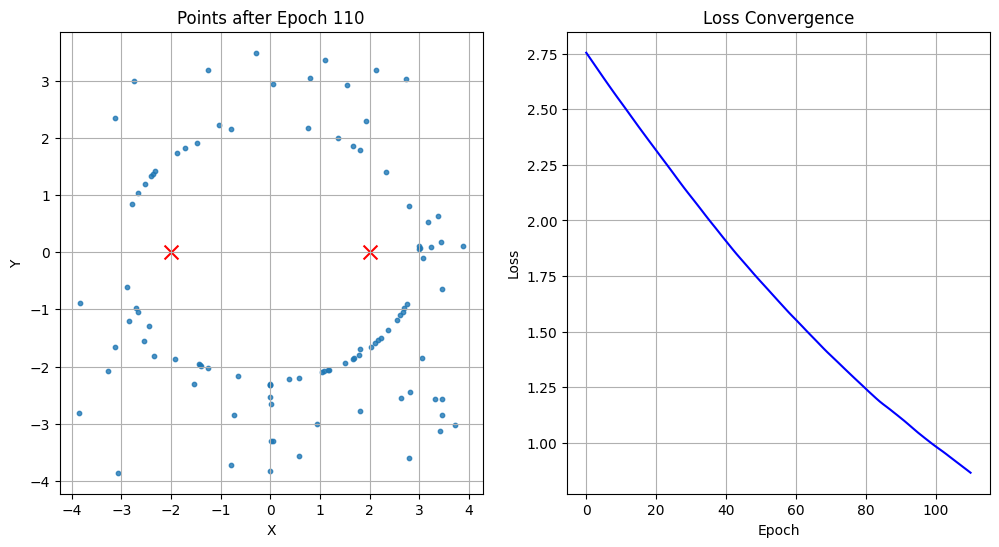

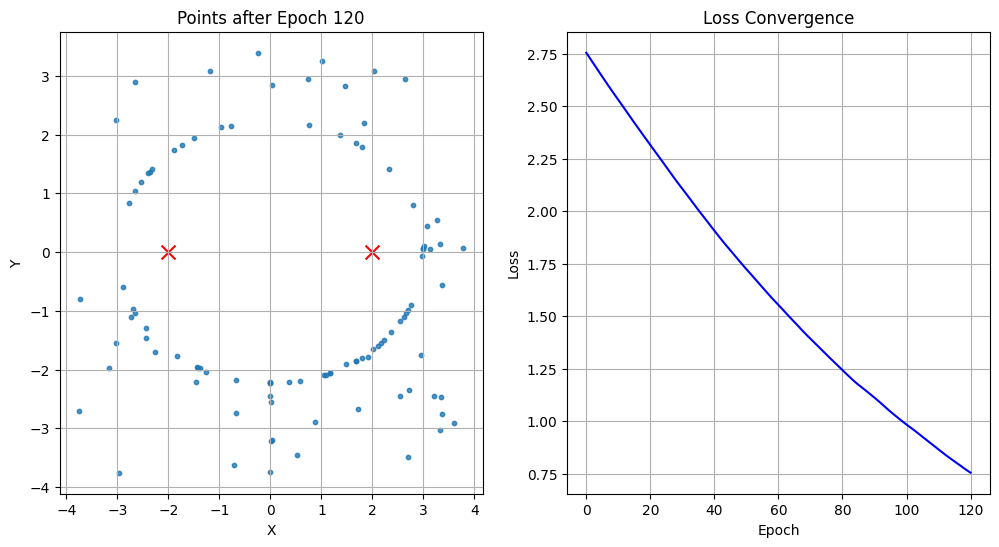

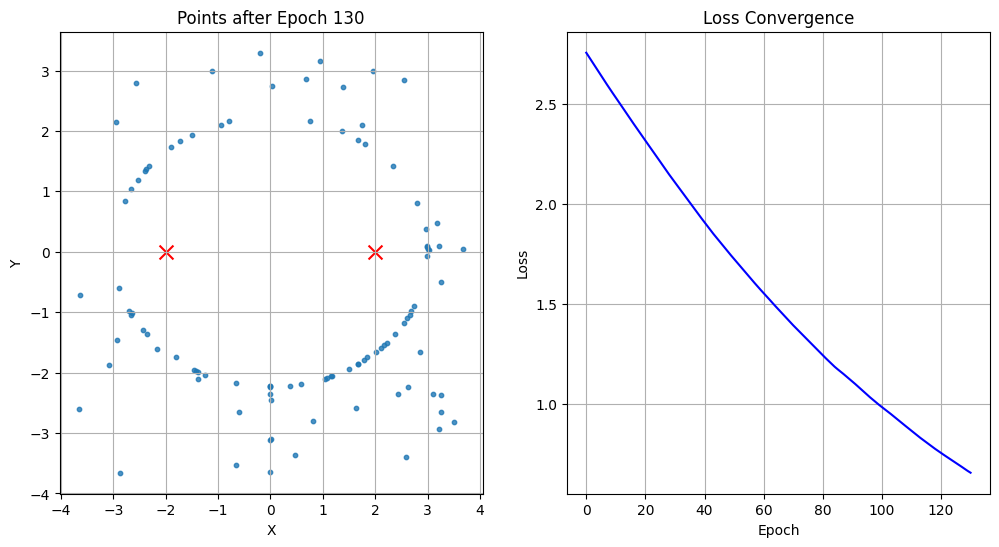

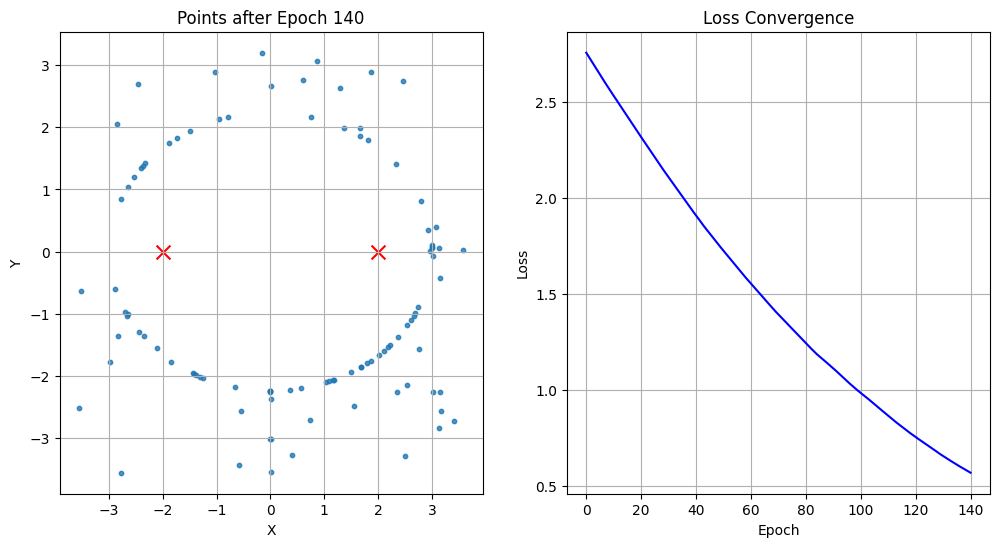

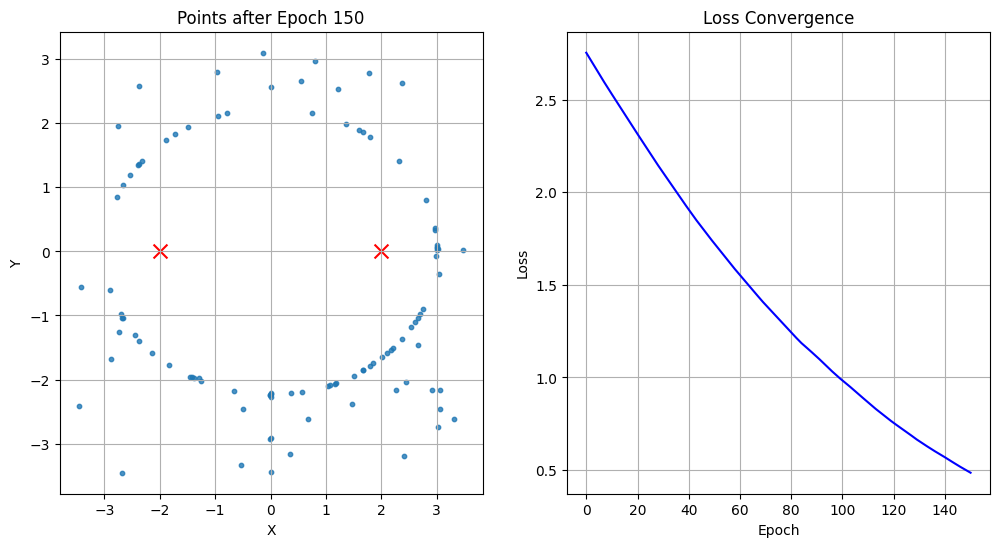

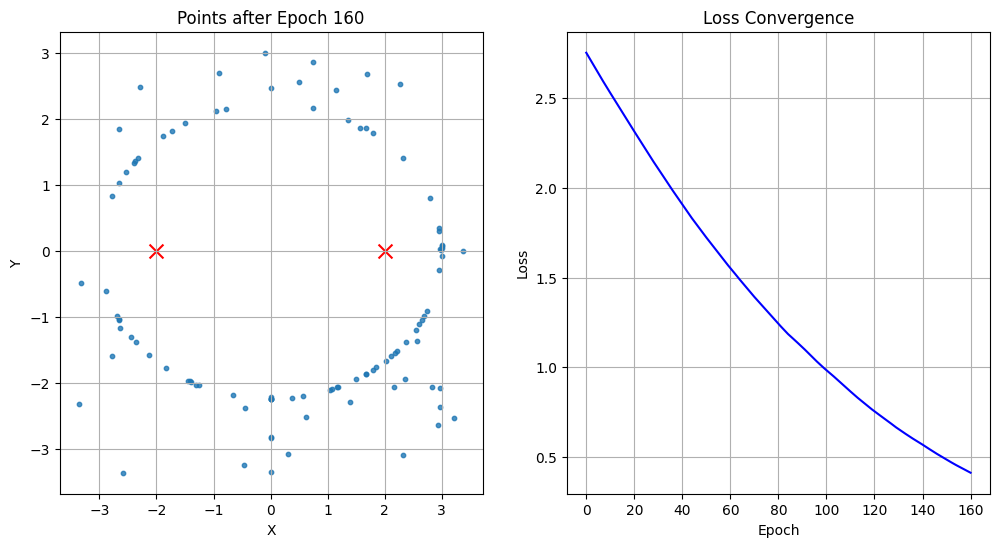

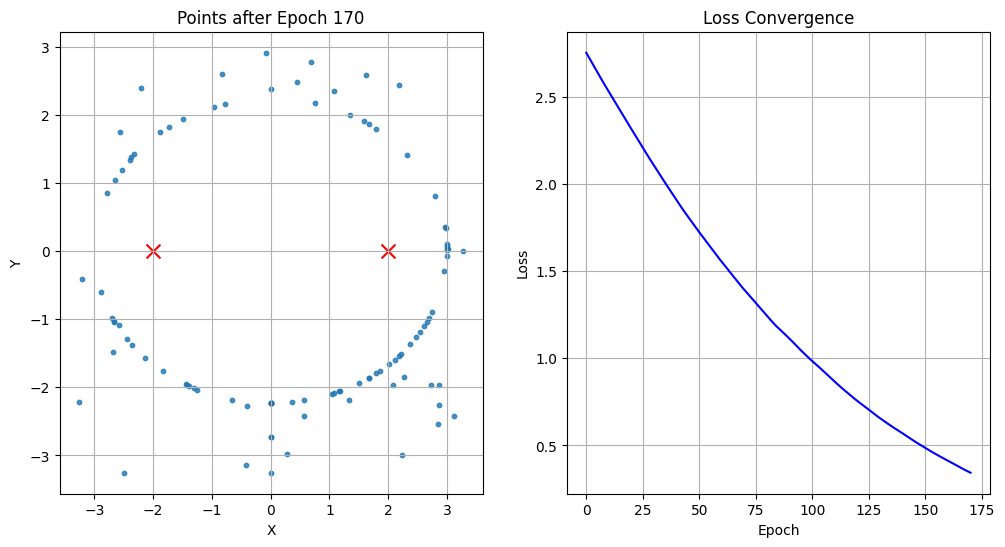

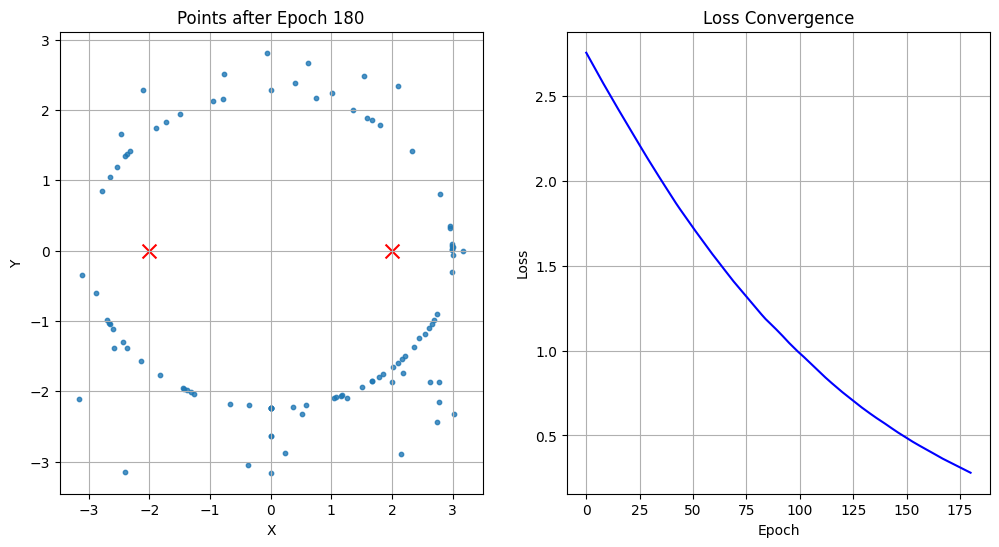

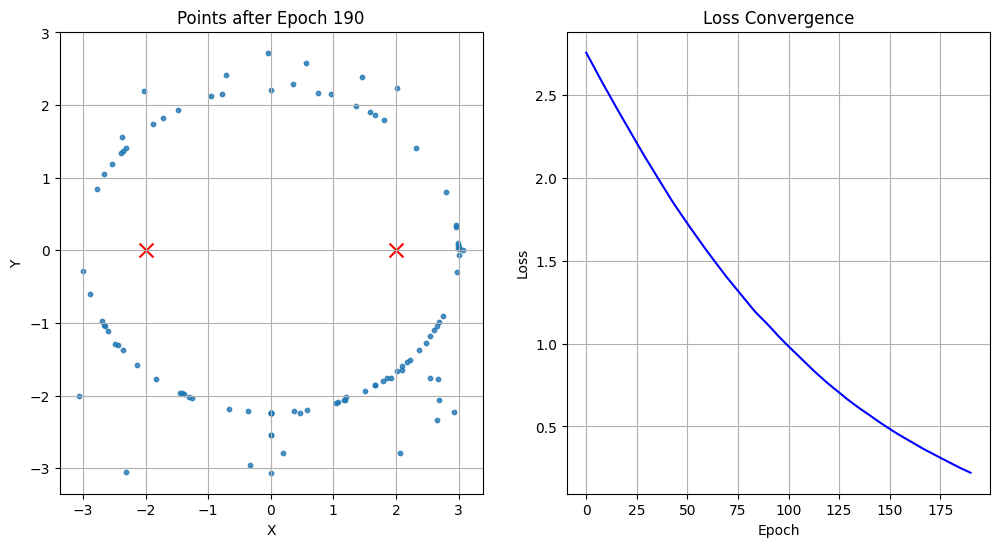

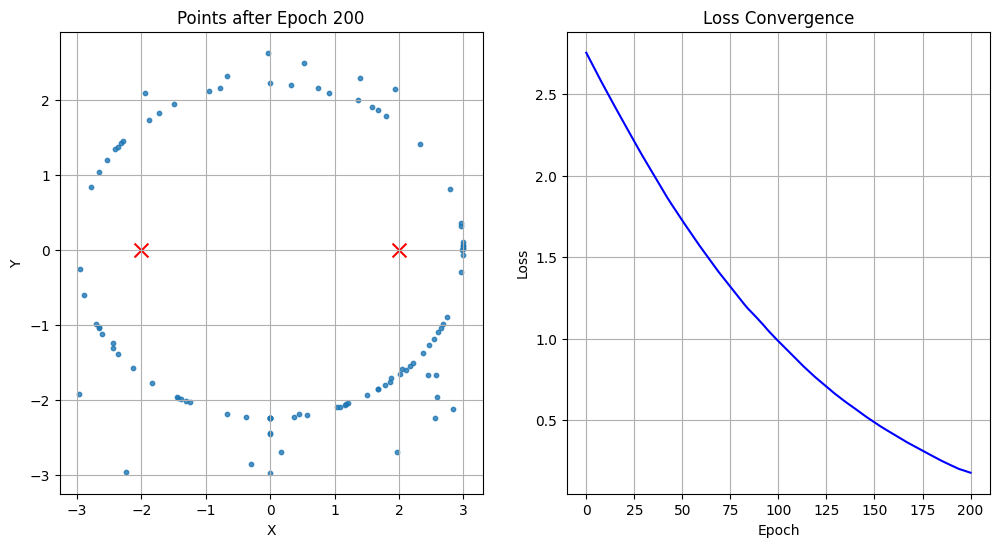

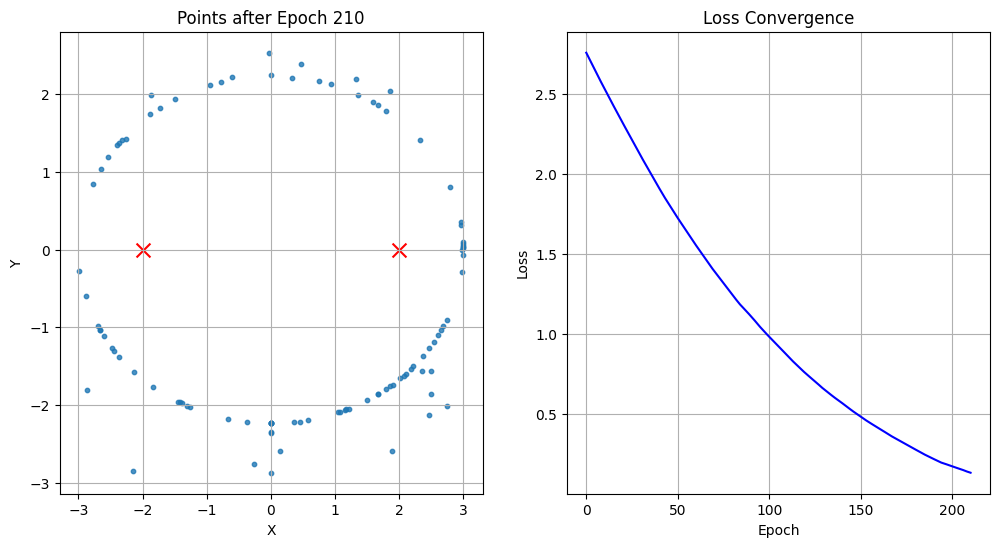

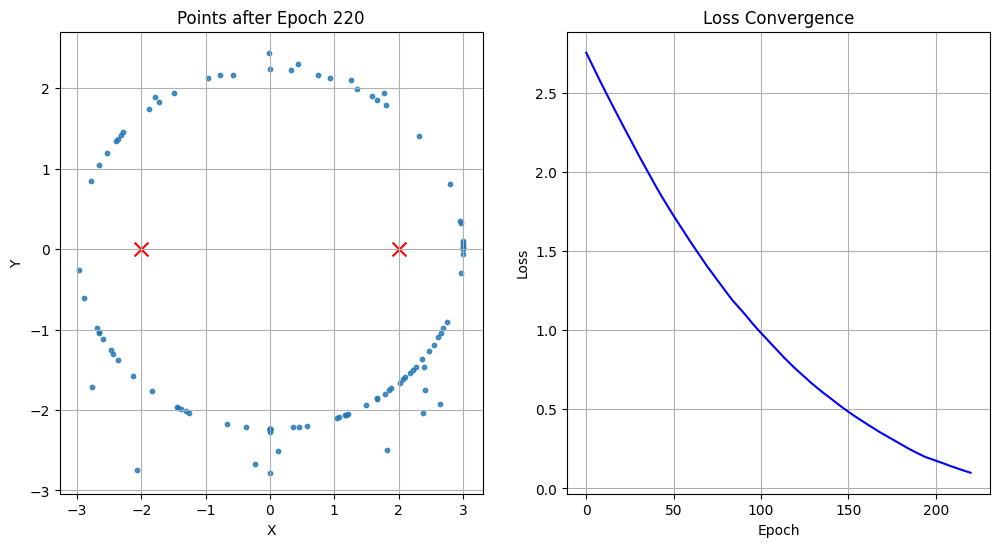

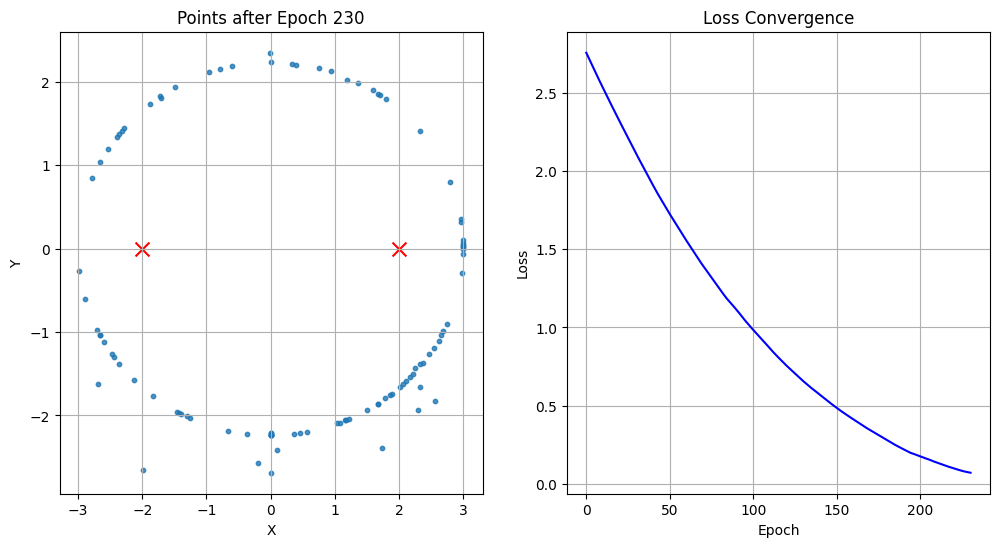

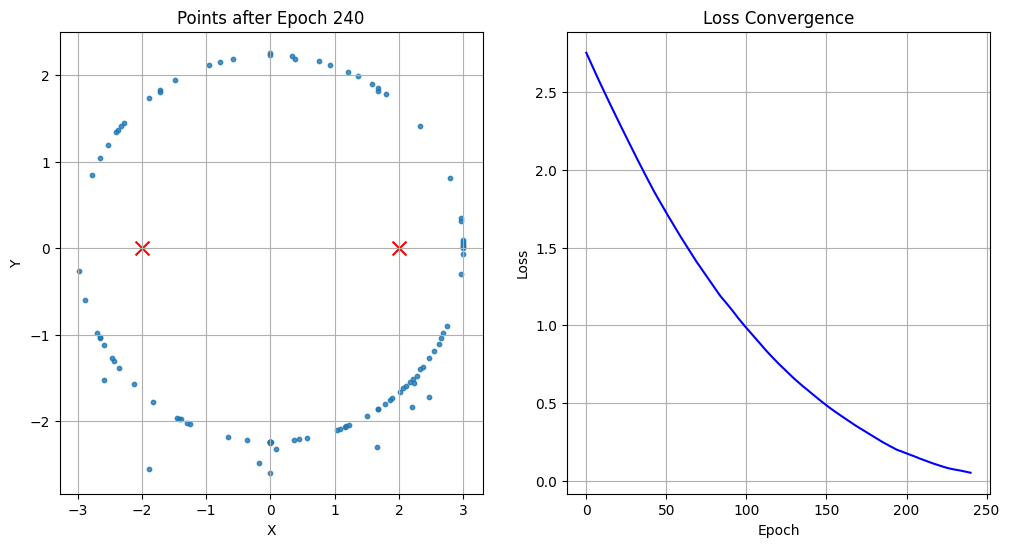

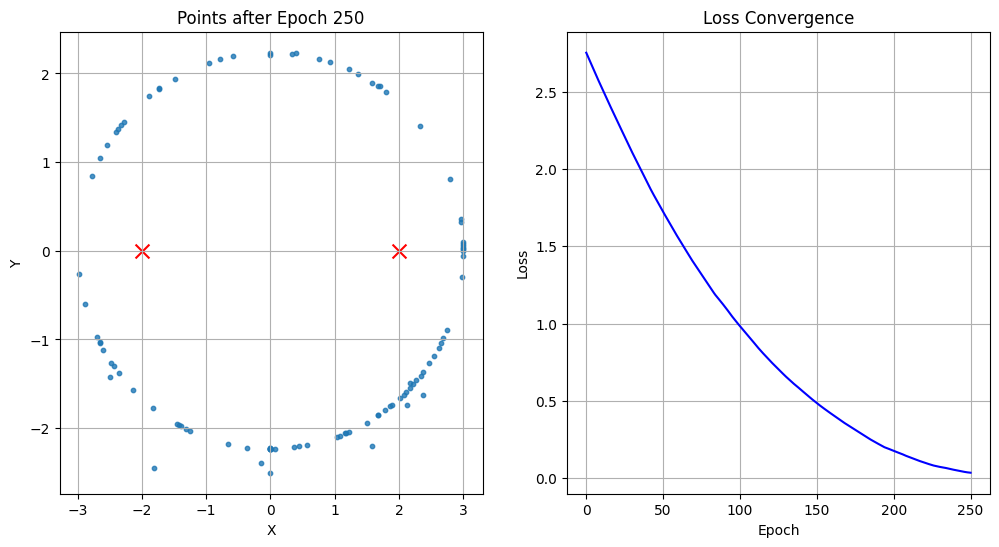

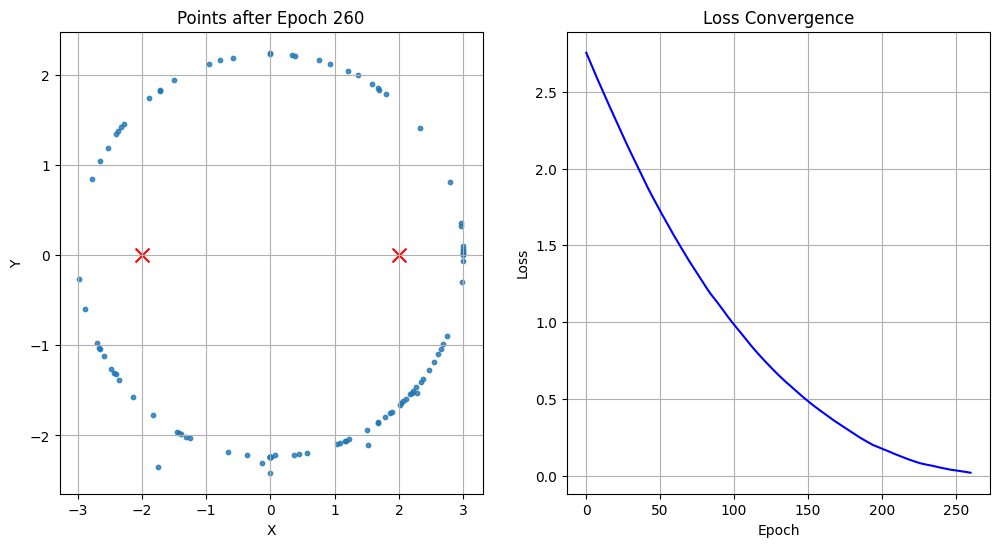

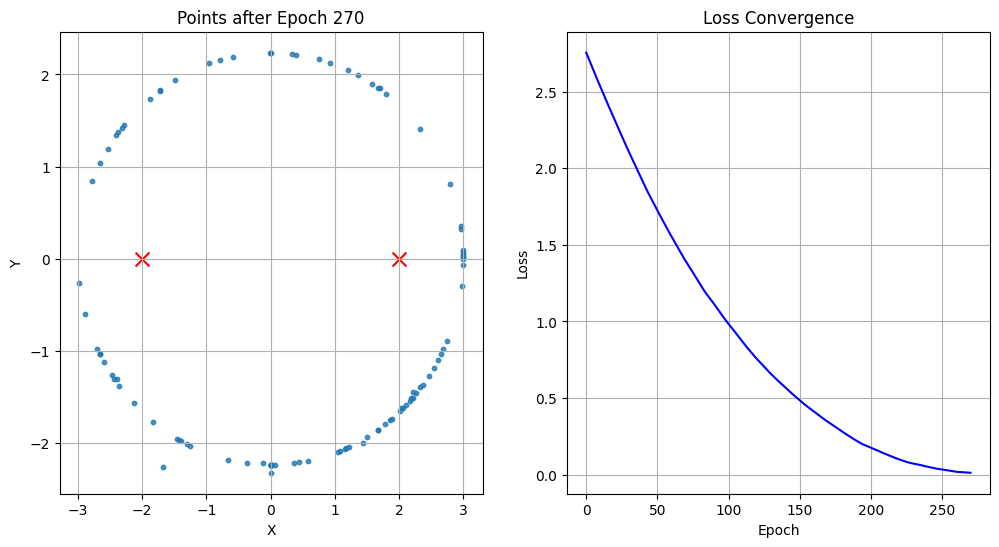

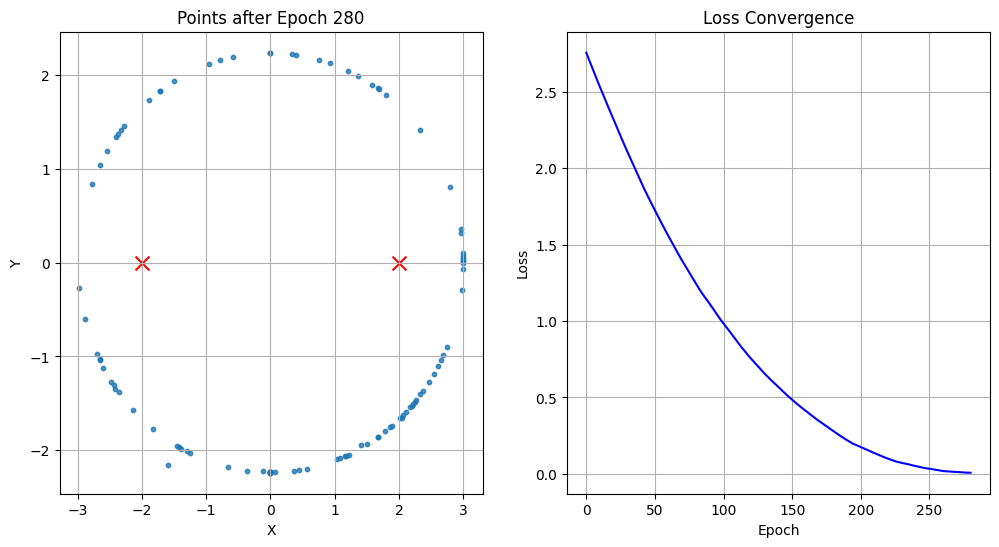

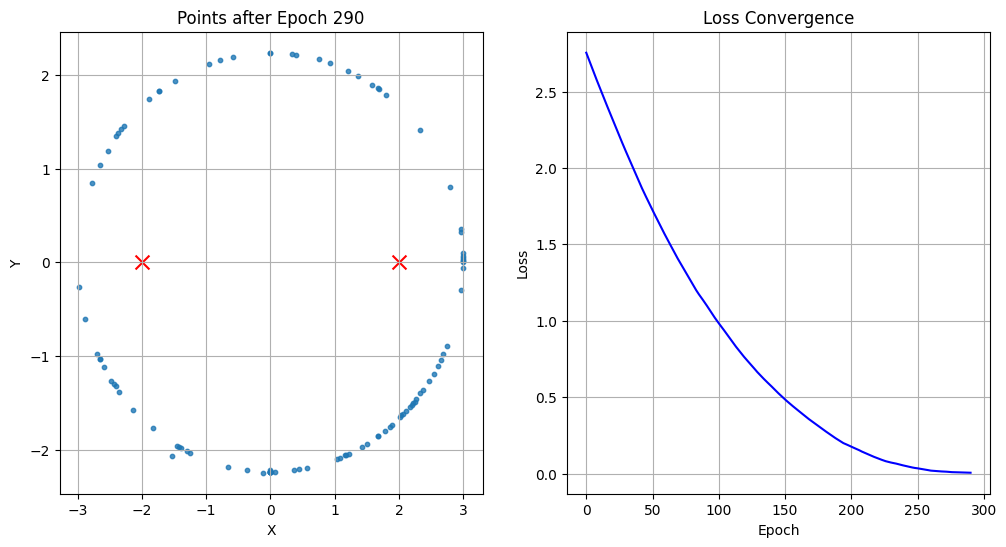

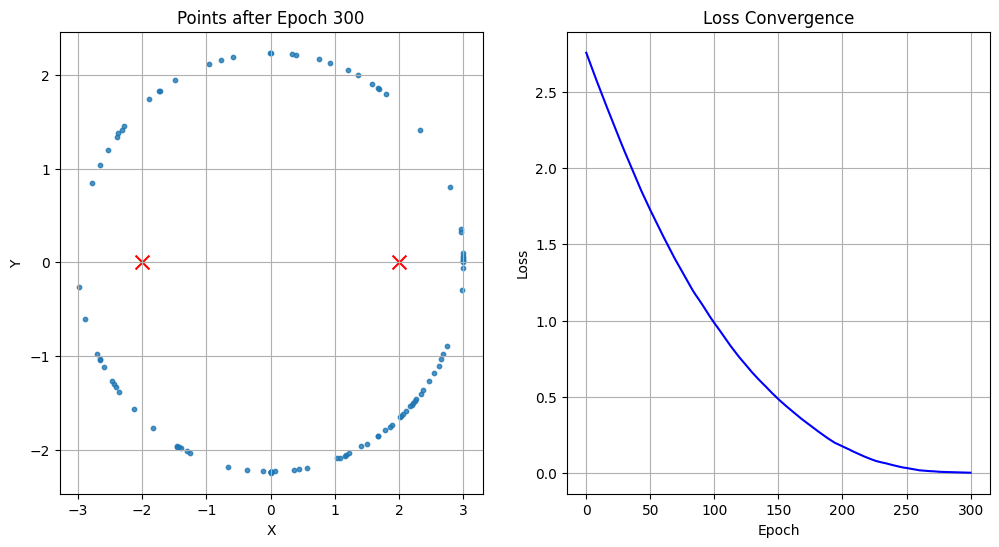

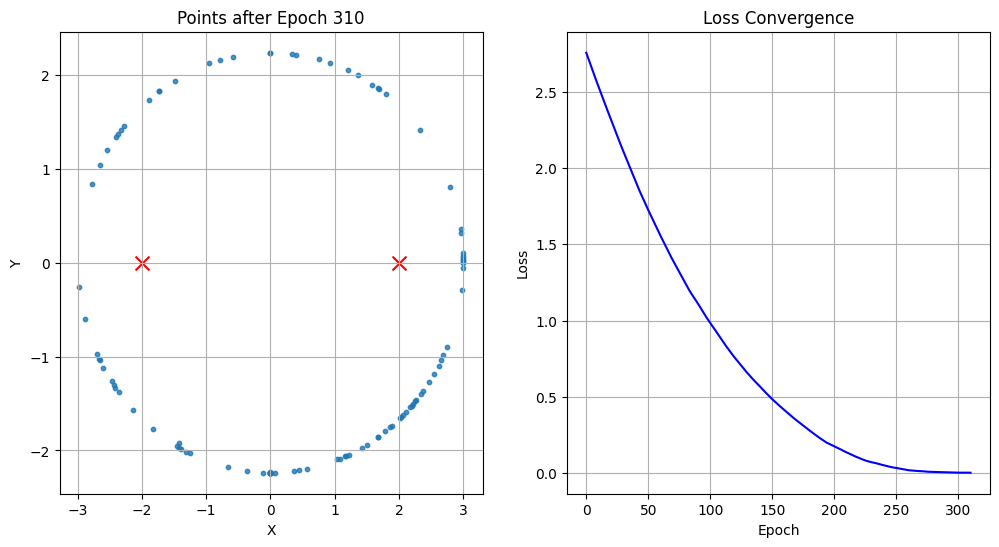

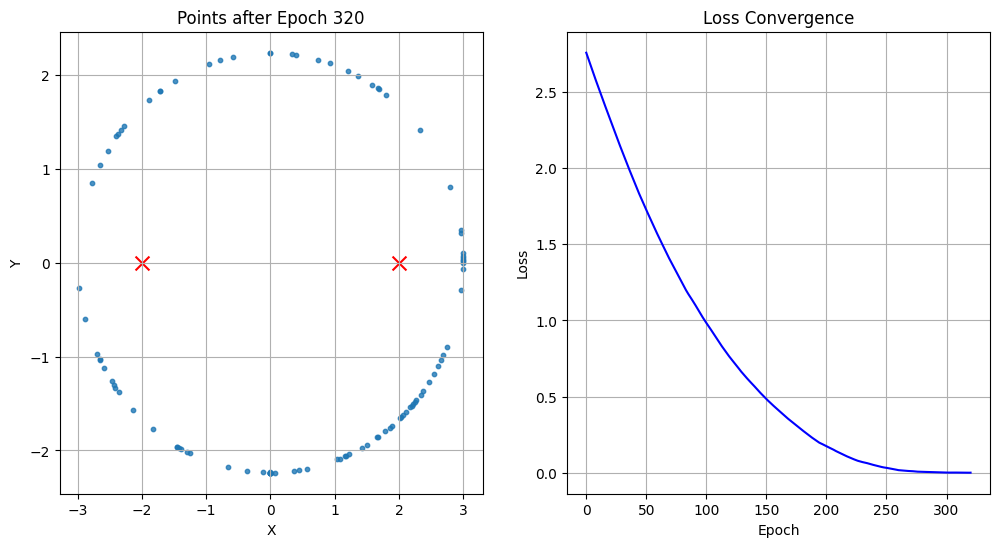

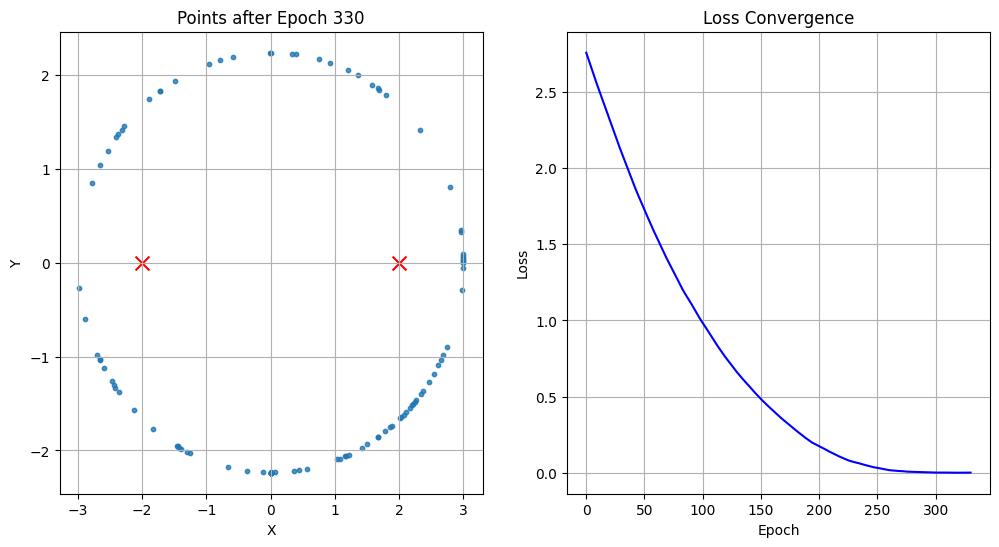

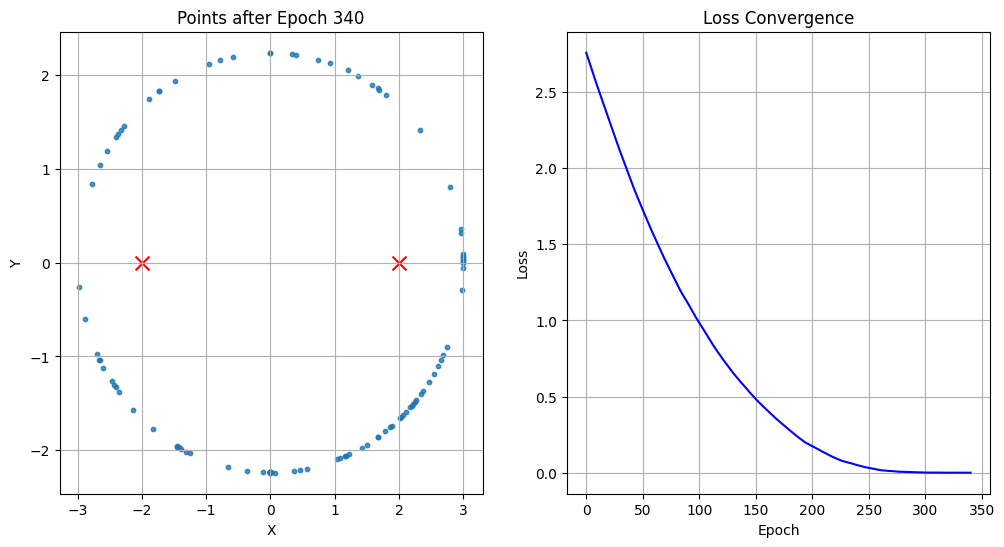

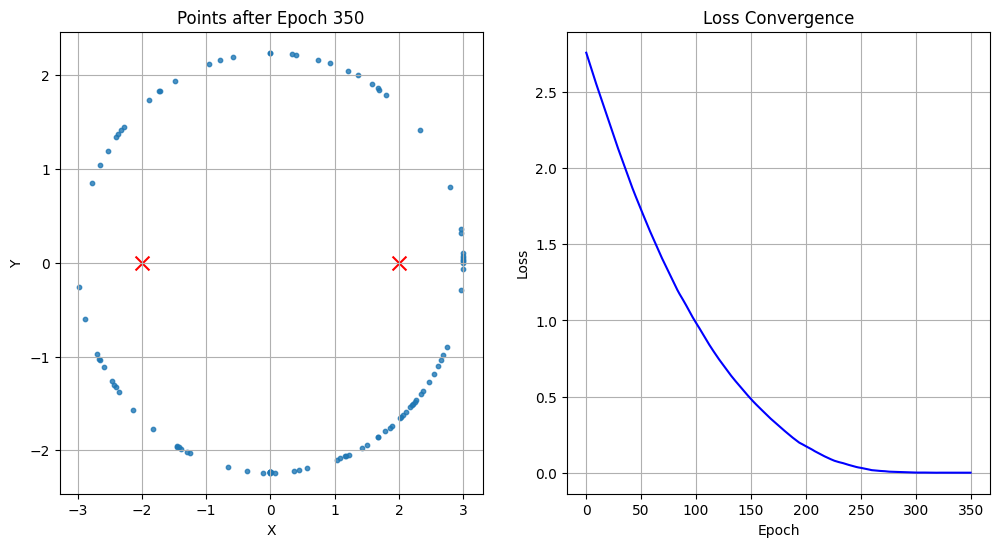

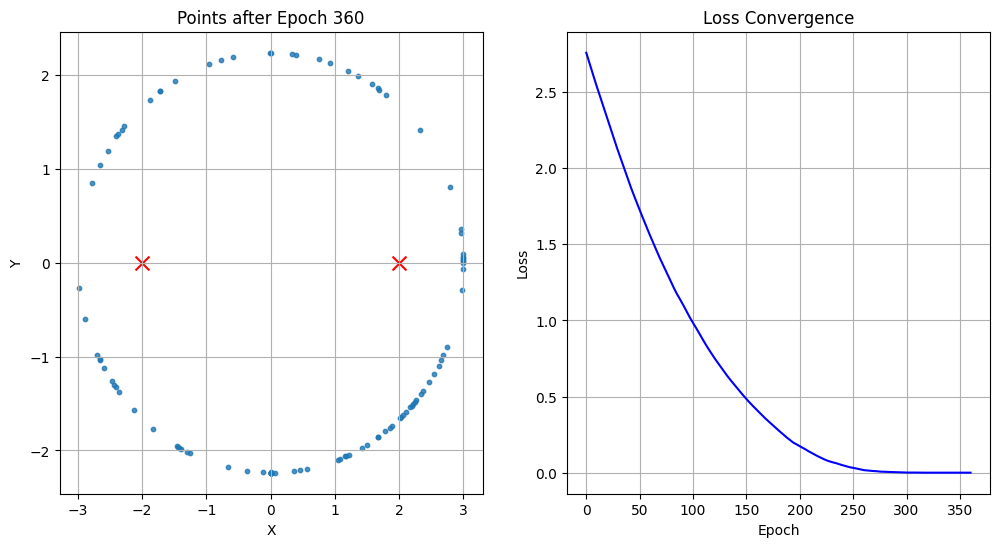

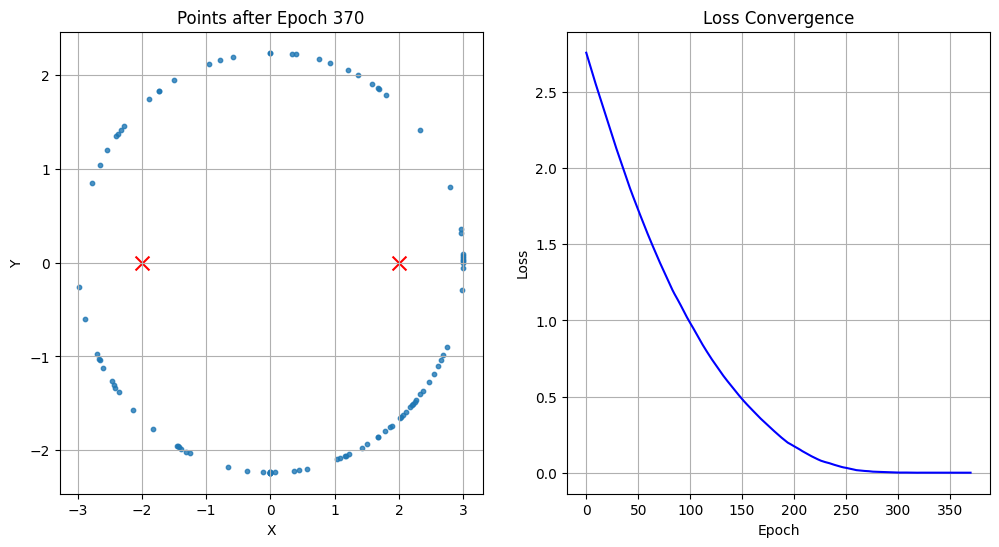

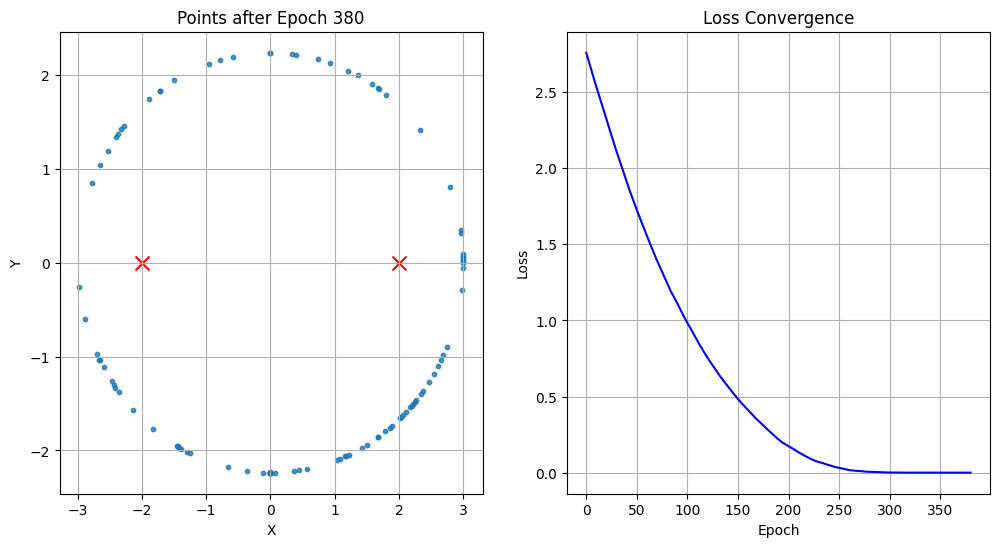

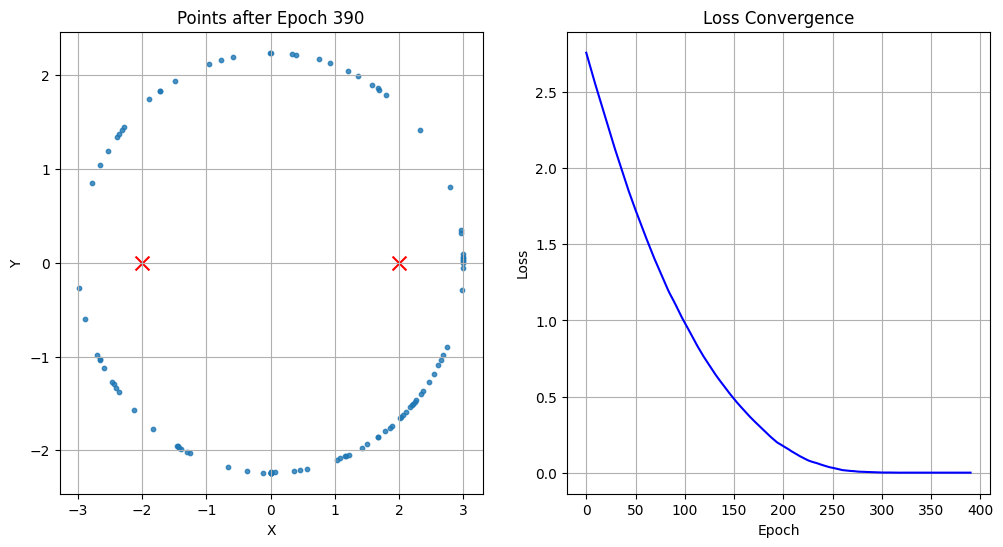

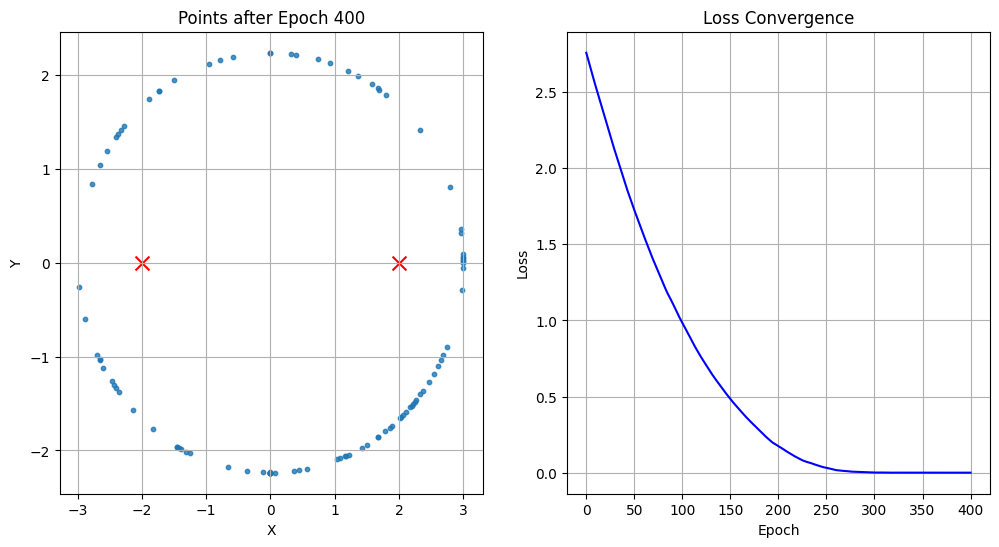

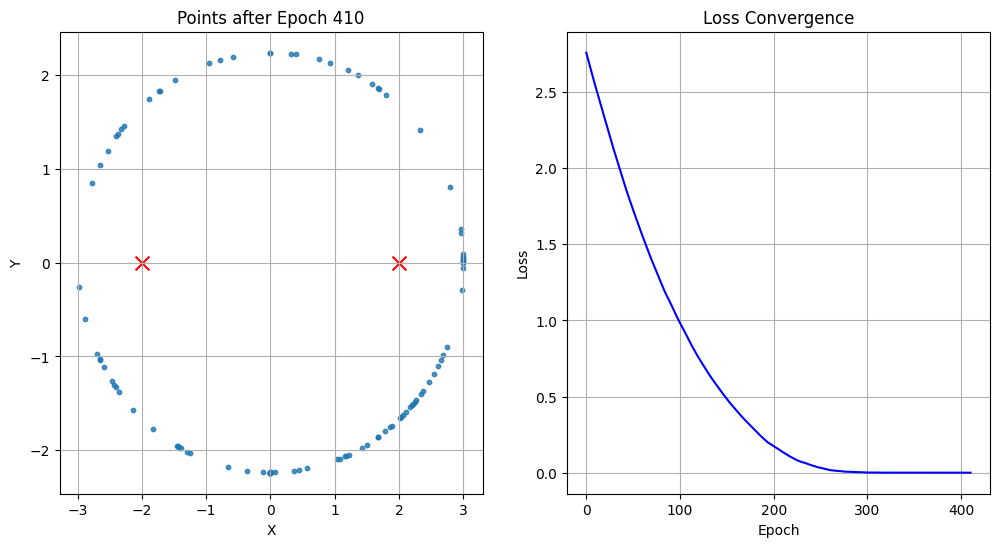

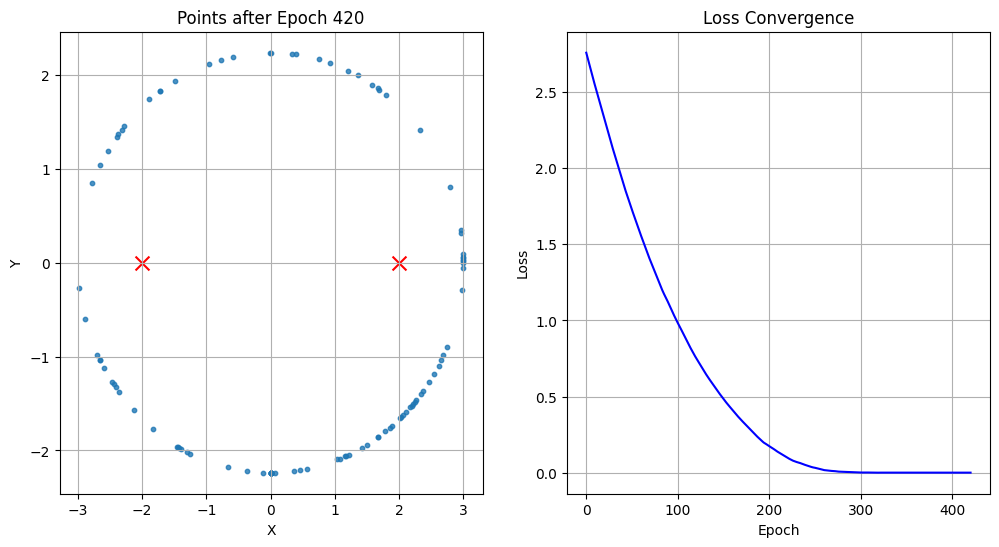

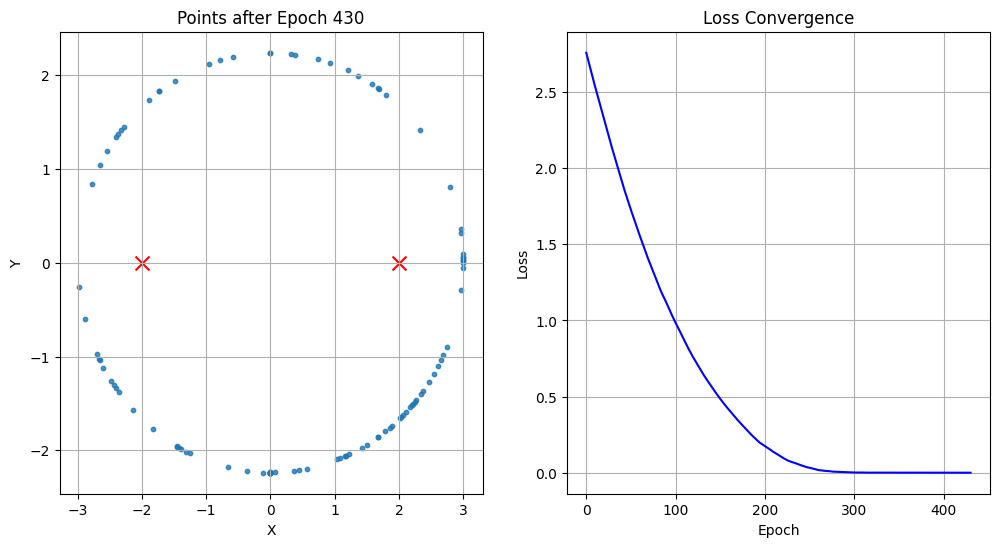

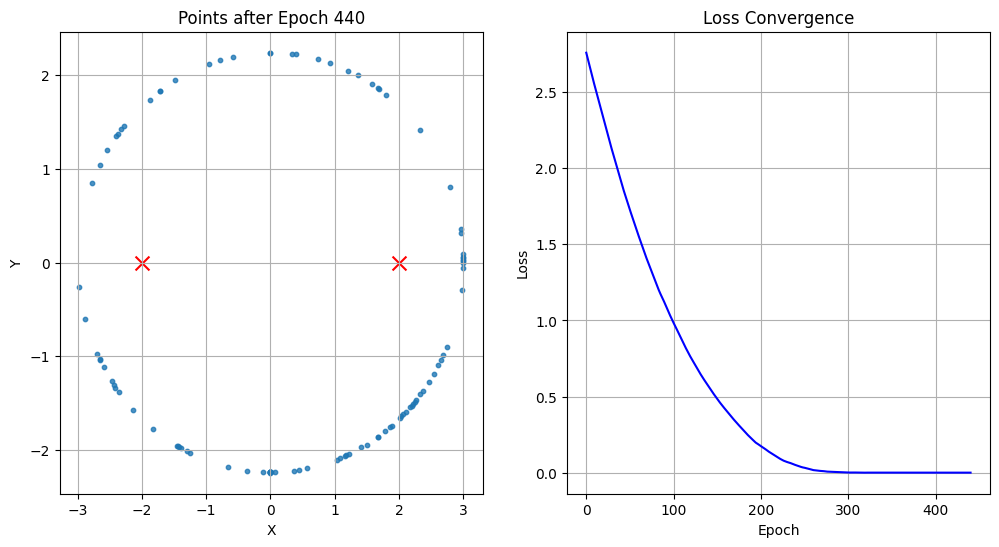

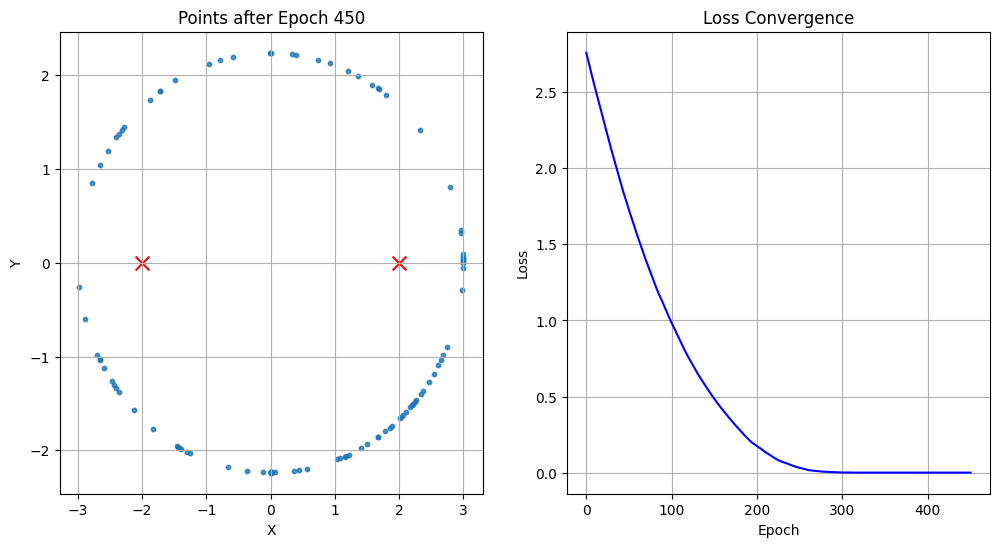

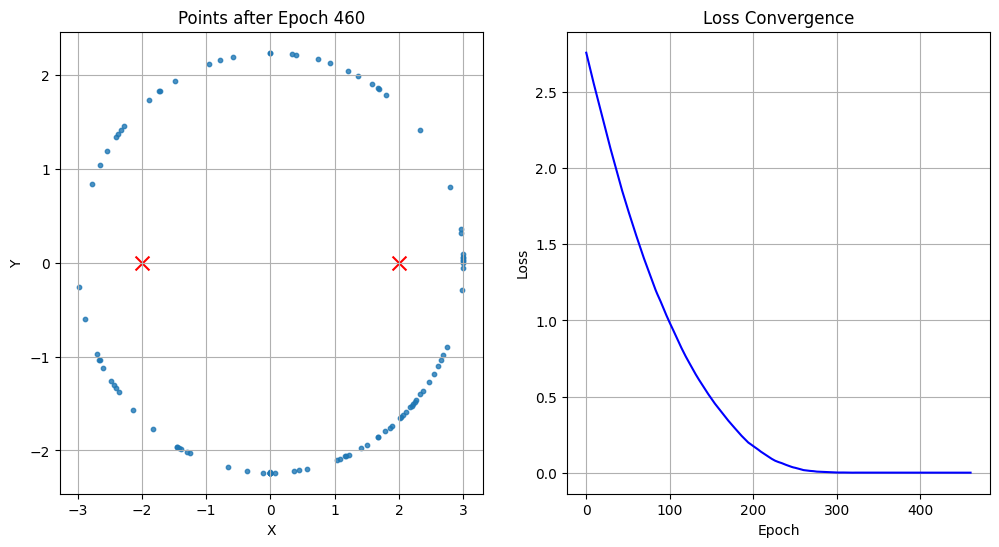

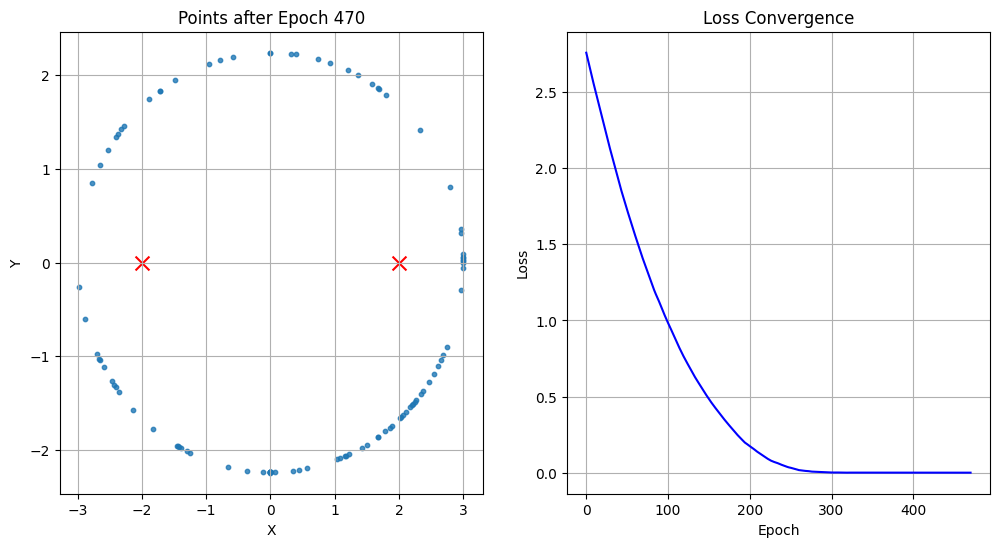

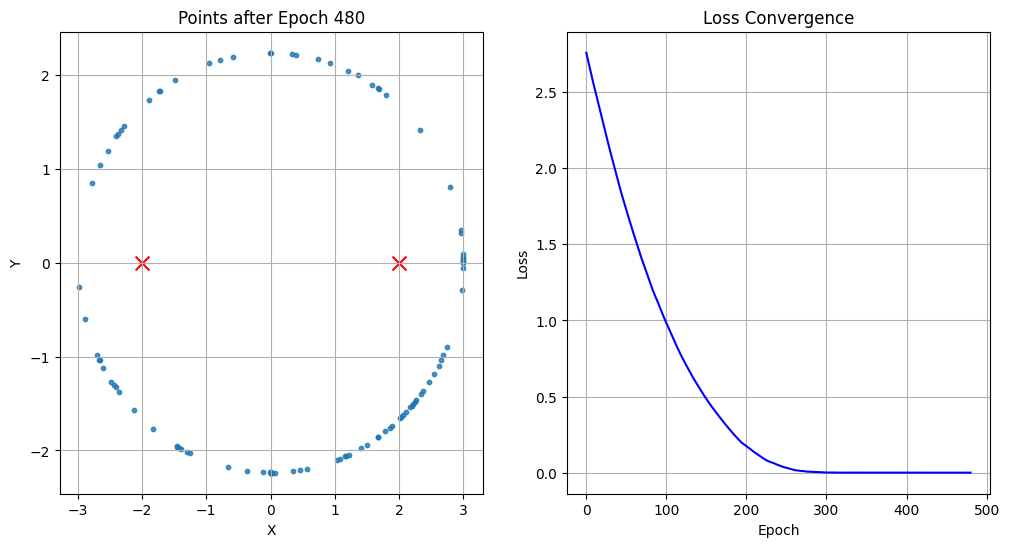

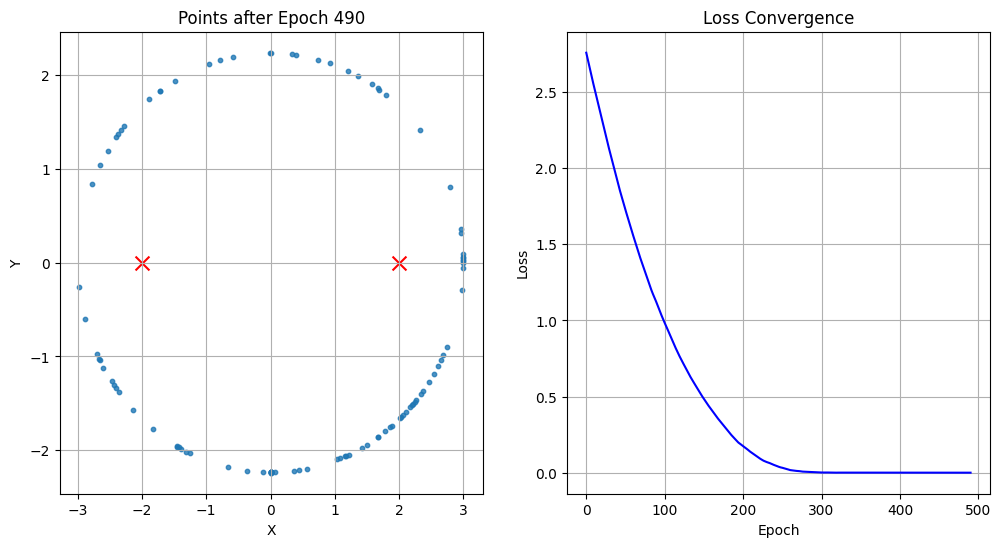

In [61]:
# L1 optimization case
# - Problem: Lack of full convergence
# - Cause: Constant gradient magnitude leads to oscillations

# Reset point positions
torch.manual_seed(42)
points = torch.rand((num_points, 2)) * 10 - 5  # Random 2D points in [-5, 5]
points.requires_grad = True  # Enable gradient computation

# Use smaller learning rate for better stability
optimizer = torch.optim.Adam([points], lr=0.01)
loss_history = []  # To store loss at each epoch

for epoch in range(500):
    optimizer.zero_grad()  # Clear gradients

    # Compute deviations from ellipse condition
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)
    epsilon = dist1 + dist2 - constant_sum

    # L1 loss: mean absolute deviation
    loss = torch.mean(torch.abs(epsilon))

    loss.backward()  # Compute gradients
    optimizer.step()  # Update point positions
    loss_history.append(loss.item())  # Save loss

    # Show plot every 10 epochs
    if epoch % 10 == 0:
        plot_results(epoch, points, focus1, focus2, loss_history)


### Why the $L_1$ Loss Doesn't Converge Despite a Well-Formed Ellipse

The loss function in this case is defined as:

$$
L^{(1)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} |\epsilon_i|
$$

where $\epsilon_i = \|x_i - F_1\| + \|x_i - F_2\| - c$ represents the deviation from the ellipse constraint (sum of distances to foci equals a constant).

Even though the points visually form an ellipse after training, the loss does **not converge to zero**. This occurs due to the mathematical nature of the **$L_1$ norm**, which has the following properties:

- The **gradient of the absolute value** is constant (±1) almost everywhere.
- This causes **non-smooth, staircase-like updates** in optimization.
- As a result, even if a point is very close to the correct location (where $\epsilon_i \approx 0$), the optimizer still applies relatively large updates due to the constant gradient magnitude.

Consequently, points **oscillate around the target ellipse** rather than settling exactly on it. The optimizer lacks the fine-tuned control necessary to "shrink" step sizes dynamically in regions of low error, especially when using adaptive optimizers like Adam. Thus, the training loss plateaus at a nonzero value, even though the geometric constraint is visually satisfied.


In [62]:
# L0 optimization case
# - Problem: No convergence
# - Cause: The loss function is non-differentiable; gradients are zero almost everywhere

# Reset point positions
torch.manual_seed(42)
points = torch.rand((num_points, 2)) * 10 - 5  # Initialize 2D points in [-5, 5]
points.requires_grad = True  # Enable gradient tracking

optimizer = torch.optim.Adam([points], lr=0.1)
loss_history = []  # Store loss values

for epoch in range(500):
    optimizer.zero_grad()  # Clear gradients

    # Compute deviation from ellipse constraint
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)
    epsilon = dist1 + dist2 - constant_sum

    # L0 loss: counts non-zero violations
    # This creates a flat loss surface — no gradient flow
    loss = torch.mean((epsilon != 0).float())

    loss.backward()  # Will fail: no grad_fn for non-differentiable ops
    optimizer.step()  # No updates will occur
    loss_history.append(loss.item())

    # Show plot every 10 epochs
    if epoch % 10 == 0:
        plot_results(epoch, points, focus1, focus2, loss_history)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

### Why the L₀ Loss Function Fails in Gradient-Based Optimization

In the provided code, the implementation of the **$L_0$ loss** function fails with the error:

> `RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn`

This occurs when executing the line `loss.backward()`.

The failure stems from the fact that the $L_0$ loss is defined as:

$$
L^{(0)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\epsilon_i \neq 0)
$$

This function counts how many residuals $\epsilon_i$ are non-zero, using the indicator function $\mathbf{1}(\cdot)$ — which is **discrete and non-differentiable**. As a result, PyTorch cannot compute gradients, since this expression is **not connected to the computation graph** through any differentiable operation. Therefore, no `grad_fn` is attached to `loss`, making `.backward()` inapplicable.

---

### Theoretical Justification for Training Failure

Even if you managed to code a workaround for the $L_0$ loss (e.g., using surrogate approximations), **training would not progress** with standard gradient-based optimizers. Here's why:

- The indicator function $\mathbf{1}(\epsilon_i \neq 0)$ is **piecewise constant**.
- Small updates to the point positions do not change the loss unless an $\epsilon_i$ crosses exactly zero.
- This results in **zero gradient almost everywhere**, leaving the optimizer with **no directional information** to update parameters.

Hence, both in theory and in practice, $L_0$ loss leads to stagnation of training because its flat landscape offers **no guidance for descent**.


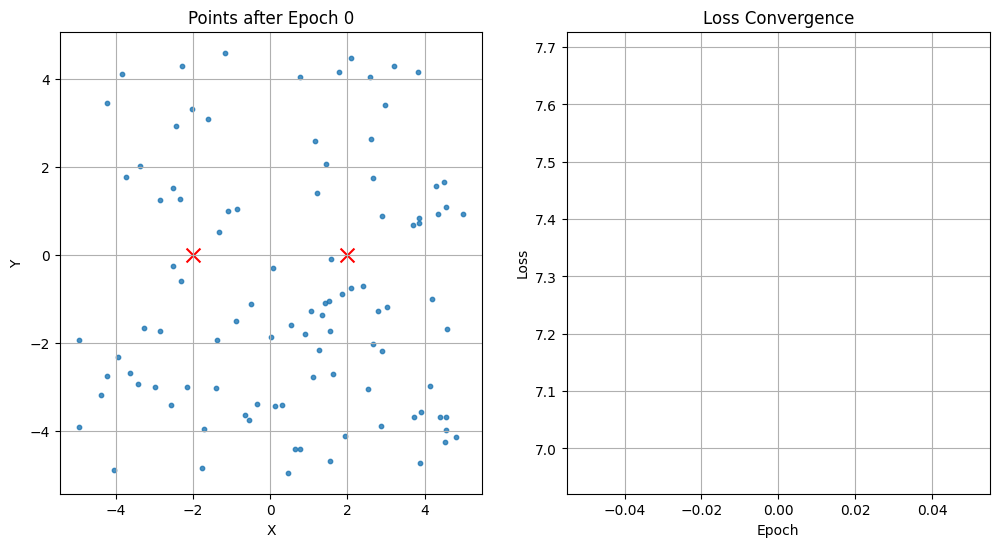

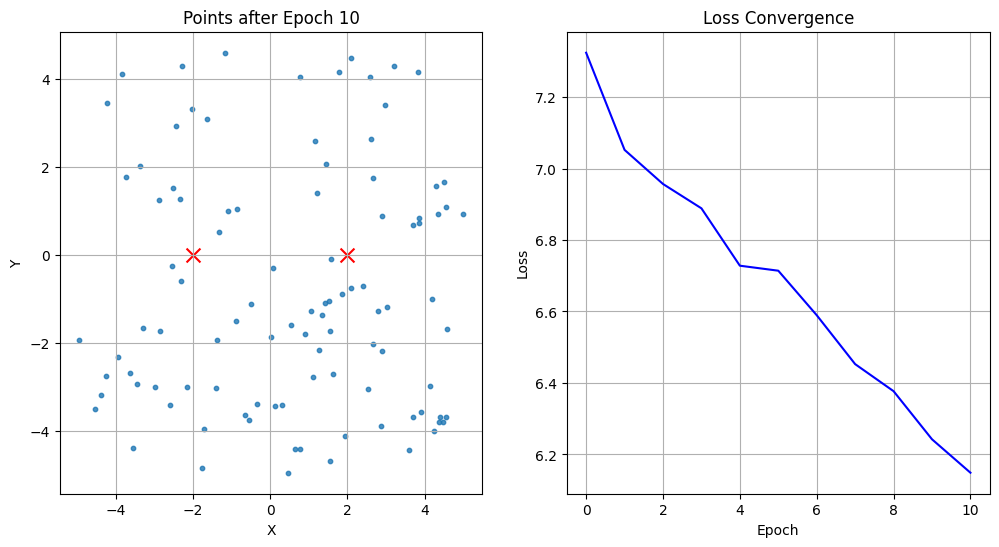

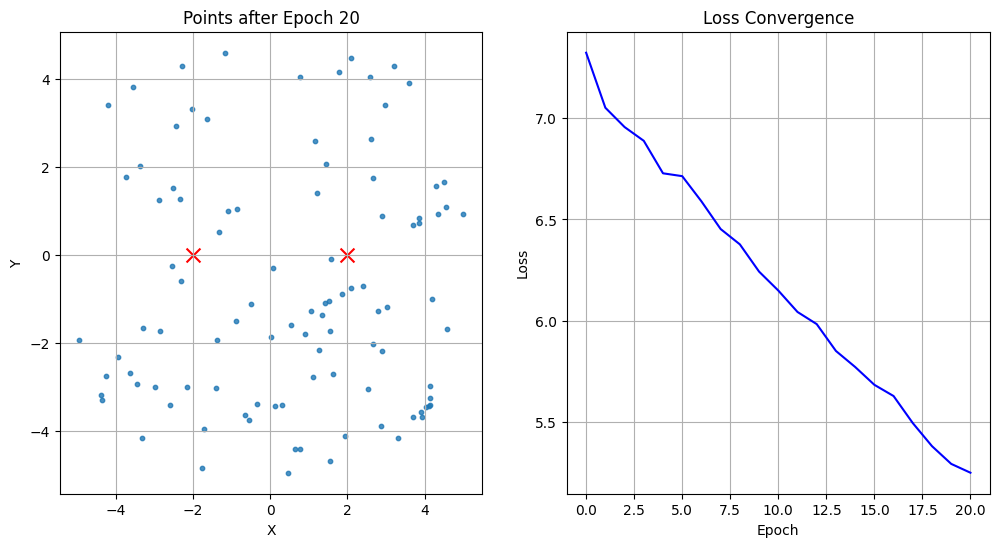

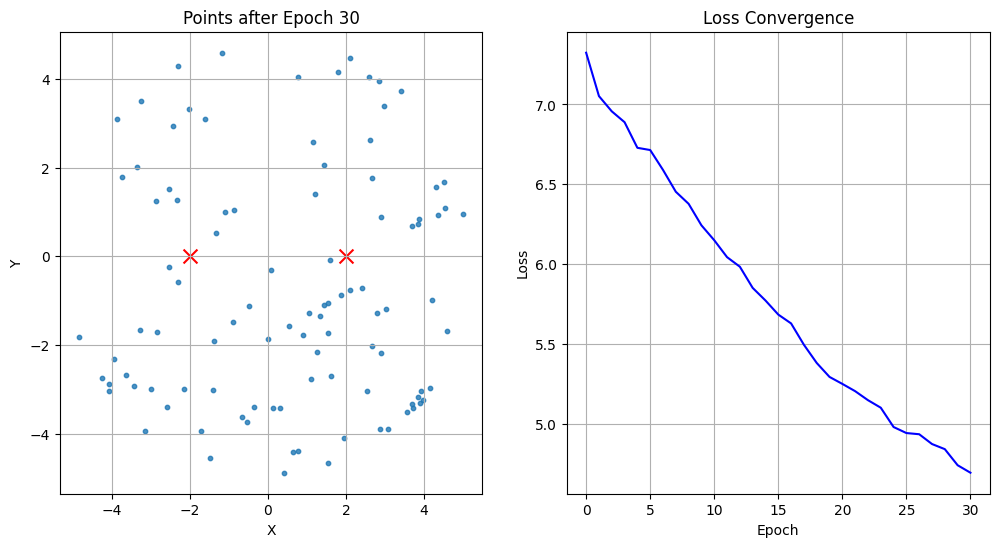

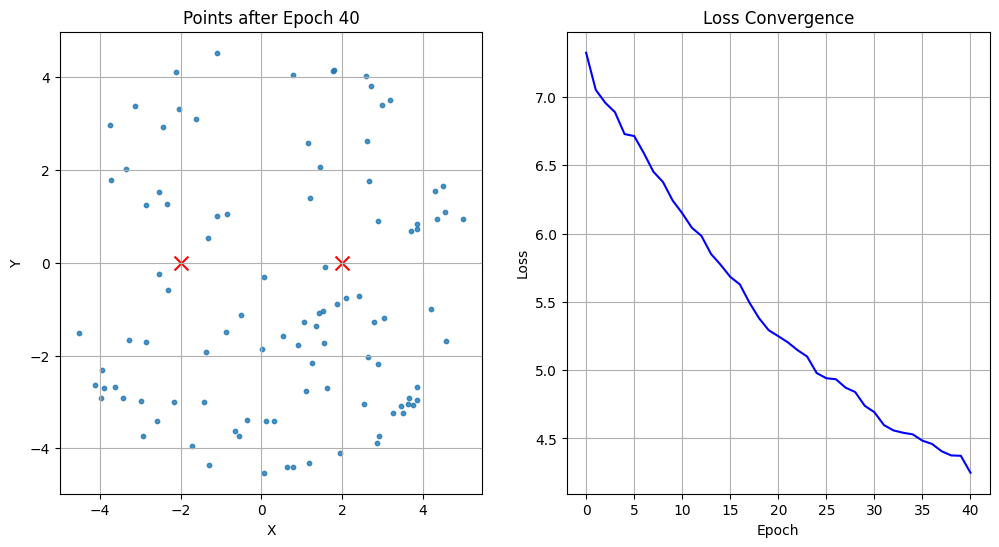

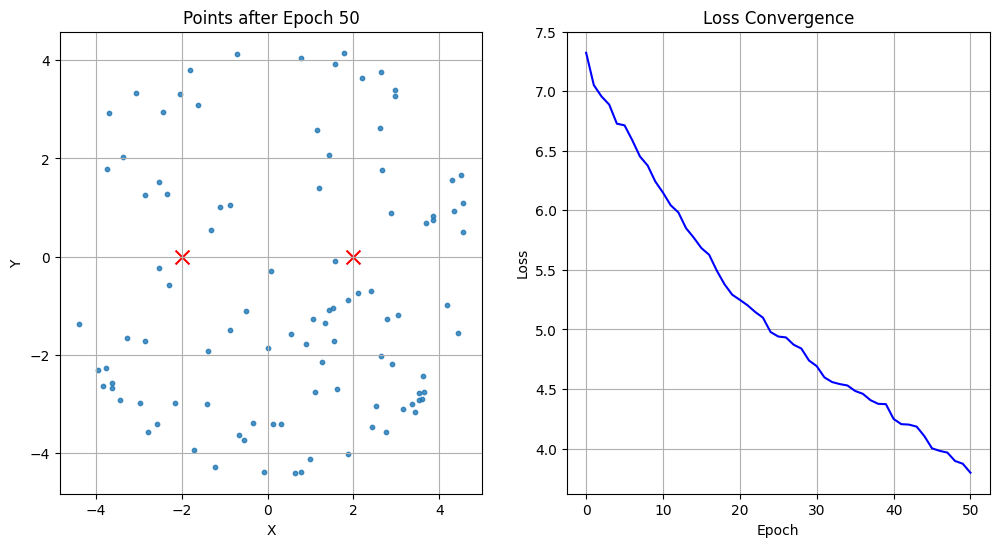

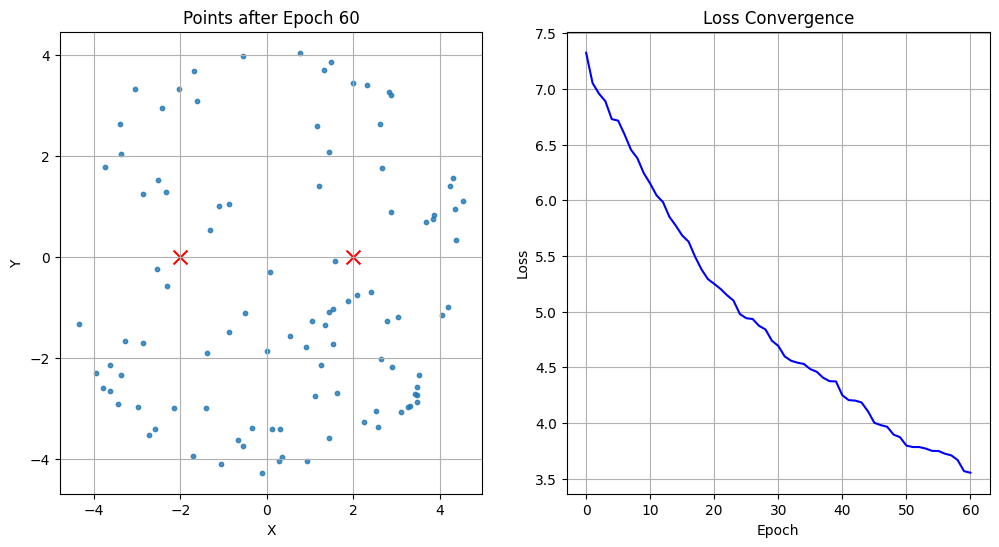

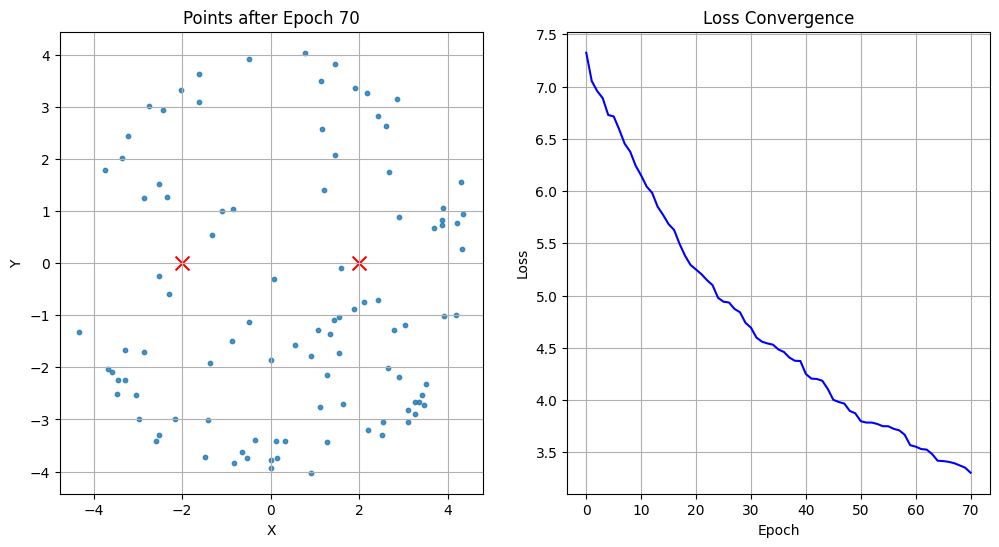

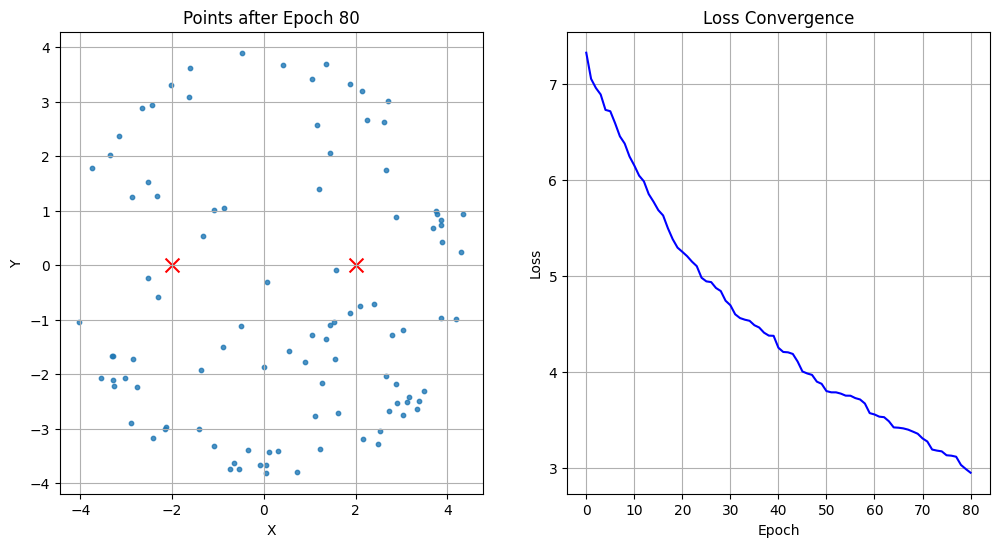

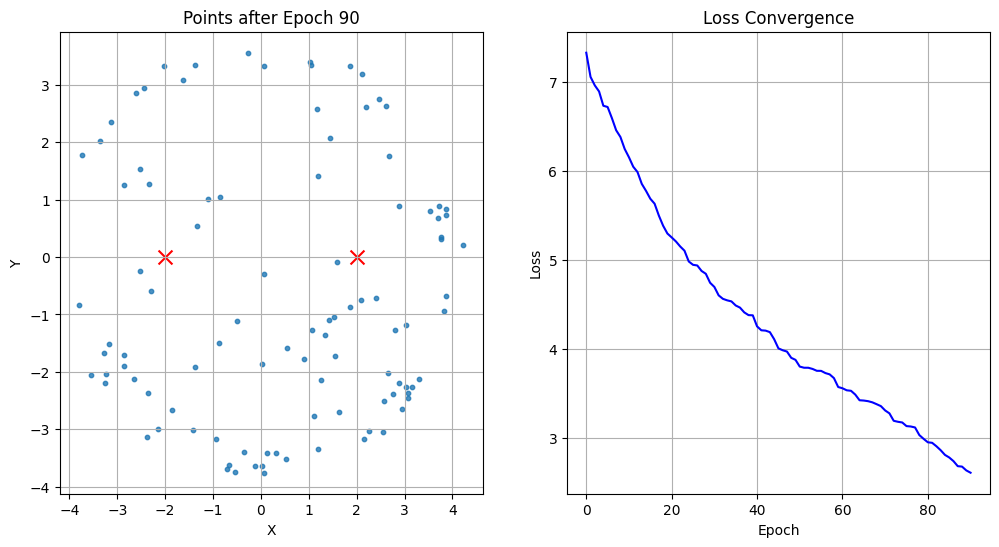

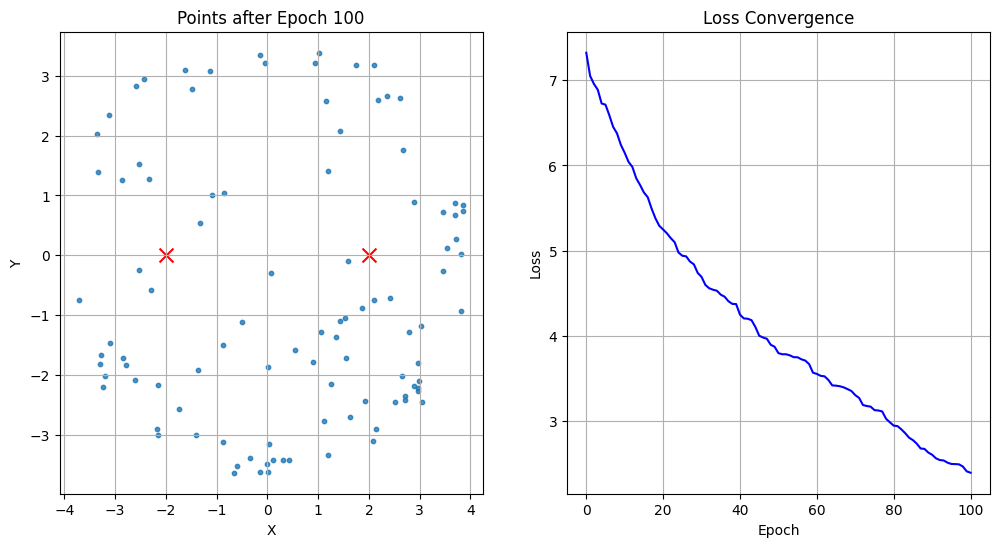

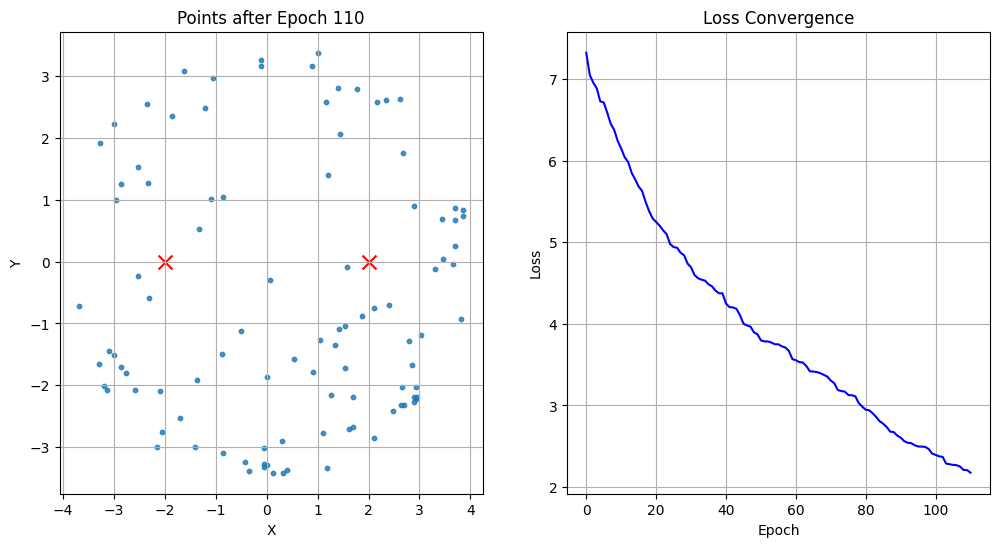

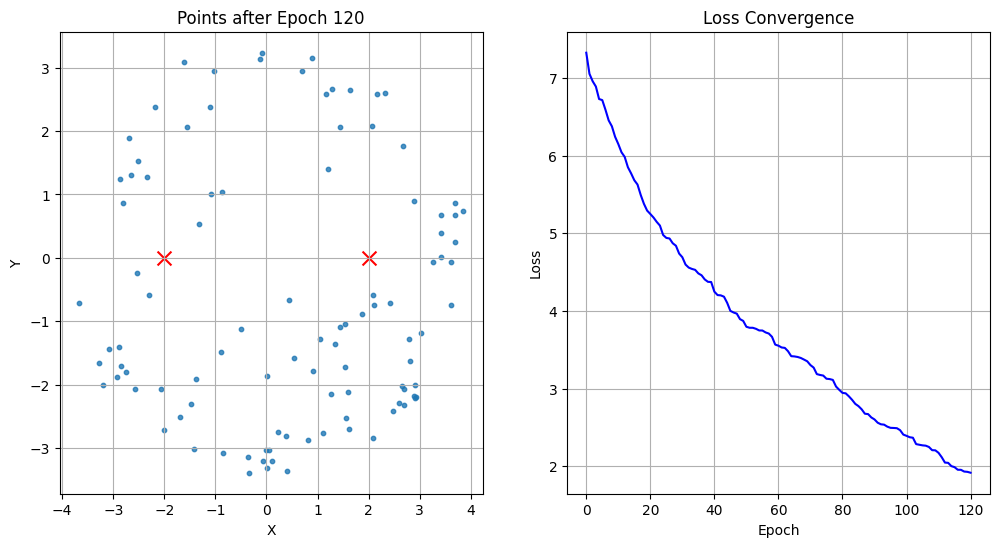

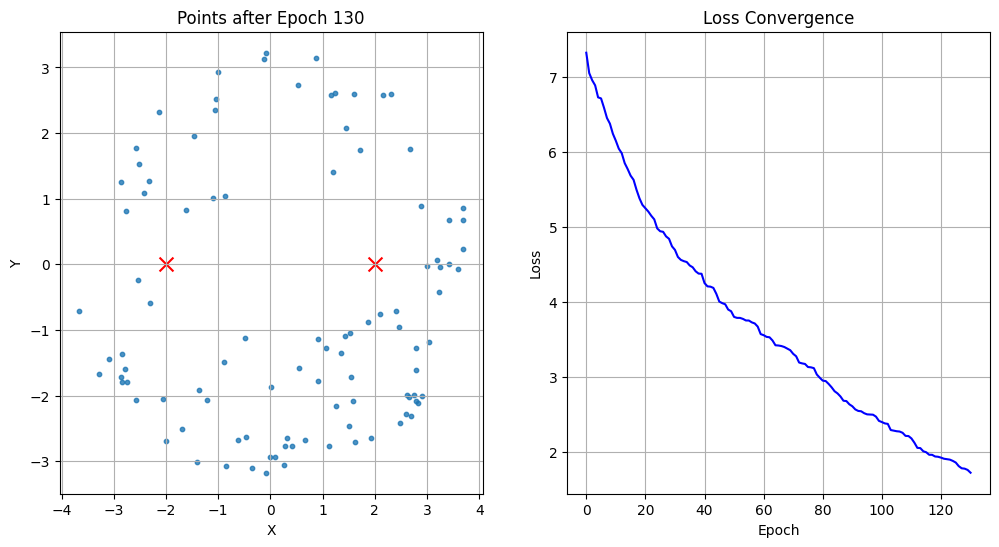

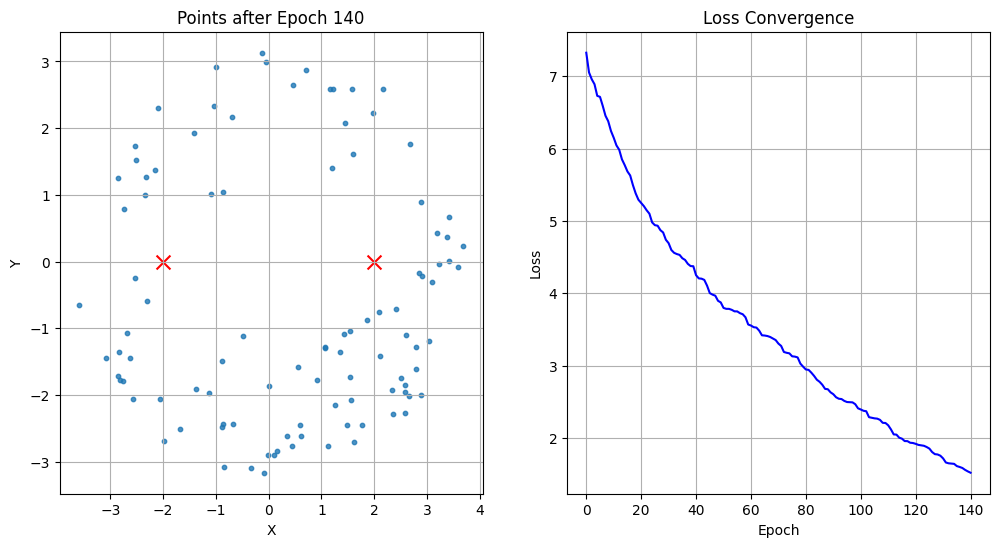

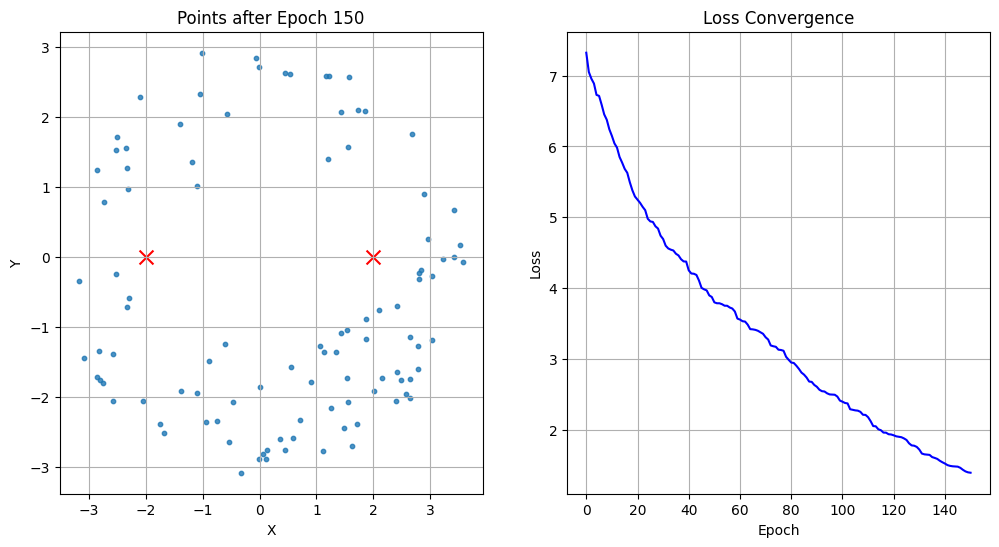

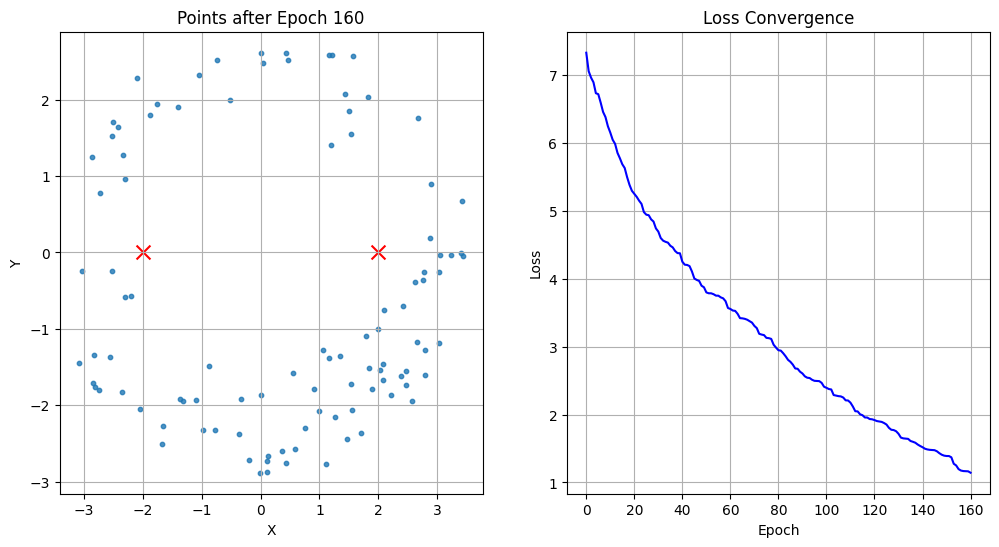

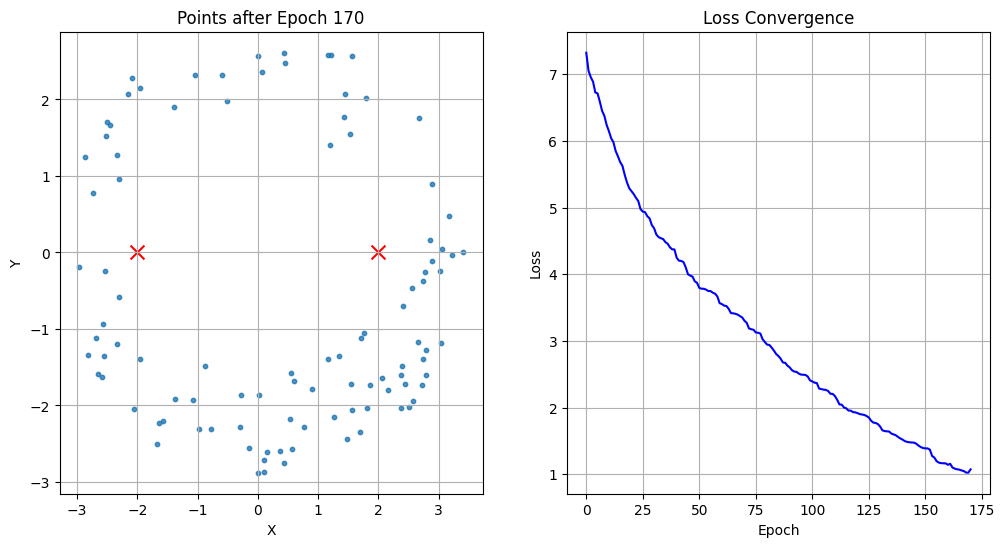

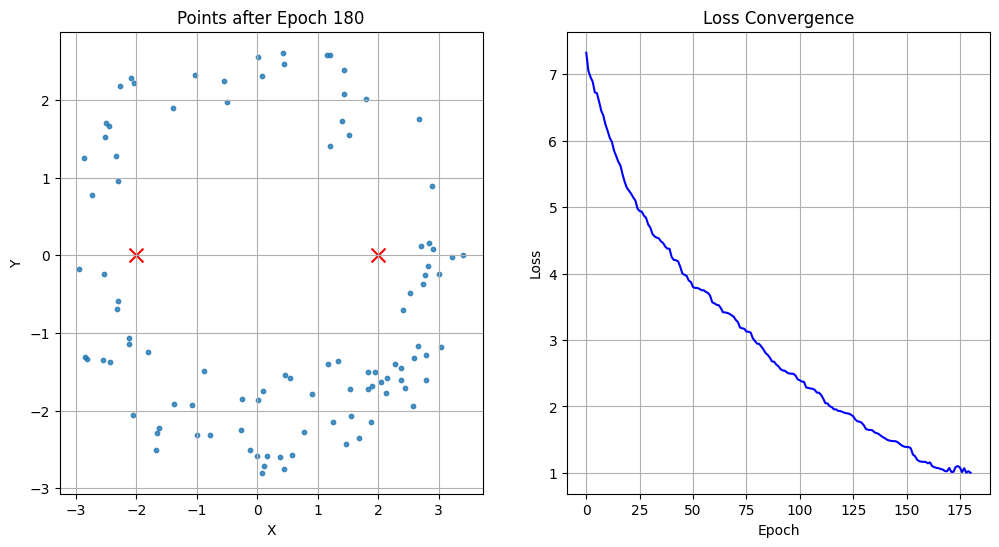

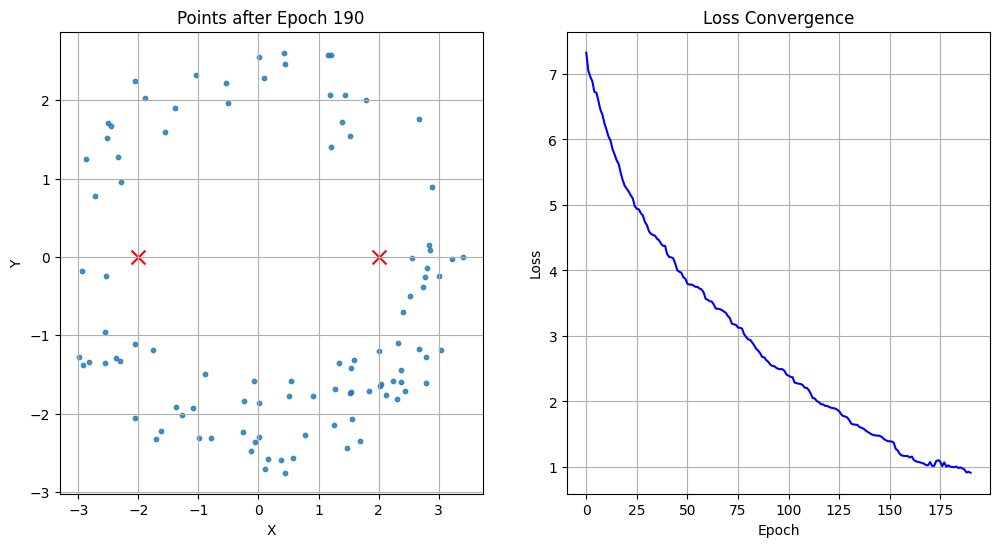

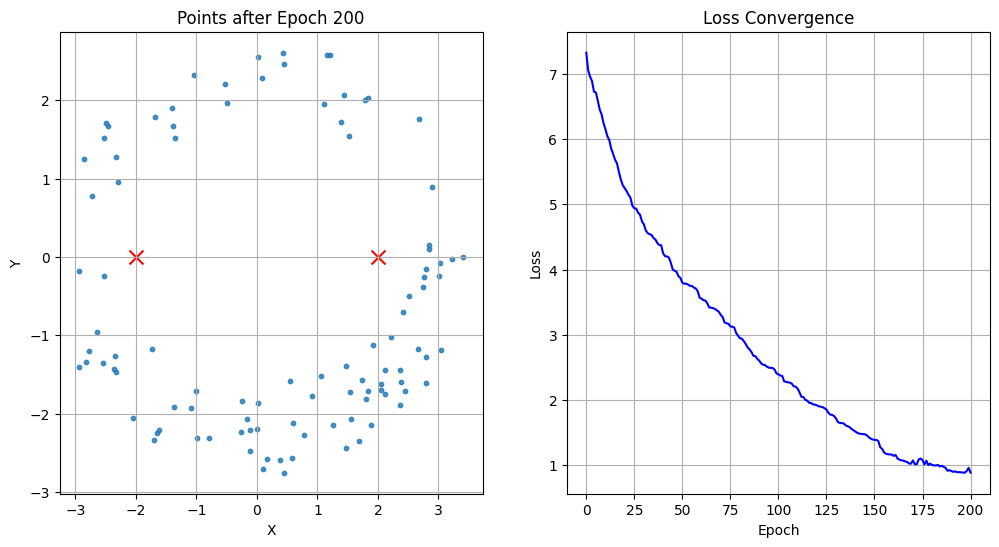

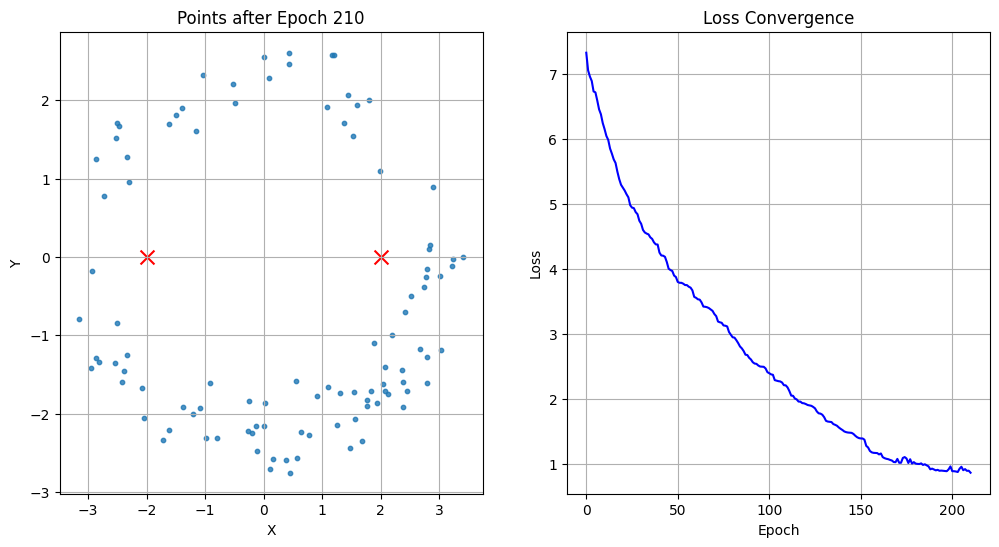

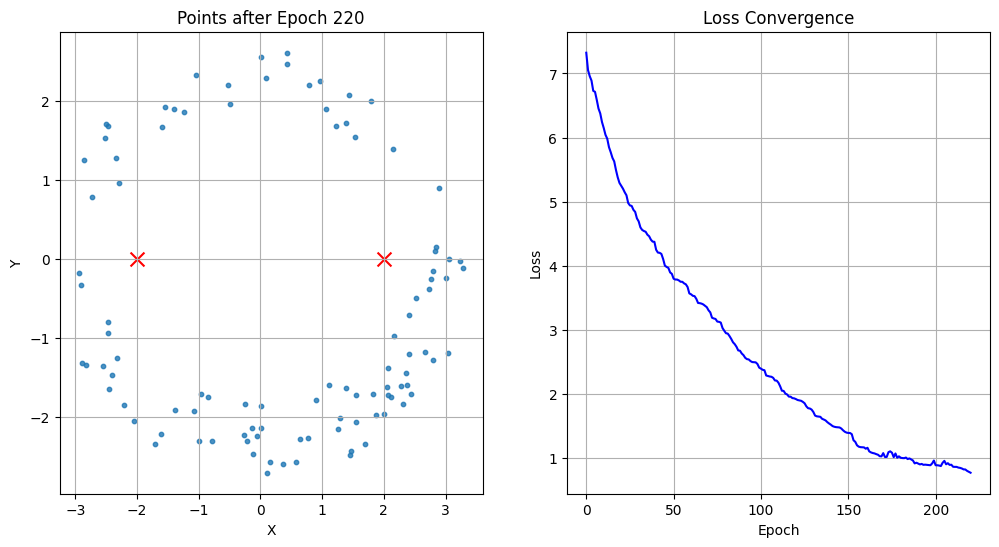

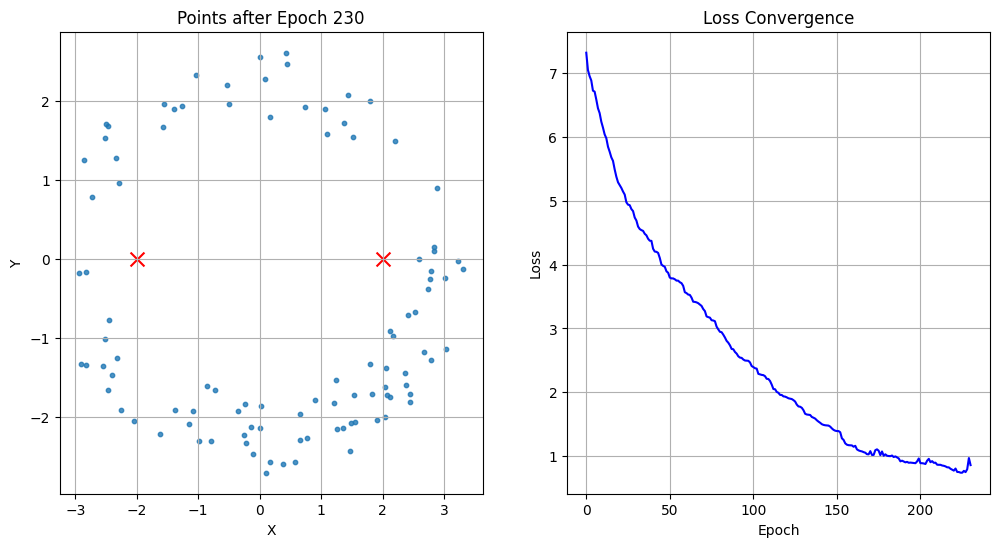

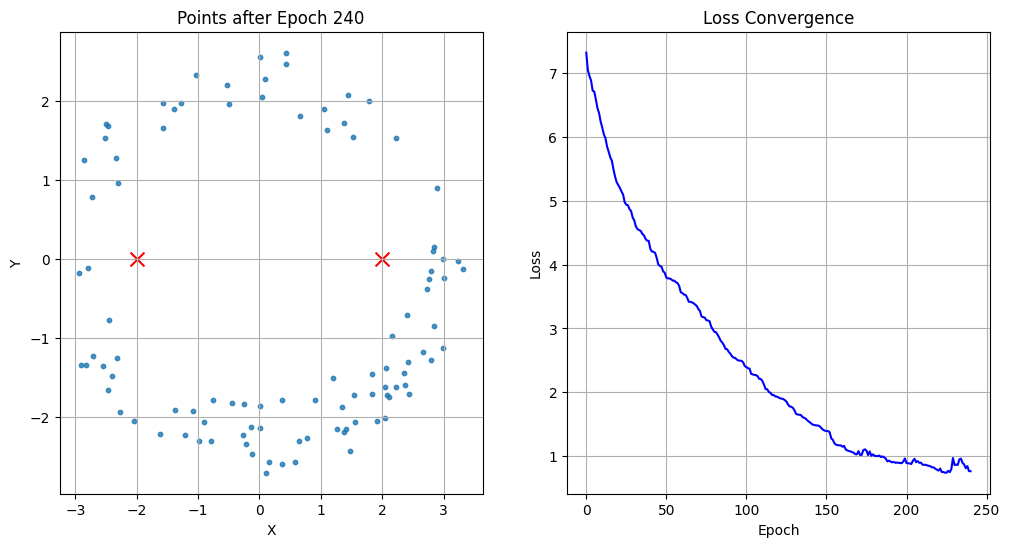

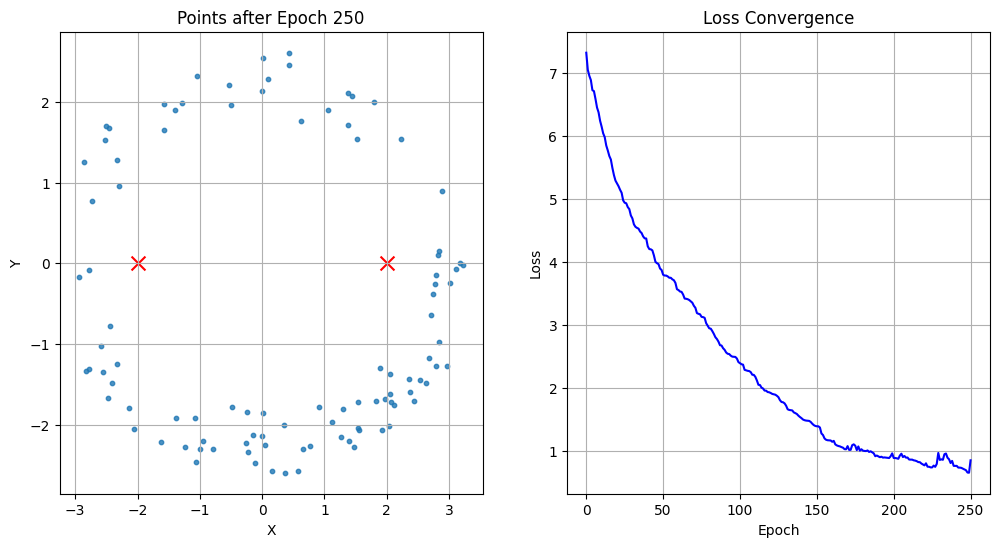

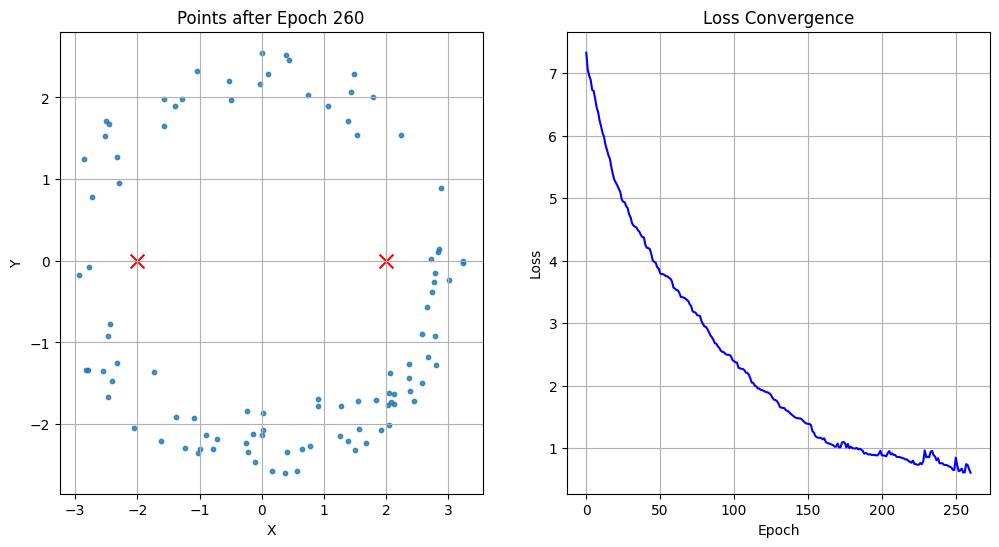

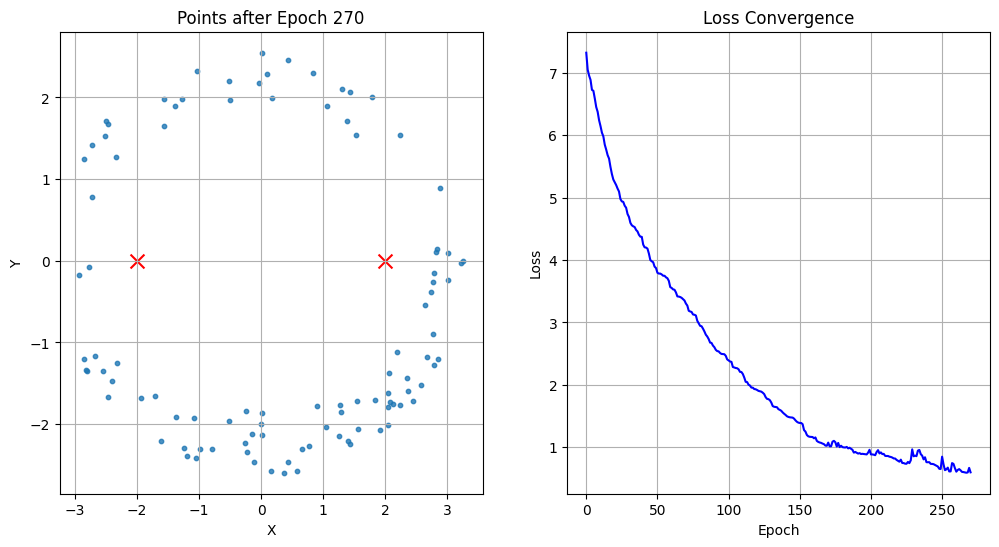

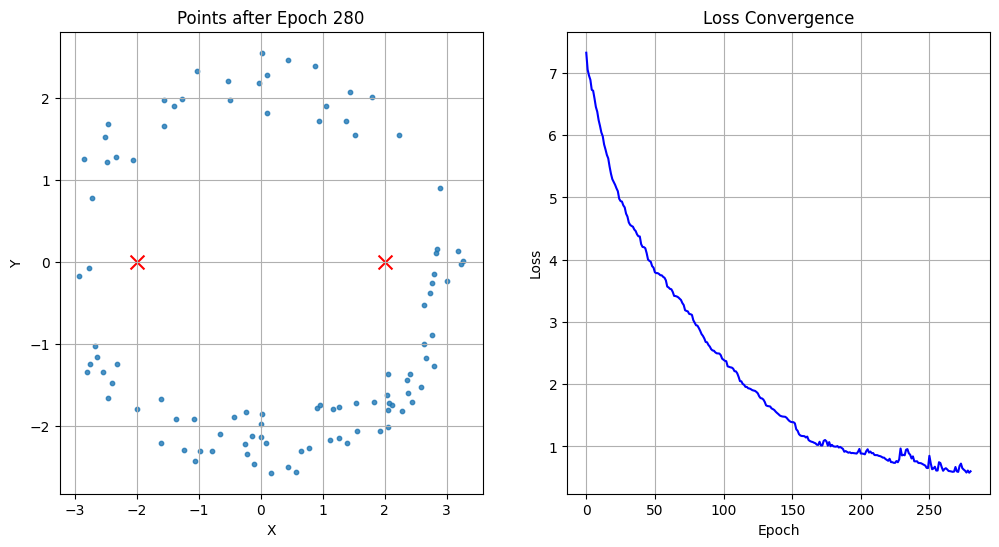

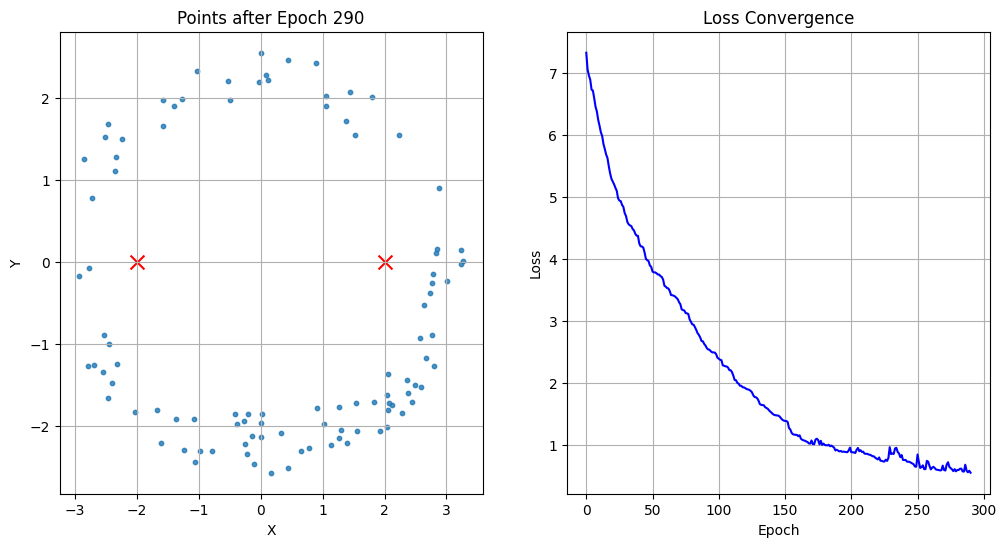

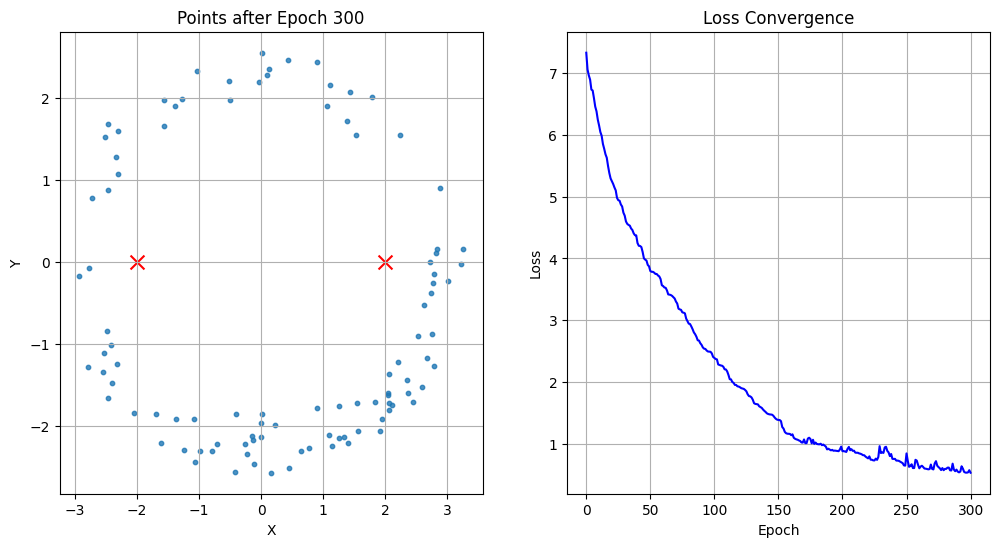

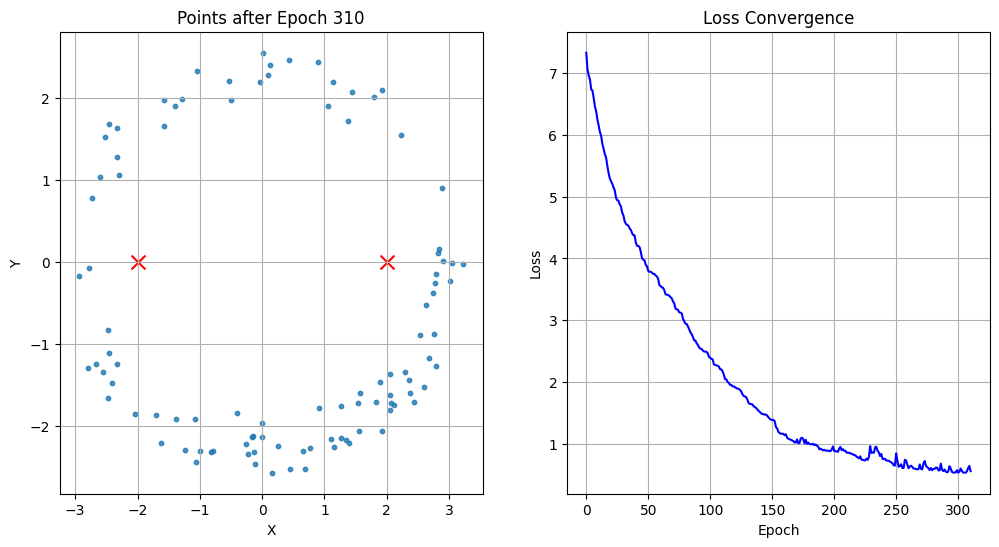

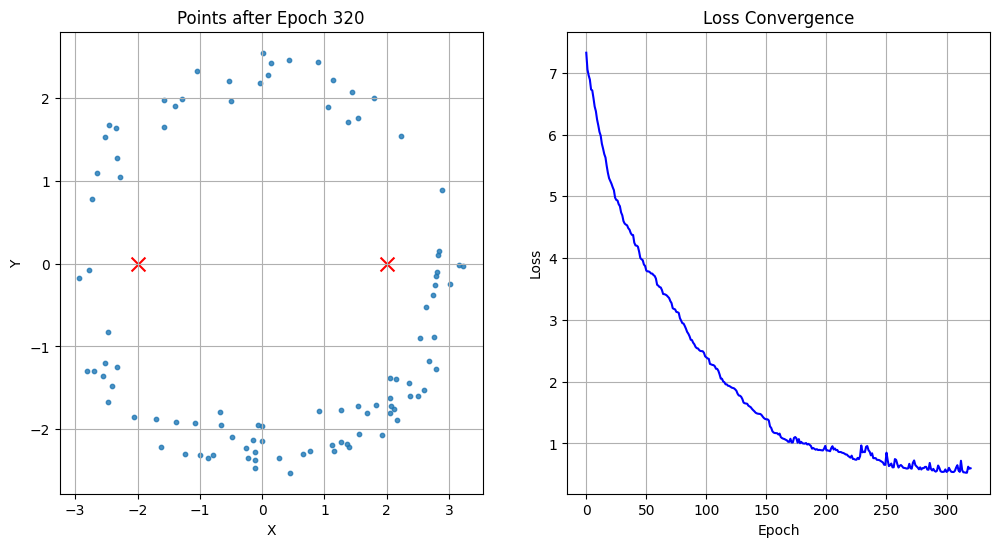

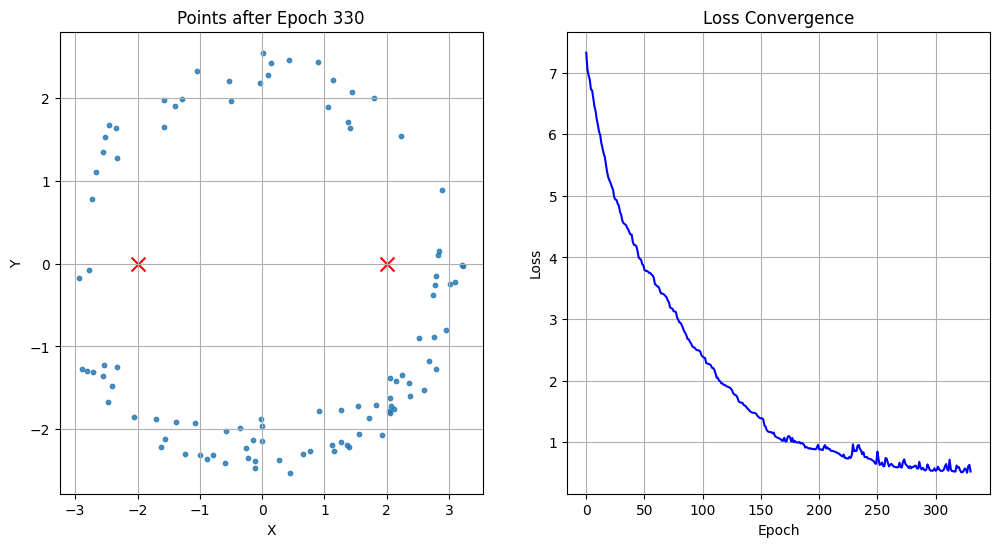

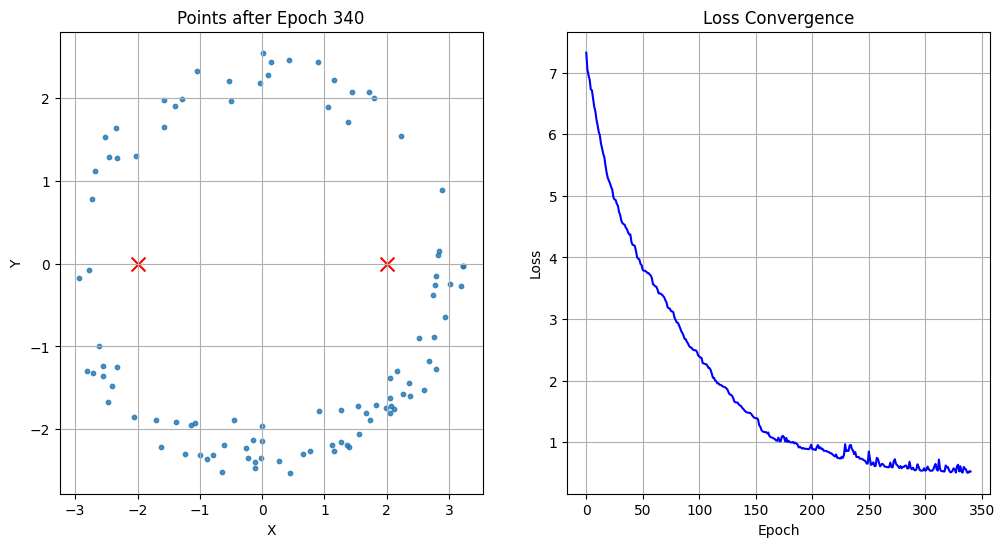

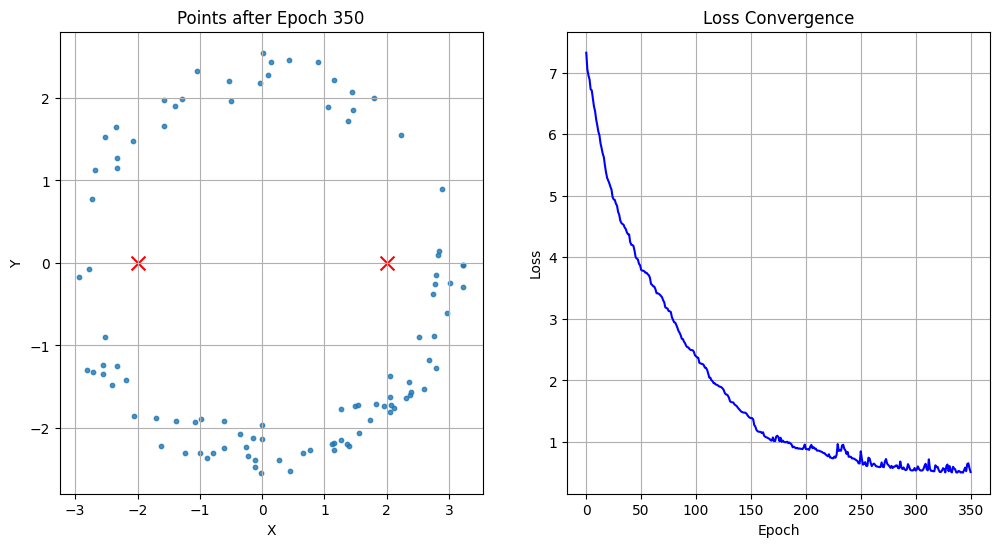

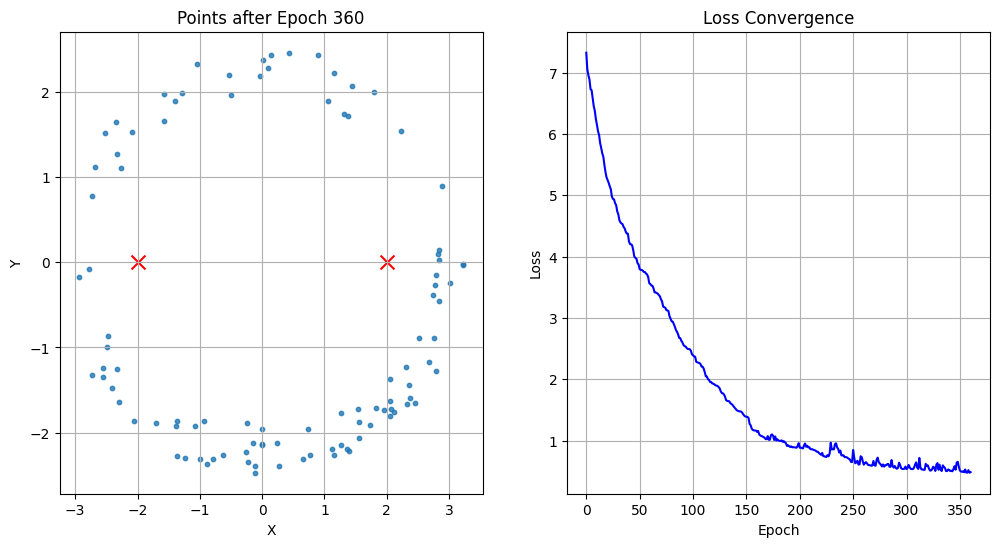

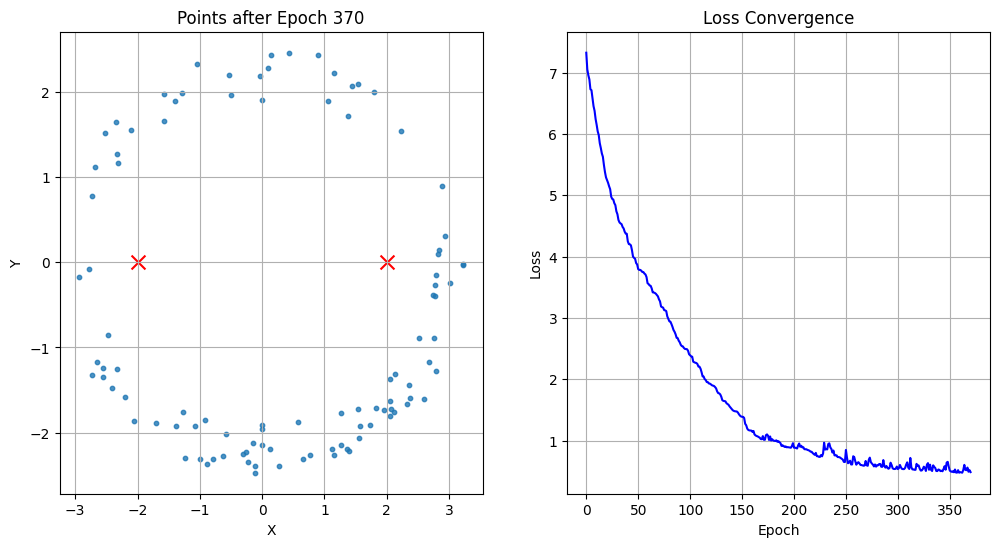

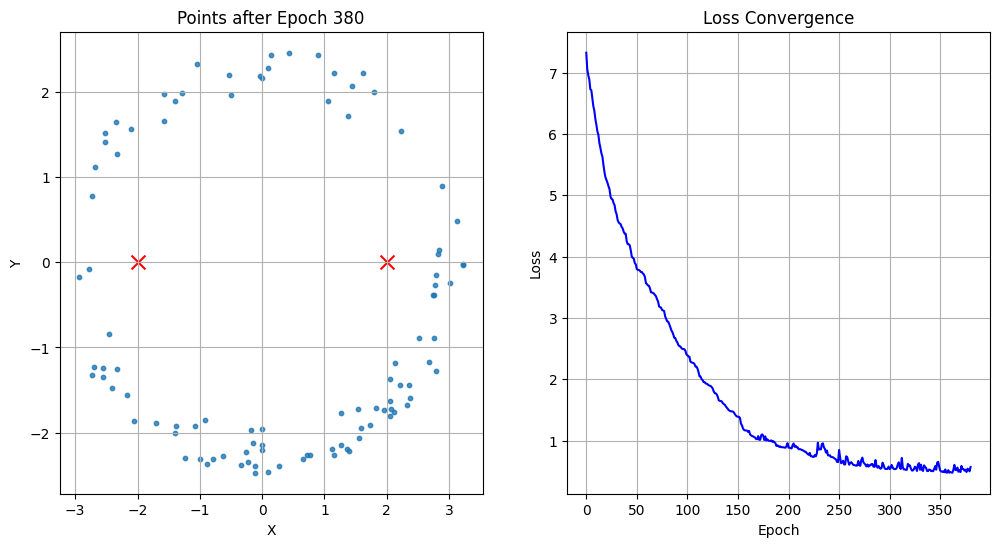

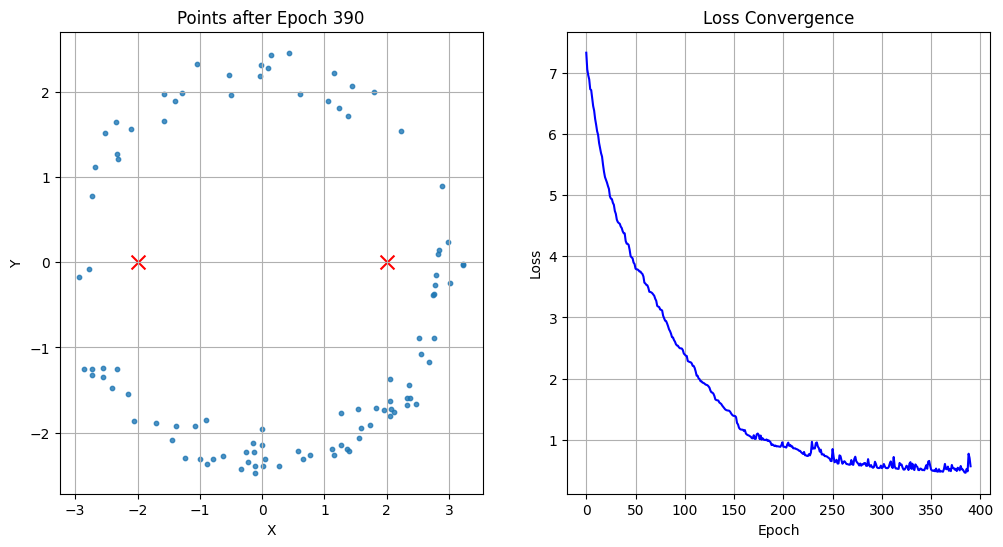

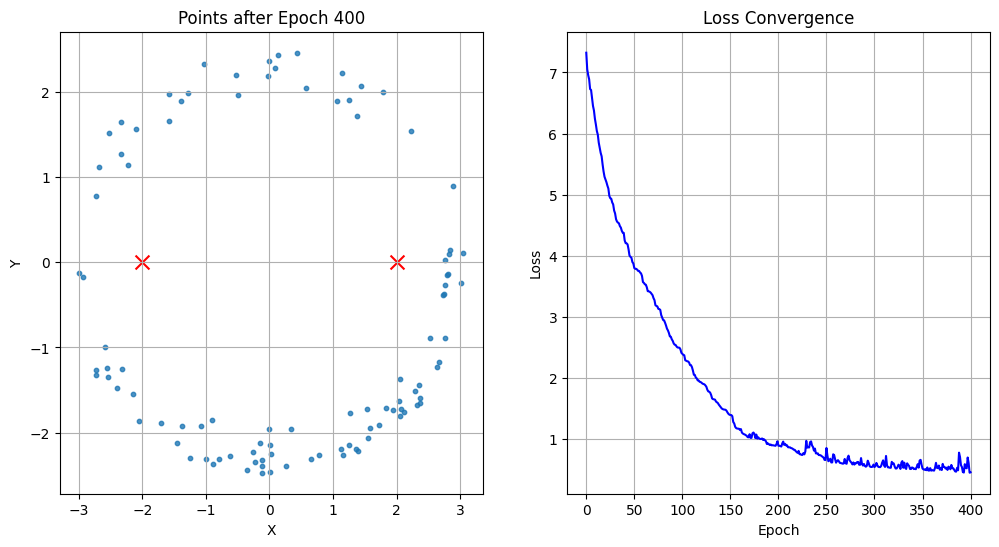

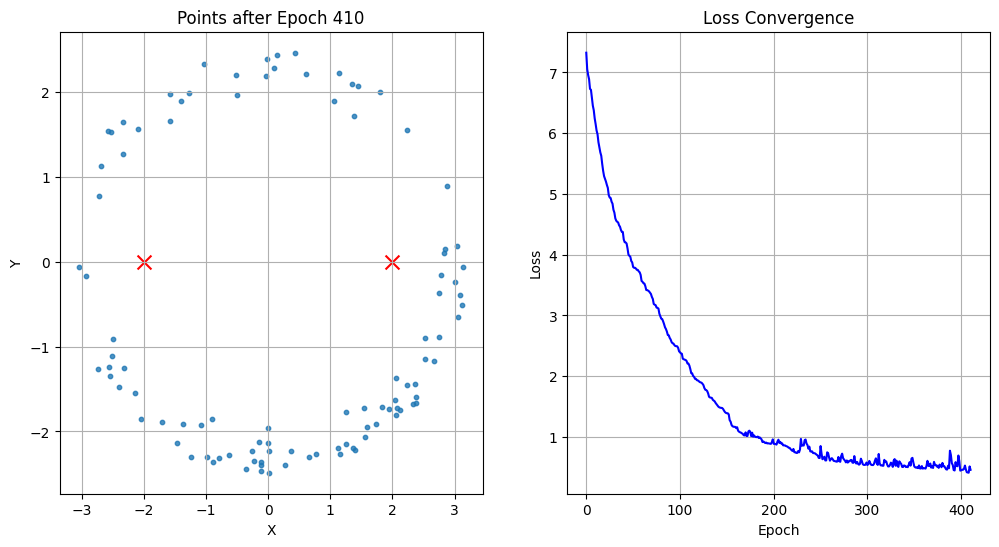

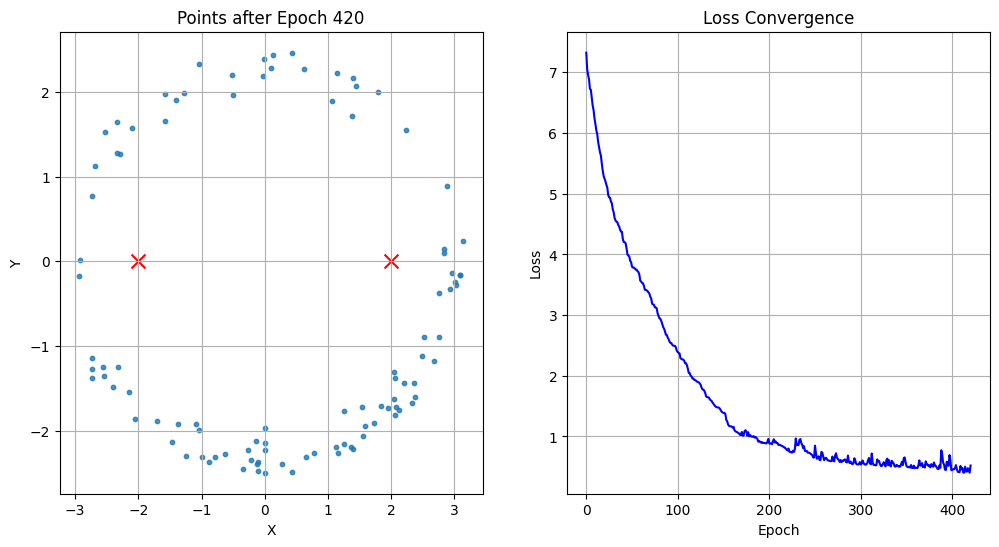

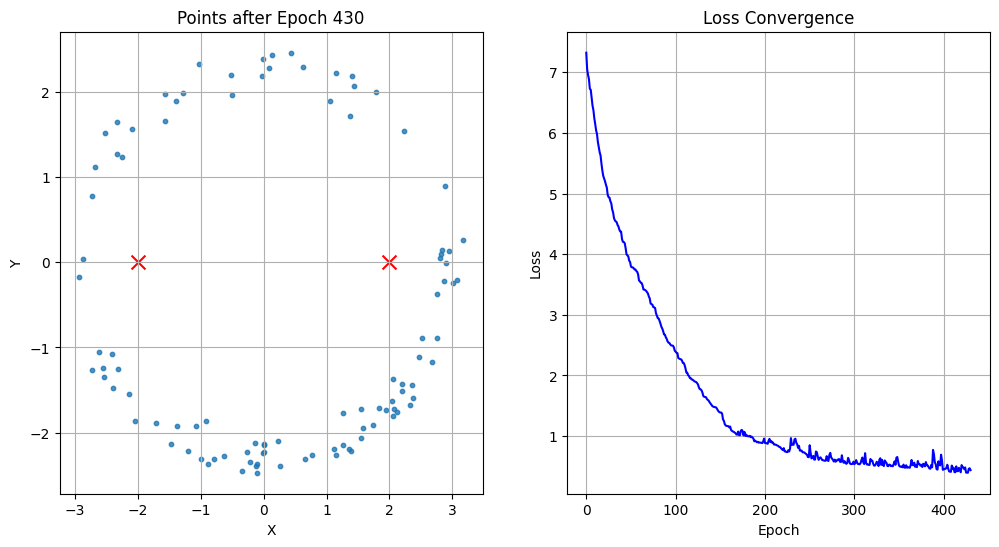

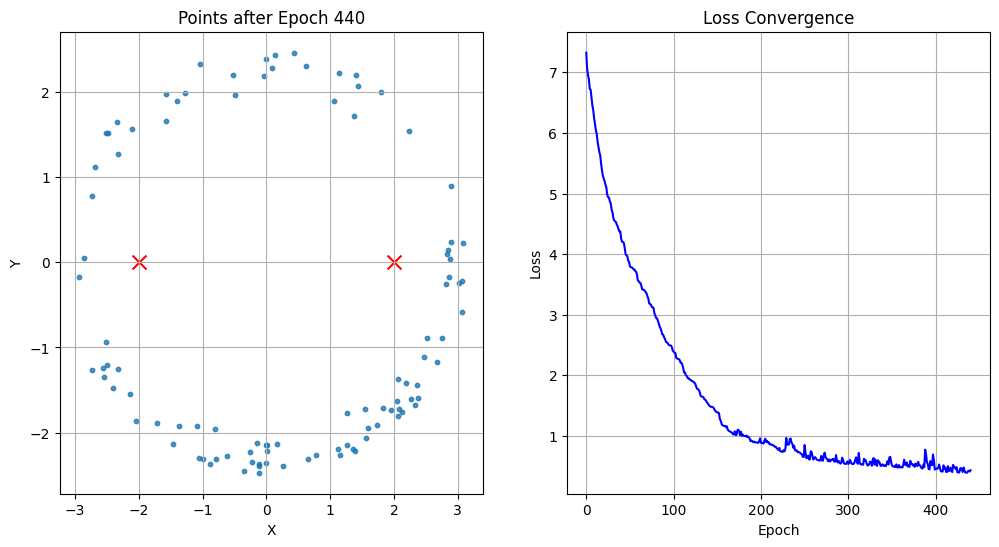

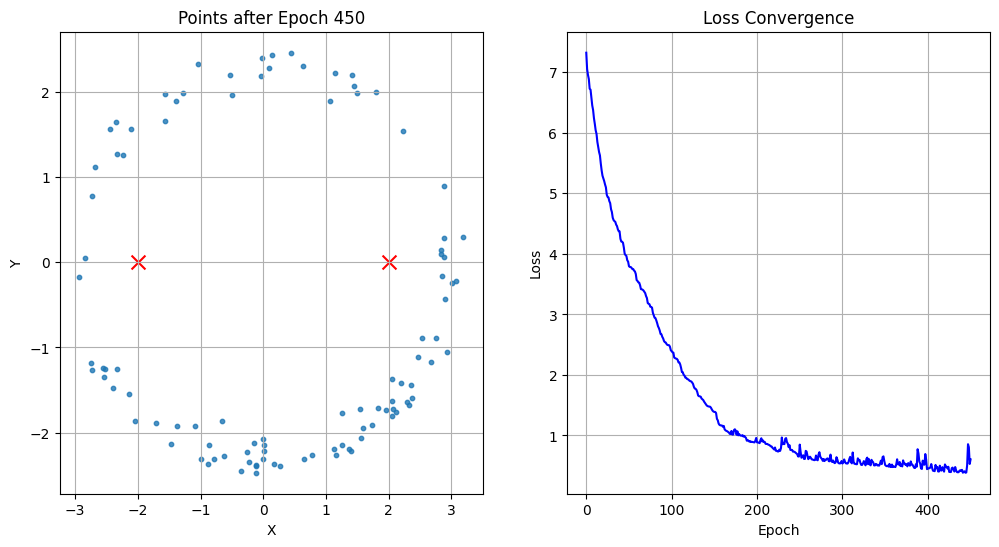

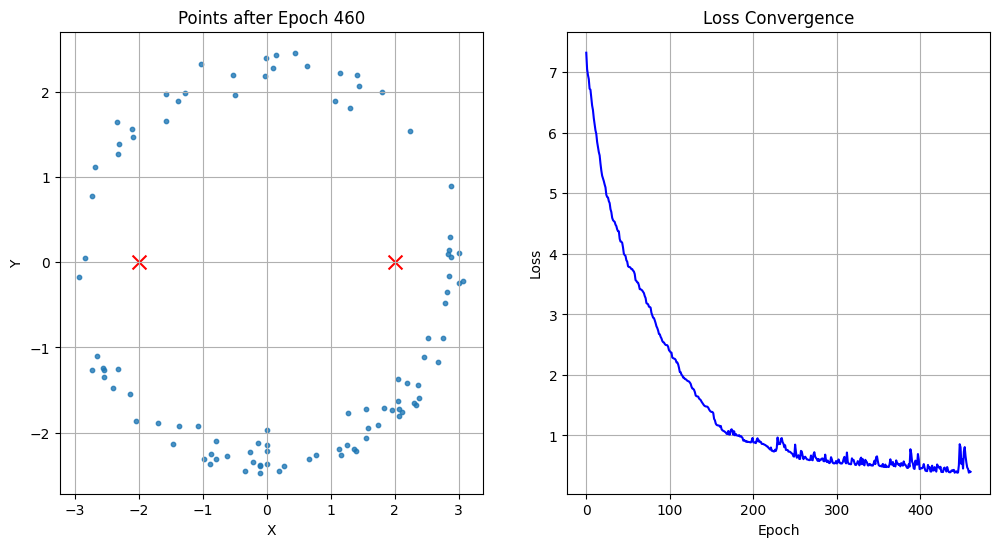

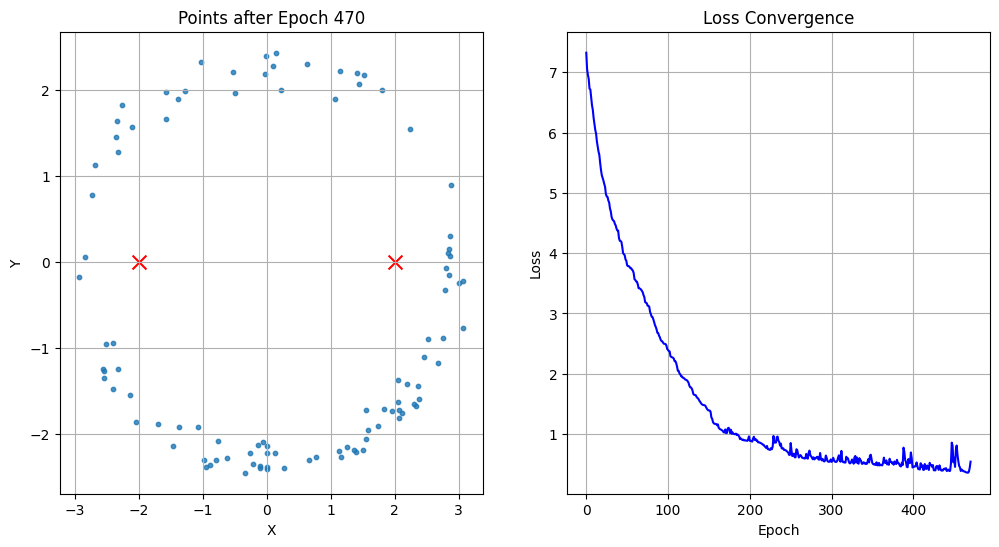

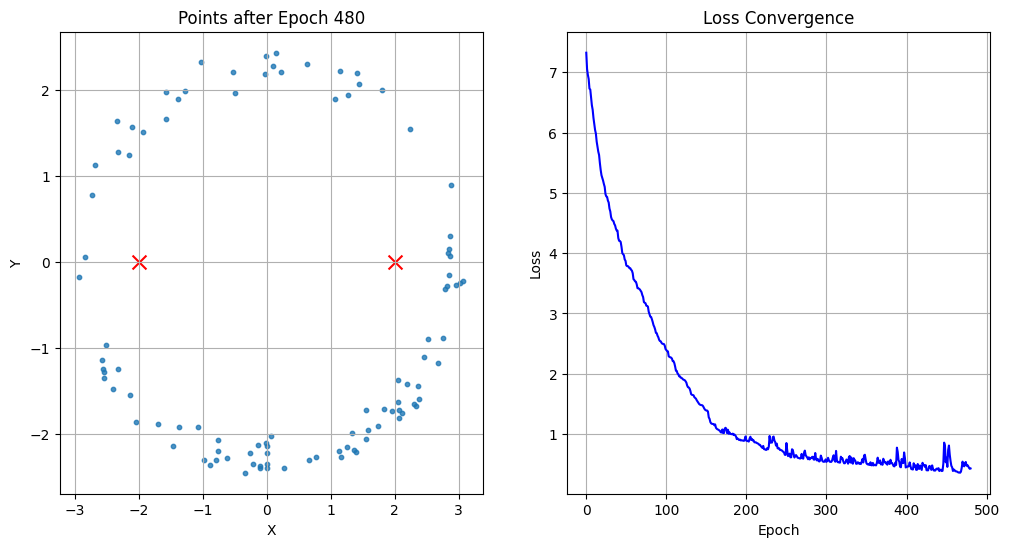

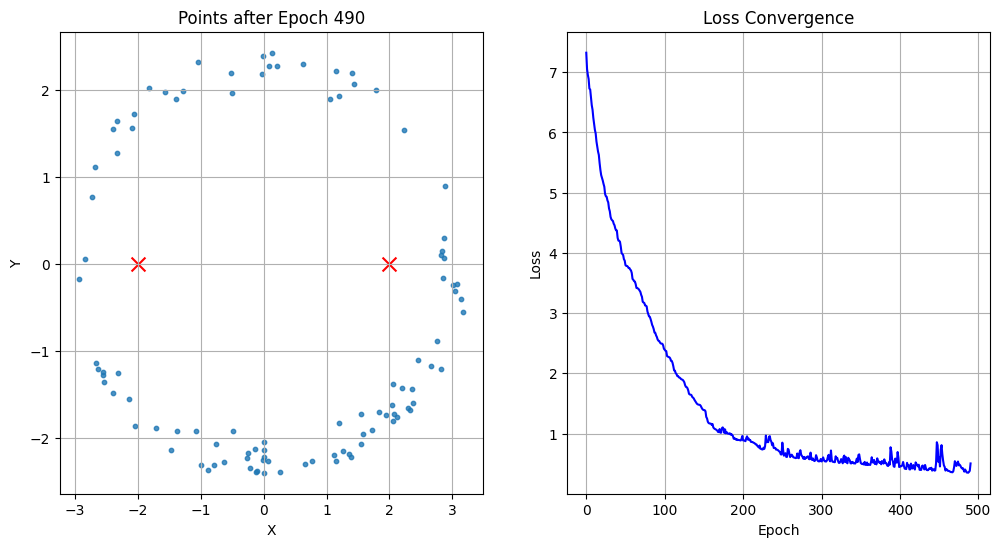

In [63]:
# L-Infinity optimization case
# - Problem: Very slow convergence
# - Cause: Updates focus only on the single worst-case point

# Reset point positions
torch.manual_seed(42)
points = torch.rand((num_points, 2)) * 10 - 5  # Initialize 2D points in [-5, 5]
points.requires_grad = True  # Enable gradient tracking

optimizer = torch.optim.Adam([points], lr=0.1)
loss_history = []  # Store loss values over time

for epoch in range(500):
    optimizer.zero_grad()  # Clear gradients

    # Compute deviations from the ellipse constraint
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)
    epsilon = dist1 + dist2 - constant_sum

    # L-Infinity loss: only the maximum absolute deviation matters
    loss = torch.max(torch.abs(epsilon))

    loss.backward()  # Backpropagate
    optimizer.step()  # Update parameters
    loss_history.append(loss.item())  # Save loss

    # Show results every 10 epochs
    if epoch % 10 == 0:
        plot_results(epoch, points, focus1, focus2, loss_history)


### Why $L^{(\infty)}_{\text{ellipse}}$ Trains Slowly and Doesn't Converge

The $L^\infty$ loss function is defined as:

$$
L^{(\infty)}_{\text{ellipse}} = \max_{i} |\epsilon_i|
$$

This loss focuses entirely on the **worst-case point**, i.e., the one that violates the ellipse constraint the most.

#### Why convergence is slow:
- Only the point with the **maximum residual** contributes to the loss and gradient.
- As a result, **most points do not receive any gradient updates** in a given step.
- The optimizer keeps adjusting a small subset of "worst" points, while others remain untouched.

#### Why it never fully converges:
- When one point improves and its $\epsilon_i$ drops, **another point becomes the new maximum**.
- The optimizer then shifts focus to that new outlier.
- This creates a **moving target** behavior, preventing simultaneous convergence for all points.

Ultimately, this leads to **very slow training** and an oscillating pattern of corrections that prevents the loss from reaching zero — even when most of the ellipse appears visually correct.
